# Аналитика в Яндекс.Афише

## Описание проета

Необходимо помочь маркетологам оптимизировать маркетинговые затраты.

В нашем распоряжении данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Необходимо изучить:
* как люди пользуются продуктом,
* когда они начинают покупать,
* сколько денег приносит каждый клиент
* когда клиент окупается.

Описание данных.

Таблица visits (лог сервера с информацией о посещениях сайта):
* <i>Uid</i> — уникальный идентификатор пользователя
* <i>Device</i> — категория устройства пользователя
* <i>Start Ts</i> — дата и время начала сессии
* <i>End Ts</i> — дата и время окончания сессии
* <i>Source Id</i> — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
* <i>Uid</i> — уникальный id пользователя, который сделал заказ
* <i>Buy Ts</i> — дата и время заказа
* <i>Revenue</i> — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
* <i>source_id</i> — идентификатор рекламного источника
* <i>dt — дата</i>
* <i>costs</i> — затраты на этот рекламный источник в этот день

## Оглавление

1. [Открытие данных](#open_data)
2. [Предобработка данных](#preprocessing)
    * [Замена названий столбцов](#columns_names)
    * [Преобразование типов данных](#data_types)
    * [Поиск дубликатов](#duplicates)
3. [Построение отчетов и расчет метрик](#reports)
    * [Продукт](#product)
        * [Количество пользователей сервиса в день, неделю, месяц](#users)
        * [Количество пользователей сервиса в день, неделю, месяц в разбивке по платформам](#users_by_platform)
        * [Количество пользователей сервиса в день, неделю, месяц в разбивке по источиника трафика](#users_by_source)
        * [Количество сессий в день](#sessions)
        * [Количество сессий в день в разбивке по платформам](#sessions_by_platform)
        * [Количество сессий в день в разбивке по источникам трафика](#sessions_by_source)
        * [Длительность одной сессии](#duration)
        * [Длительность одной сессии в разбивке по платформам](#duration_by_platform)
        * [Длительность одной сессии в разбивке по источникам трафика](#duration_by_source)
        * [Возвращаемость пользователей](#retention)
        * [Вывод](#output_product)
    * [Продажи](#sales)
        * [Когда люди начинают покупать?](#first_purchase)
        * [Сколько раз покупают за период?](#purchase_count)
        * [Средний чек](#purchase_mean_value)
        * [Сколько денег приносят?(LTV)](#ltv)
        * [Вывод](#output_sales)
    * [Маркетинг](#marketing)
        * [Общие расходы и расходы в разбивке на каждый источник трафика / по времени](#costs)
        * [Стоимость привлечения одного покупателя из каждого источника](#cac)
        * [Окупаемость расходов(ROI)](#roi)
        * [Вывод](#output_marketing)
4. [Общий вывод](#output)

## Открытие данных <a id="open_data"></a>

Достанем данные из файлов. Начнем с таблицы visits.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
visits = pd.read_csv('C:/Users/Евгения/Documents/yandex.prakticum/project7/visits_log.csv')

Посмотрим на первые 5 строчек таблицы.

In [3]:
visits.head()

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

Теперь посмотрим общую информацию по таблице.

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


В таблице 359400 строк и 5 столбцов, которые занимают 13.7 Мб. Пропусков в столбцах нет. У столбцов с датой и временем нужно будет поменять тип данных на datetime. Названия столбцов начинаются с заглавных букв, а также в названиях есть пробелы. Надо будет поменять названия на строчные буквы без пробелов, так будет удобней работать.

Теперь достанем данные из таблицы orders.

In [5]:
orders = pd.read_csv('C:/Users/Евгения/Documents/yandex.prakticum/project7/orders_log.csv')

In [6]:
orders.head()

Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


В таблице 50415 строк и 3 столбца, которые занимают 1.2 Мб. Пропусков нет, типы данных правильные. Здесь также придется поменять названия столбцов. Посмотрим теперь на характеристики столбца с выручкой.

In [8]:
orders.describe()

Revenue           Uid
count  50415.000000  5.041500e+04
mean       4.999647  9.098161e+18
std       21.818359  5.285742e+18
min        0.000000  3.135781e+14
25%        1.220000  4.533567e+18
50%        2.500000  9.102274e+18
75%        4.890000  1.368290e+19
max     2633.280000  1.844617e+19

Видим, что средняя выручка около 5, медиана - 2,5. Стандартное отклонение - 21,82 и есть очень большой максимум 2633.28, тогда как 75% значений выручки не превышают 4,89. Значит есть несколько выбросов, которые смещают все распределение в сторону больших значений.

Теперь достанем данные из таблицы costs.

In [9]:
costs = pd.read_csv('C:/Users/Евгения/Documents/yandex.prakticum/project7/costs.csv')

In [10]:
costs.head()

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

In [11]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [12]:
costs.describe()

source_id        costs
count  2542.000000  2542.000000
mean      4.857199   129.477427
std       3.181581   156.296628
min       1.000000     0.540000
25%       2.000000    21.945000
50%       4.000000    77.295000
75%       9.000000   170.065000
max      10.000000  1788.280000

В таблице 2542 строки и 3 столбца, которе занимают 59.7 Кб. Пропусков нет. Столбец с датой dt нужно будет привести к типу datetime. Среднее значение затрат на маркетиг составило 129.5, а медиана 77.3. 75% значений затрат на маркетинг не превышало 170. Стандартное отклонение - 156.3, а максималоное - 1788.3, значит распределение затрат на маркетинг имеет несколько выбросов с большими значениями и все распределение смещено вправо.

<b>Вывод:</b> у нас имеются 3 таблицы с данными о посещениях сайта Яндекс.Афиши за период с июня 2017 по конец мая 2018, выгрузкой всех заказов за этот период и статистикой рекламных расходов. Все вместе данные таблиц занимают почти 15 Мб. В данных нет пропусков, но столбцы с датами нужно будет привести к типу datetime. В таблицах visits и orders нужно будет переименовать столбцы, чтобы с ними было удобнее работать.

# Предобработка данных <a id="preprocessing"></a>

### Замена названий столбцов <a id="columns_names"></a>

Поменяем названия столбцов в таблицах visits и orders. Начнем с таблицы visits.

In [13]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [14]:
visits.head()

device               end_ts  source_id             start_ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

Теперь поменяем названия столбцов в таблице orders.

In [15]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [16]:
orders.head()

buy_ts  revenue                   uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

Названия столбцов успешно заменены на новые.

### Преобразование типов данных <a id="data_types"></a>

В столбцах с датой и временем в таблицах нужно поменять тип данных object на datetime. Начнем с таблицы visits.

In [17]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [18]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [19]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


В таблице visits типы данных успешно преобразованы. Теперь поменяем тип данных в таблице orders.

In [20]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [21]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


В таблице orders столбец с датой и временем успешно преобразован. Теперь перейдем к таблице costs.

In [22]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [23]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


В таблице costs столбец с датой преобразован к типу данных datetime.

### Поиск дубликатов <a id='duplicates'></a>

Посмотрим, есть ли дубликаты в наших таблицах.

In [24]:
visits.duplicated().sum()

0

In [25]:
orders.duplicated().sum()

0

In [26]:
costs.duplicated().sum()

0

Дубликатов в таблицах нет.

## Построение отчетов и расчет метрик <a id="reports"></a>

### Продукт <a id="product"></a>

#### Количество пользователей сервиса в день, неделю, месяц <a id="users"></a>

Посчитаем количество людей, которые пользуются сервисом в день, неделю и месяц. Для этого создадим столбцы с началом дня, недели и месяца в таблице visits.

In [27]:
visits['date_visit'] = visits['start_ts'].astype('datetime64[D]')

In [28]:
visits['week_visit'] = visits['start_ts'].astype('datetime64[W]')

In [29]:
visits['month_visit'] = visits['start_ts'].astype('datetime64[M]')

In [30]:
visits.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid date_visit week_visit month_visit  
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01  
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01  
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01  
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01  
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01

Теперь посчитаем количество пользователей в месяц, для этого сгруппируем таблицу по месяцам.

In [31]:
mau = visits.groupby('month_visit').agg({'uid':'nunique'})

In [32]:
mau = mau.sort_values(by='month_visit').reset_index()

In [33]:
mau

month_visit    uid
0   2017-06-01  13259
1   2017-07-01  14183
2   2017-08-01  11631
3   2017-09-01  18975
4   2017-10-01  29692
5   2017-11-01  32797
6   2017-12-01  31557
7   2018-01-01  28716
8   2018-02-01  28749
9   2018-03-01  27473
10  2018-04-01  21008
11  2018-05-01  20701

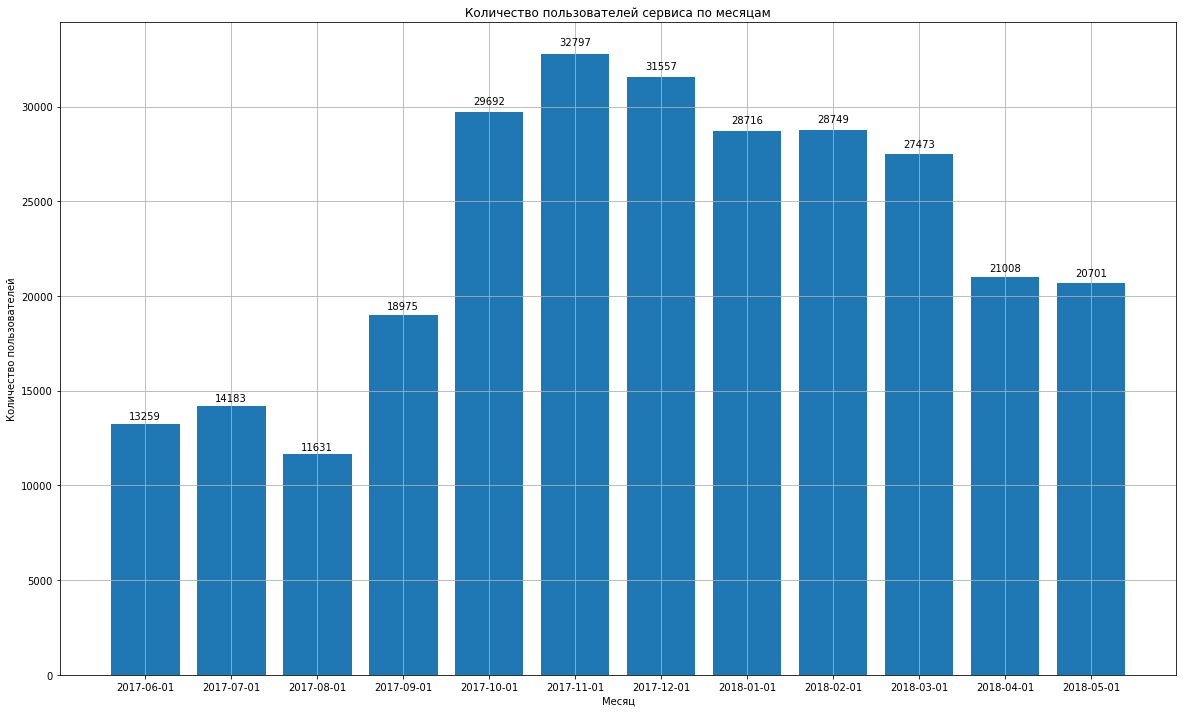

In [34]:
fig, ax = plt.subplots(figsize = (20,12))  

bar_x = [i for i in range(1,len(mau)+1)]
bar_height = mau['uid']
bar_tick_label = mau['month_visit'].dt.strftime('%Y-%m-%d')
bar_label = mau['uid']  

bar_plot = plt.bar(bar_x,bar_height,tick_label=bar_tick_label)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)
    
    
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по месяцам')
plt.grid()
plt.show()

Видим, что в летние месяцы количество посетителей минимально, и минимума достигает в августе. Однако с наступлением осени количество посетителей сайта начинает расти и достигает пика в ноябре. Первые три месяца года тоже обладают высокой аудиторией, но с наступлением теплых дней в апреле аудитория резко падает. То есть на первый взгляд мы видим, что на посещение сайта влияет сезонность. 

Посчитаем среднее количество пользователей в месяц за весь год.

In [35]:
mau_total = mau['uid'].mean()

In [36]:
mau_total

23228.416666666668

Получилось, что в среднем в месяц на сайт заходило около 23228 пользователя.

Теперь посчитаем количетсво пользователей по неделям.

In [37]:
wau = visits.groupby('week_visit').agg({'uid':'nunique'})

In [38]:
wau = wau.sort_values(by='week_visit').reset_index()

In [39]:
wau.head(10)

week_visit   uid
0 2017-06-01  4082
1 2017-06-08  3311
2 2017-06-15  2844
3 2017-06-22  3079
4 2017-06-29  3055
5 2017-07-06  3563
6 2017-07-13  4790
7 2017-07-20  2978
8 2017-07-27  2505
9 2017-08-03  2343

Построим график с количеством пользователей по неделям.

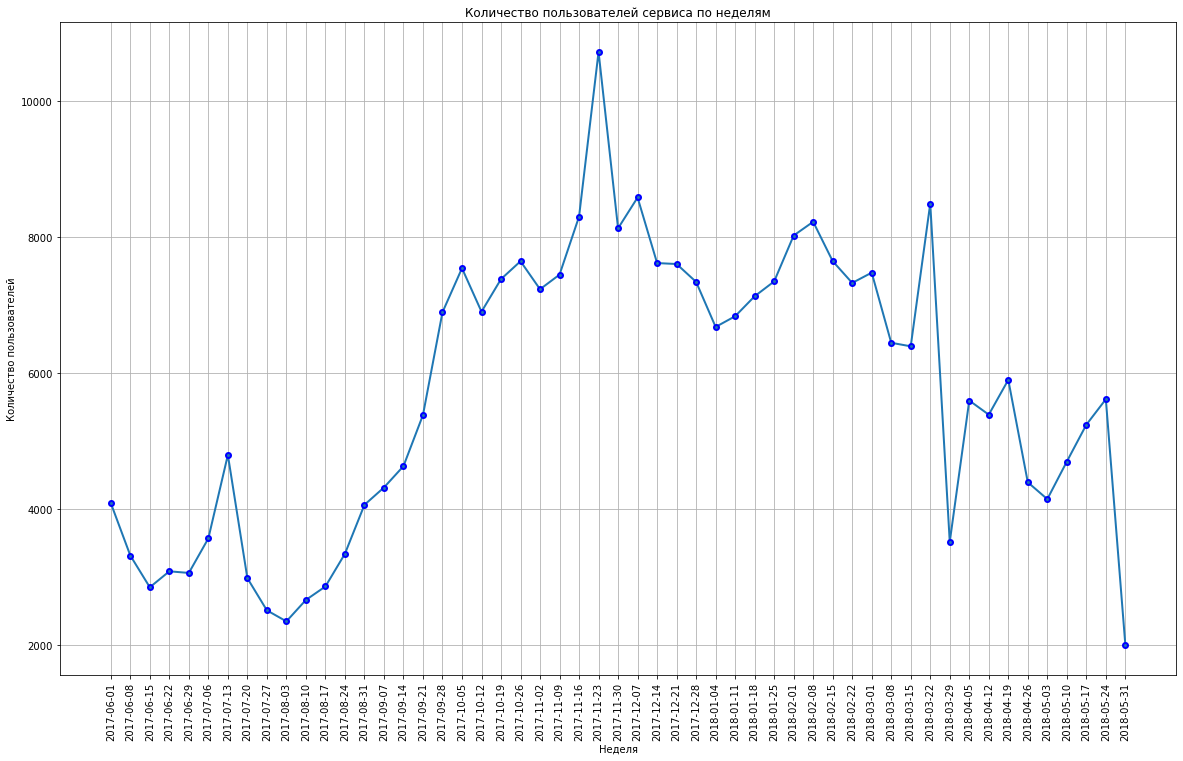

In [40]:
x = wau['week_visit'].dt.strftime('%Y-%m-%d')
y = wau['uid']

plt.figure(figsize=(20, 12))
plt.plot(x, y, 'o-', lw=2, mec='b', mew=2, ms=5)

plt.grid()
plt.xlabel('Неделя')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по неделям')
plt.xticks(rotation=90)
plt.show()

Также как и на предыдущем графике видим сезоннось - летом количество пользователей практически в 2 раза ниже, чем в осенне-зимние месяцы. Самый пик количества посетителей наблюдается за неделю 2017-11-23. Так как пик значительно отличается от остальных недель в осенне-зимние месяцы, есть вероятность, что в эту неделю проводились маркетинговые активности. Также видим пик летом за неделю 2017-07-13, тут тоже могли быть маркетинговые активности. Также наблюдается спад посетителей в январские и майские праздники.  Еще стот отметить резкое падение количества посетителей за неделю 2018-03-29. А на предыдущей неделе наблюдается пик. Так как разница между этими двумя неделями больше, чем в 2 раза, то есть вероятность, что здесь был какой-то технический сбой в поставке данных. В дальнейшем стоит подробнее изучить аномальные пики и падения.

Интересная деталь - питон разбил недели не начиная с понедельника, а начиная с четверга, так как в четверг было 1 июня 2017. И 31 мая 2018 оказался тоже четвергом и в этой неделе получился всего один день, поэтому и пользователей в эту неделю получилось меньше всего.

Теперь посчитаем среднее количество посетителей в неделю за имеющийся период.

In [41]:
wau_total = wau['uid'].mean()

In [42]:
wau_total

5724.415094339623

Среднее количество посетителей в неделю получилось 5724, это в 4 раза меньше среднего количества посетителей в месяц.

Посмотрим теперь на количество пользователей в разбивке по дням.

In [43]:
dau = visits.groupby('date_visit').agg({'uid':'nunique'})

In [44]:
dau = dau.sort_values(by = 'date_visit').reset_index()

In [45]:
dau.head()

date_visit  uid
0 2017-06-01  605
1 2017-06-02  608
2 2017-06-03  445
3 2017-06-04  476
4 2017-06-05  820

In [46]:
dau.describe()

uid
count   364.000000
mean    907.991758
std     370.513838
min       1.000000
25%     594.000000
50%     921.000000
75%    1173.000000
max    3319.000000

In [47]:
dau_total = dau['uid'].mean()

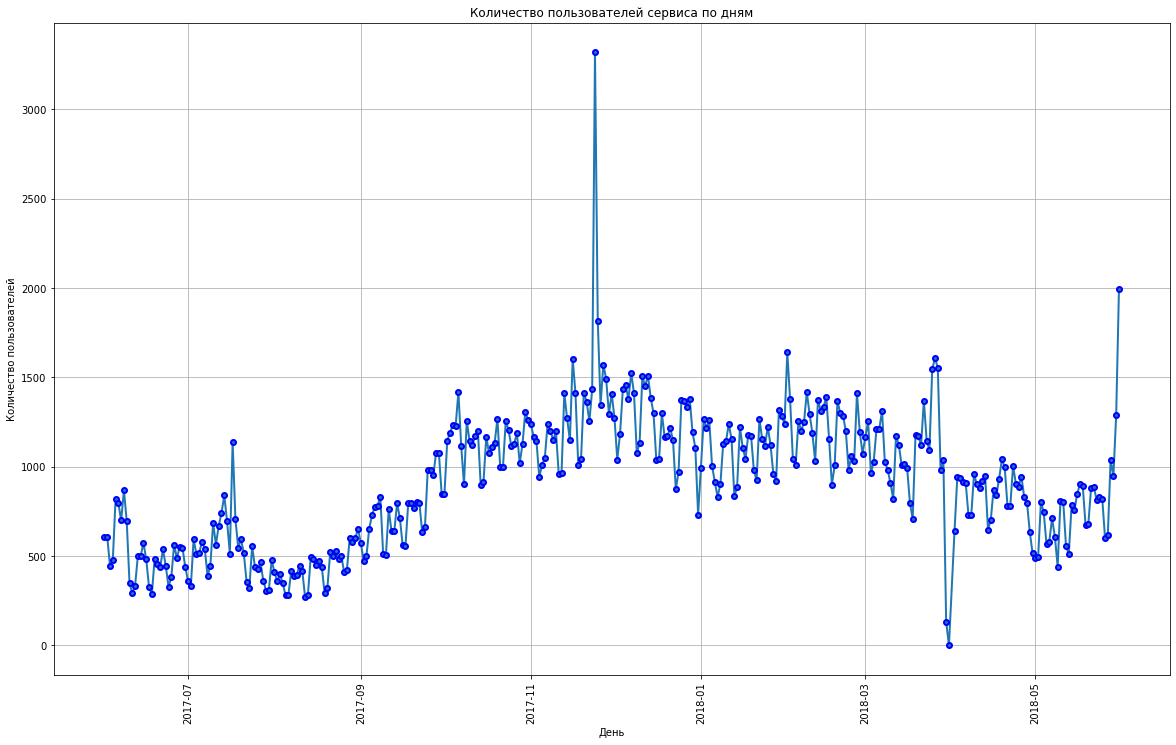

In [48]:
x = dau['date_visit']
y = dau['uid']

plt.figure(figsize=(20, 12))
plt.plot(x, y, 'o-', lw=2, mec='b', mew=2, ms=5)


plt.xlabel('День')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по дням')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Для дневных данных заметна зашумленность, так как разброс между соседними днями бывает достаточно существенен. Особенно это различие заметно между буднями и выходными. 

Опять видим пик в ноябре, который случился в один день и достиг 3319 пользователей за день, тогда как в соседние дни количество пользователей было в районе 1500. Есть падение в марте, где минимум достиг значения 1, что выглядит невероятным, значит скорей всего это был либо технический сбой в этот день при записи данных, либо сайт мог не работать, либо ошибка при загрузке данных в файл для уже текущего анализа. Но скорей всего это первый вариант. Еще выделяется пик в последние дни мая. Скорей всего там были маркетинговые активности, или может сбой в сборе данных. 

Среднее значение пользоваталей в день за весь период получилось 908, а медиана - 921. 

Рассчитаем sticky factor для месяца и для недели.

In [49]:
dau_total / mau_total * 100

3.908969652437603

In [50]:
dau_total / wau_total * 100

15.861738592989047

Видим, что месячный sticky factor составляет почти 4%. Это значит, что старые пользователи на сайте почти не задерживаются и в основном каждый день приходят только новые пользователи. 

Тоже самое видим и по недельному sticky factor, минимальное значение которого составляет 14,3%, а в нашем случае - всего лишь 15,9%.

#### Количество пользователей сервиса в день, неделю, месяц в разбивке по платформам <a id="users_by_platform"></a>

Теперь посмотрим метрики в разбивке по платформам. Для этого сначала, посмотрим, какие платформы у нас есть.

In [51]:
visits.groupby('device')['uid'].count()

device
desktop    262567
touch       96833
Name: uid, dtype: int64

В данных всего две платформы: настольные компьютеры и мобильные устройства. Посещений с компьютеров больше, чем с мобильных устройств. Посчитаем DAU, WAU и MAU в разбивке по платформам и сравним их друг с другом.

In [52]:
mau_platform = visits.pivot_table(index='month_visit', columns='device', values='uid', aggfunc='nunique')

In [53]:
mau_platform = mau_platform.sort_values(by='month_visit').reset_index()

In [54]:
mau_platform

device month_visit  desktop  touch
0       2017-06-01     9761   3655
1       2017-07-01    10145   4223
2       2017-08-01     8611   3132
3       2017-09-01    13509   5679
4       2017-10-01    21286   8856
5       2017-11-01    24439   8913
6       2017-12-01    23294   8785
7       2018-01-01    20350   8741
8       2018-02-01    20574   8590
9       2018-03-01    19574   8303
10      2018-04-01    14844   6387
11      2018-05-01    14312   6647

In [55]:
mau_platform.describe()

device       desktop        touch
count      12.000000    12.000000
mean    16724.916667  6825.916667
std      5533.916769  2201.062903
min      8611.000000  3132.000000
25%     12668.000000  5315.000000
50%     17209.000000  7475.000000
75%     20752.000000  8752.000000
max     24439.000000  8913.000000

Среднее количество пользователей в месяц на платформе desctop составило 16725 пользователей в месяц, а медиана - 17209. Среднее количество пользователей на мобильных устройствах составило 6826 пользователей в месяц, а медиана - 7475. Месячных пользователей на компьютерах в 2,3 раза больше, чем на мобильных устройствах.

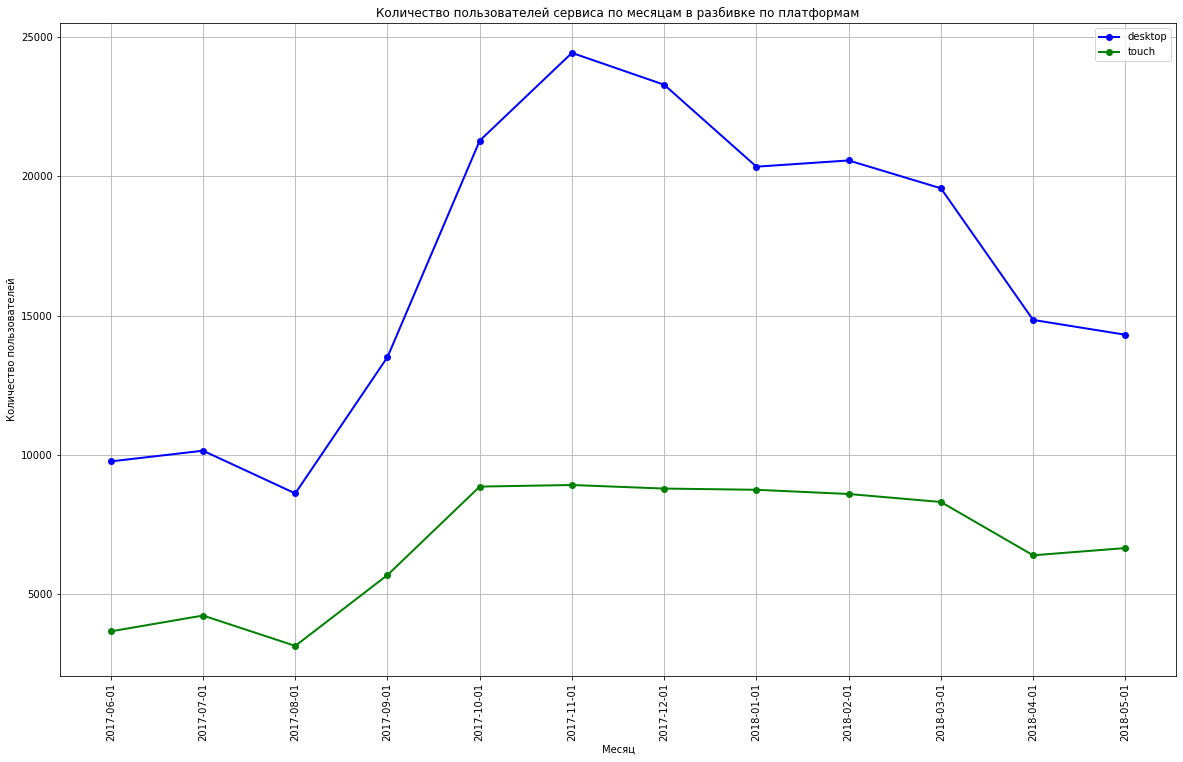

In [56]:
x = mau_platform['month_visit'].astype(str)
y1 = mau_platform['desktop']
y2 = mau_platform['touch']

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mec='b', mew=2, ms=5, label='desktop')
plt.plot(x, y2, 'o-g', lw=2, mec='g', mew=2, ms=5, label='touch')


plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по месяцам в разбивке по платформам')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

На обеих платформах выраженна сезонность. Август самый низкий месяц на обеих платформа. С октября по март на мобильных устройствах количество пользователей практически не меняется и колеблется в промежутке от 8300 до 8900 пользователей в месяц. На компьютерах самый высокий месяц - ноябрь, но в этот месяц был один аномально высокий день, и получается он был только на одной платформе. 

Посмотрим теперь недельную аудиторию в разбивке по платформам.

In [57]:
wau_platform = visits.pivot_table(index='week_visit', columns='device', values='uid', aggfunc='nunique')

In [58]:
wau_platform = wau_platform.sort_values(by='week_visit').reset_index()

In [59]:
wau_platform.head()

device week_visit  desktop  touch
0      2017-06-01     3015   1110
1      2017-06-08     2431    899
2      2017-06-15     2168    693
3      2017-06-22     2231    868
4      2017-06-29     2233    847

In [60]:
wau_platform.describe()

device      desktop        touch
count     53.000000    53.000000
mean    4135.754717  1637.264151
std     1540.286623   600.438466
min     1361.000000   586.000000
25%     2932.000000  1110.000000
50%     4162.000000  1805.000000
75%     5403.000000  2138.000000
max     8131.000000  2778.000000

Среднее количество пользователей в месяц на платформе desctop составило 4136 пользователей в месяц, а медиана - 4162. Среднее количество пользователей на мобильных устройствах составило 1637 пользователей в месяц, а медиана - 1805. Недельных пользователей на компьютерах в 2,3 раза больше, чем на мобильных устройствах.

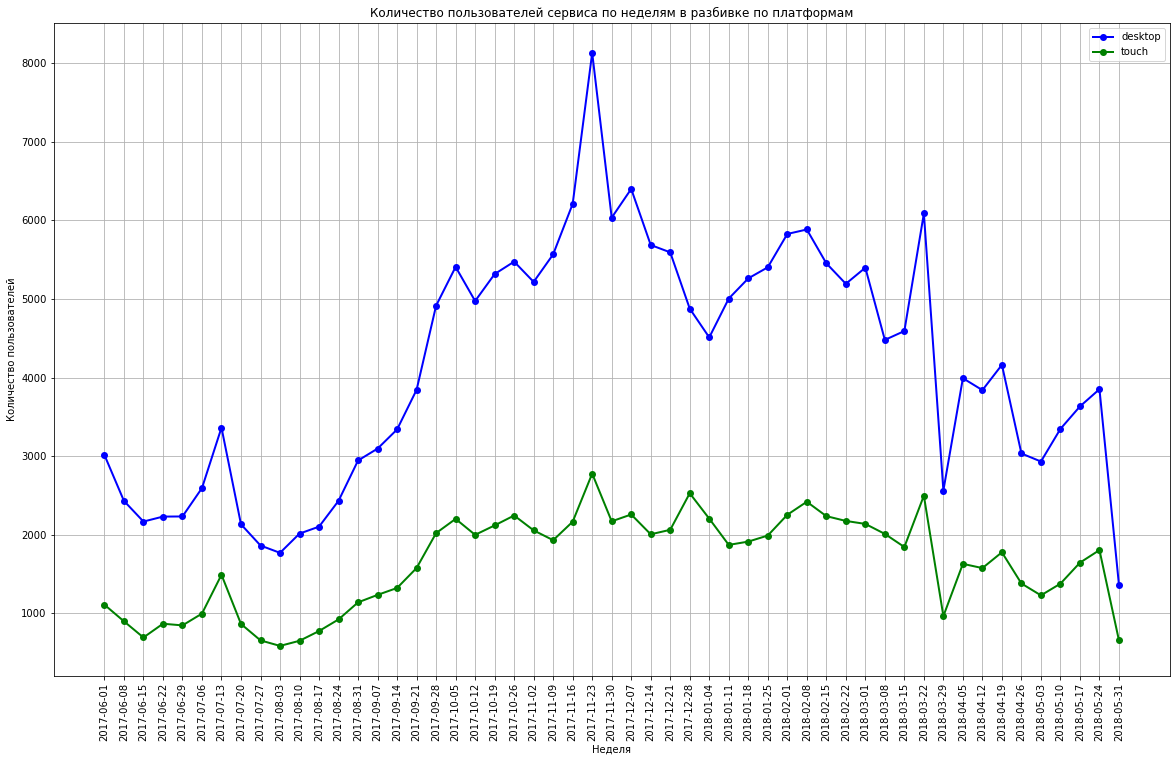

In [61]:
x = wau_platform['week_visit'].astype(str)
y1 = wau_platform['desktop']
y2 = wau_platform['touch']

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mec='b', mew=2, ms=5, label='desktop')
plt.plot(x, y2, 'o-g', lw=2, mec='g', mew=2, ms=5, label='touch')


plt.xlabel('Неделя')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по неделям в разбивке по платформам')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

В целом графики пользователей по неделям в разбивке по платформам практически идентичны по поведению. Неожиданно пик в ноябре есть на обеих платформах, хотя этого не было заметно на месячных данных. На январских праздниках на плафтформе desctop наблюдается сильное падение аудитории, тогда как падение на мобильных устройствах не настолько существенно относительно других недель, в неделю перед новым годом даже пик аудитории наблюдается. 

Посмотрим теперь дневные данные.

In [62]:
dau_platform = visits.pivot_table(index='date_visit', columns='device', values='uid', aggfunc='nunique')

In [63]:
dau_platform = dau_platform.sort_values(by='date_visit').reset_index()

In [64]:
dau_platform.head()

device date_visit  desktop  touch
0      2017-06-01    455.0  153.0
1      2017-06-02    458.0  152.0
2      2017-06-03    307.0  139.0
3      2017-06-04    326.0  153.0
4      2017-06-05    631.0  195.0

In [65]:
dau_platform.describe()

device      desktop       touch
count    364.000000  363.000000
mean     659.244505  252.873278
std      284.771685  102.042757
min        1.000000   46.000000
25%      421.750000  173.500000
50%      649.000000  264.000000
75%      877.000000  322.000000
max     2605.000000  777.000000

Среднее количество пользователей в месяц на платформе desctop составило 659 пользователей в месяц, а медиана - 642. Среднее количество пользователей на мобильных устройствах составило 253 пользователей в месяц, а медиана - 264. Дневных пользователей на компьютерах в 2,5 раза больше, чем на мобильных устройствах.

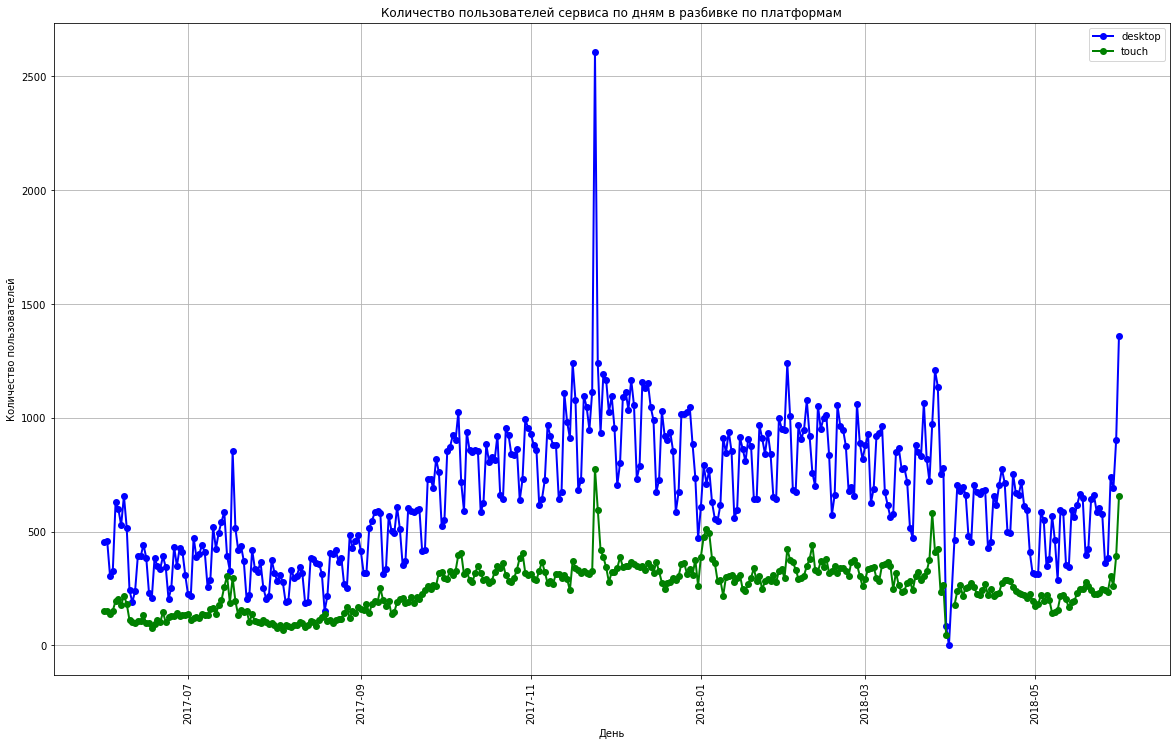

In [66]:
x = dau_platform['date_visit']
y1 = dau_platform['desktop']
y2 = dau_platform['touch']

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mec='b', mew=2, ms=5, label='desktop')
plt.plot(x, y2, 'o-g', lw=2, mec='g', mew=2, ms=5, label='touch')


plt.xlabel('День')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по дням в разбивке по платформам')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

В целом графики очень похожи. Из необычного отметим, что на мобильных устройствах наблюдается рост в январские праздники.

Рассчитаем sticky factor для месяца и недели в разбивке по платформам.

In [67]:
dau_platform.mean() / mau_platform.mean() * 100

<ipython-input-67-5ef2c8116a82>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dau_platform.mean() / mau_platform.mean() * 100


device
desktop    3.941691
touch      3.704605
dtype: float64

In [68]:
dau_platform.mean() / wau_platform.mean() * 100

<ipython-input-68-fac6ad1d96f3>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dau_platform.mean() / wau_platform.mean() * 100


device
desktop    15.940126
touch      15.444867
dtype: float64

Sticky factor низкий на обеих платформах, но на мобильных устройствах он ниже, чем на компьютерах. Получается, что на мобильных устройствах аудитория практически всегда новая, старая почти не задерживается. На компьютерах чуть лучше, но все равно очень низкий показатель.

#### Количество пользователей сервиса в день, неделю, месяц в разбивке по источиника трафика <a id="users_by_source"></a>

Теперь посмотрим метрики в разбивке по источникам трафика. Для этого сначала, посмотрим, какие id источников трафика у нас есть.

In [69]:
visits.groupby('source_id')['uid'].count()

source_id
1      34121
2      47626
3      85610
4     101794
5      66905
6          6
7         36
9      13277
10     10025
Name: uid, dtype: int64

Итак, у нас 9 источников трафика. Больше всего посещений на 4-м, меньше всего - на 6-м. Сделаем сводную таблицу по источникам трафика и посмотрим аудиторные метрики по месяцам, неделям и дням.

In [70]:
mau_source = visits.pivot_table(index='month_visit', columns='source_id', values='uid', aggfunc='nunique')

In [71]:
mau_source = mau_source.sort_values(by='month_visit').reset_index()

In [72]:
mau_source

source_id month_visit       1       2        3        4       5    6    7  \
0          2017-06-01   972.0  1532.0   4226.0   3636.0  2903.0  NaN  2.0   
1          2017-07-01  1047.0  1775.0   4068.0   4114.0  3727.0  1.0  2.0   
2          2017-08-01   794.0  1275.0   3416.0   3129.0  3146.0  1.0  1.0   
3          2017-09-01  1395.0  2130.0   5825.0   5377.0  4932.0  1.0  3.0   
4          2017-10-01  2170.0  3350.0   8533.0   9514.0  7525.0  NaN  5.0   
5          2017-11-01  2790.0  4193.0  10190.0  11228.0  6505.0  1.0  1.0   
6          2017-12-01  2735.0  3702.0   9194.0  11787.0  6222.0  1.0  9.0   
7          2018-01-01  2142.0  3168.0   8529.0  10247.0  5738.0  1.0  4.0   
8          2018-02-01  2121.0  3159.0   8686.0   9756.0  5952.0  NaN  3.0   
9          2018-03-01  2289.0  3353.0   7623.0   9808.0  4613.0  NaN  1.0   
10         2018-04-01  1614.0  2424.0   5473.0   7317.0  4914.0  NaN  1.0   
11         2018-05-01  1756.0  2964.0   5343.0   7275.0  4038.0  NaN  2.0   

source_id       9      10  
0           753.0   427.0  
1           562.0   316.0  
2           613.0   244.0  
3           781.0   502.0  
4          1043.0   926.0  
5          1488.0   888.0  
6          1234.0   621.0  
7          1059.0   925.0  
8          1036.0  1088.0  
9          1772.0  1167.0  
10          750.0   603.0  
11          753.0   777.0

Заменим пустные значения на 0 для правильного расчета среднего.

In [73]:
mau_source = mau_source.fillna(0)

In [74]:
mau_source

source_id month_visit       1       2        3        4       5    6    7  \
0          2017-06-01   972.0  1532.0   4226.0   3636.0  2903.0  0.0  2.0   
1          2017-07-01  1047.0  1775.0   4068.0   4114.0  3727.0  1.0  2.0   
2          2017-08-01   794.0  1275.0   3416.0   3129.0  3146.0  1.0  1.0   
3          2017-09-01  1395.0  2130.0   5825.0   5377.0  4932.0  1.0  3.0   
4          2017-10-01  2170.0  3350.0   8533.0   9514.0  7525.0  0.0  5.0   
5          2017-11-01  2790.0  4193.0  10190.0  11228.0  6505.0  1.0  1.0   
6          2017-12-01  2735.0  3702.0   9194.0  11787.0  6222.0  1.0  9.0   
7          2018-01-01  2142.0  3168.0   8529.0  10247.0  5738.0  1.0  4.0   
8          2018-02-01  2121.0  3159.0   8686.0   9756.0  5952.0  0.0  3.0   
9          2018-03-01  2289.0  3353.0   7623.0   9808.0  4613.0  0.0  1.0   
10         2018-04-01  1614.0  2424.0   5473.0   7317.0  4914.0  0.0  1.0   
11         2018-05-01  1756.0  2964.0   5343.0   7275.0  4038.0  0.0  2.0   

source_id       9      10  
0           753.0   427.0  
1           562.0   316.0  
2           613.0   244.0  
3           781.0   502.0  
4          1043.0   926.0  
5          1488.0   888.0  
6          1234.0   621.0  
7          1059.0   925.0  
8          1036.0  1088.0  
9          1772.0  1167.0  
10          750.0   603.0  
11          753.0   777.0

In [75]:
mau_source.describe()

source_id           1            2             3             4            5   \
count        12.000000    12.000000     12.000000     12.000000    12.000000   
mean       1818.750000  2752.083333   6758.833333   7765.666667  5017.916667   
std         668.194191   914.547127   2292.382914   3068.022589  1418.177990   
min         794.000000  1275.000000   3416.000000   3129.000000  2903.000000   
25%        1308.000000  2041.250000   5063.750000   5061.250000  3960.250000   
50%        1938.500000  3061.500000   6724.000000   8415.500000  4923.000000   
75%        2199.750000  3350.750000   8571.250000   9917.750000  6019.500000   
max        2790.000000  4193.000000  10190.000000  11787.000000  7525.000000   

source_id         6          7            9            10  
count      12.000000  12.000000    12.000000    12.000000  
mean        0.500000   2.833333   987.000000   707.000000  
std         0.522233   2.329000   365.261301   300.876598  
min         0.000000   1.000000   562.000000   244.000000  
25%         0.000000   1.000000   752.250000   483.250000  
50%         0.500000   2.000000   908.500000   699.000000  
75%         1.000000   3.250000  1102.750000   925.250000  
max         1.000000   9.000000  1772.000000  1167.000000

Все источники отличаются по количеству посетителей между собой. На первом месте по среднему количеству посетителей 4-й источник трафика с 7766 посетителей в месяц, на втором месте - 3-й источник трафика с 6759 посетителей в месяц, на третьем месте 5-й источник трафика с 5018 посетителей в месяц. Медиана только на 4-м источнике трафика сильно отличается от среднего, но на этом источнике и больше всего посетителей, но видимо и наиболее выражены перепады количества посетителей по месяцам. Посмотрим на графиках как себя ведут посетители в разбивке по источникам трафика. 6 и 7 источники посмотрим отдельно, так как там совсем мало данных.

Проверим, за какие источники трафика платили деньги, чтобы не гадать, какие из них платные, а какие - нет.

In [76]:
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Итак, бесплатными у нас являются 6 и 7 источники трафика, но на них практически нет пользователей.

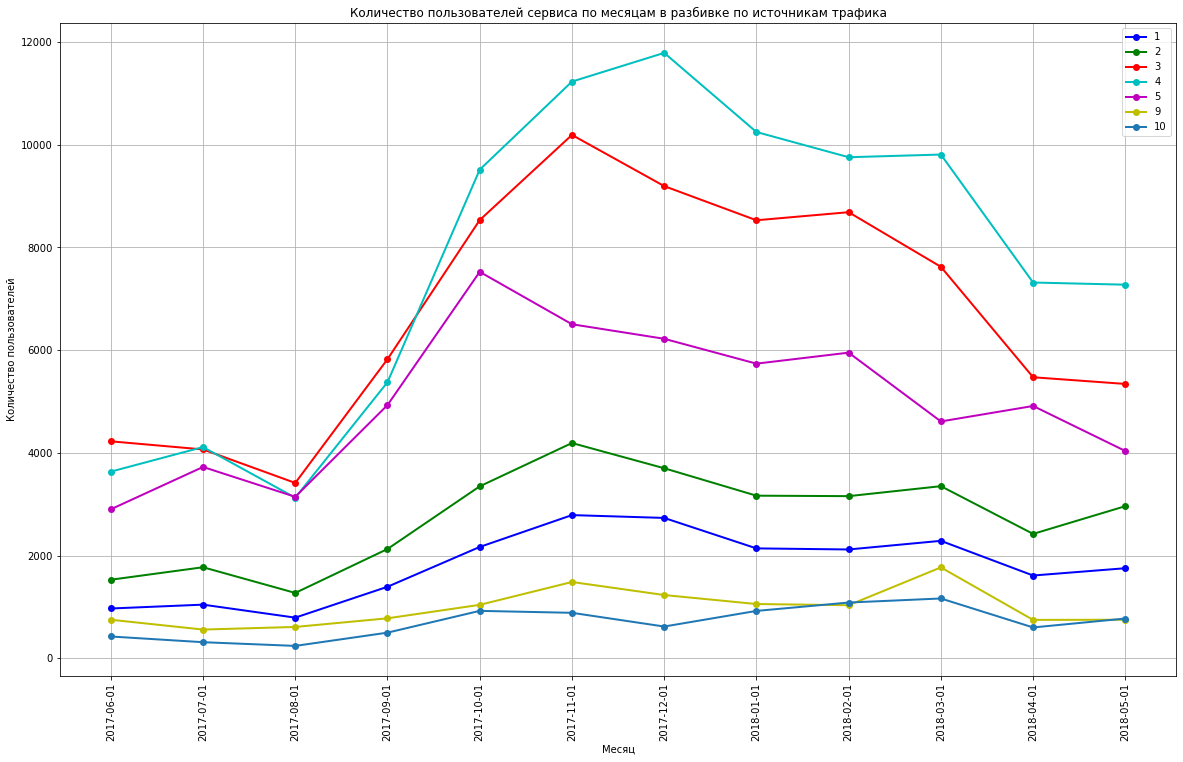

In [77]:
x = mau_source['month_visit'].astype(str)
y1 = mau_source[1]
y2 = mau_source[2]
y3 = mau_source[3]
y4 = mau_source[4]
y5 = mau_source[5]
y9 = mau_source[9]
y10 = mau_source[10]

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mec='b', mew=2, ms=5, label='1')
plt.plot(x, y2, 'o-g', lw=2, mec='g', mew=2, ms=5, label='2')
plt.plot(x, y3, 'o-r', lw=2, mec='r', mew=2, ms=5, label='3')
plt.plot(x, y4, 'o-c', lw=2, mec='c', mew=2, ms=5, label='4')
plt.plot(x, y5, 'o-m', lw=2, mec='m', mew=2, ms=5, label='5')
plt.plot(x, y9, 'o-y', lw=2, mec='y', mew=2, ms=5, label='9')
plt.plot(x, y10, 'o-', lw=2, mew=2, ms=5, label='10')


plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по месяцам в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

Видим, что сезонность наблюдается на каждом источнике трафика: летние месяцы самые низкие, осенне-зимние - самые высокие. Однако пики максимальных значений различаются у разных источников. На 5-м и 10-м источниках пик приходится на октябрь 2017, на 3-м, 2-м и 9-м источниках - пик приходится на ноябрь 2017. На 4-м источнике пик приходится на декабрь 2017. На 1-м примерно одинаковое количество посетителей в ноябре и декабре. Так же отметим, что на 9-м источнике трафика самый высокий пик приходится на март 2018. 

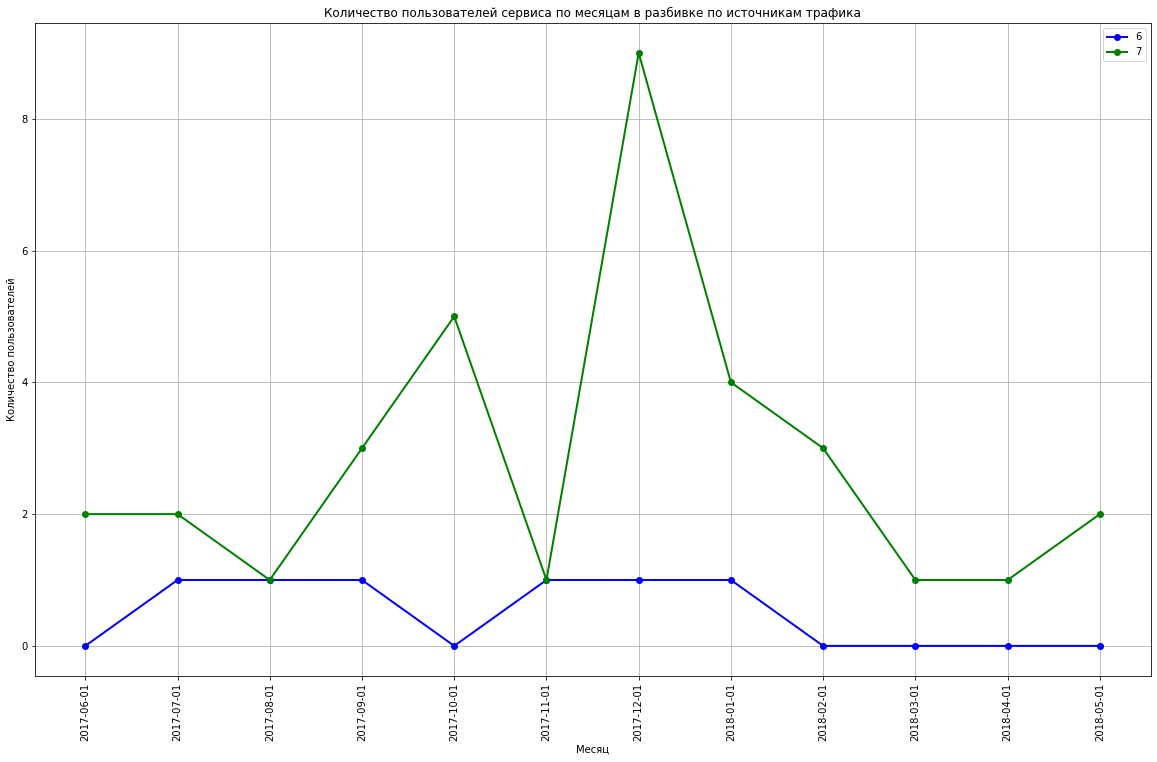

In [78]:
x = mau_source['month_visit'].astype(str)
y6 = mau_source[6]
y7 = mau_source[7]


plt.figure(figsize=(20, 12))
plt.plot(x, y6, 'o-b', lw=2, mec='b', mew=2, ms=5, label='6')
plt.plot(x, y7, 'o-g', lw=2, mec='g', mew=2, ms=5, label='7')


plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по месяцам в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

На 6-м и 7-м источниках трафика значений очень мало, так что тут нельзя говорить о каких-то закономерностях. При рассмотрении недельных и дневных показателей эти источники просто не будем показывать, так как все равно посетителей по ним почти нет.

Теперь посмотрим источники трафика в разбивке по неделям.

In [79]:
wau_source = visits.pivot_table(index='week_visit', columns='source_id', values='uid', aggfunc='nunique')

In [80]:
wau_source = wau_source.sort_values(by='week_visit').reset_index()

In [81]:
wau_source = wau_source.fillna(0)

In [82]:
wau_source.head()

source_id week_visit      1      2       3       4      5    6    7      9  \
0         2017-06-01  341.0  519.0  1323.0  1004.0  818.0  0.0  1.0  201.0   
1         2017-06-08  255.0  430.0  1074.0   894.0  613.0  0.0  0.0  132.0   
2         2017-06-15  220.0  356.0   846.0   878.0  448.0  0.0  1.0  161.0   
3         2017-06-22  201.0  372.0   825.0   753.0  826.0  0.0  0.0  204.0   
4         2017-06-29  238.0  370.0   854.0   883.0  659.0  1.0  1.0  193.0   

source_id     10  
0          173.0  
1          107.0  
2           79.0  
3           66.0  
4           71.0

In [83]:
wau_source.describe()

source_id           1            2            3            4            5   \
count        53.000000    53.000000    53.000000    53.000000    53.000000   
mean        464.698113   716.358491  1565.509434  1830.622642  1168.018868   
std         195.726711   261.211828   602.922869   780.450763   405.228639   
min         165.000000   294.000000   394.000000   498.000000   235.000000   
25%         280.000000   519.000000  1014.000000  1008.000000   843.000000   
50%         494.000000   721.000000  1478.000000  1971.000000  1116.000000   
75%         572.000000   881.000000  2032.000000  2479.000000  1417.000000   
max        1158.000000  1608.000000  3311.000000  3143.000000  2035.000000   

source_id         6          7            9           10  
count      53.000000  53.000000    53.000000   53.000000  
mean        0.113208   0.679245   238.339623  166.509434  
std         0.319878   1.033545   161.400951   83.848449  
min         0.000000   0.000000    62.000000   30.000000  
25%         0.000000   0.000000   168.000000  108.000000  
50%         0.000000   0.000000   204.000000  151.000000  
75%         0.000000   1.000000   253.000000  218.000000  
max         1.000000   6.000000  1108.000000  382.000000

Топ 3 количества пользователей в разбивке по источникам трафика тот же, что и по месячным показателям. На первом месте 4-й источник трафика со средним количеством посетителей в неделю составляющим 1831. На втором месте 3-й источник трафика со средним 1566 посетителей и на третьем месте 5-й источник трафика со средним 1168 посетителей в неделю. Медианы на всех источниках трафика не очень сильно отличаются от среднего. 

Построим графики.

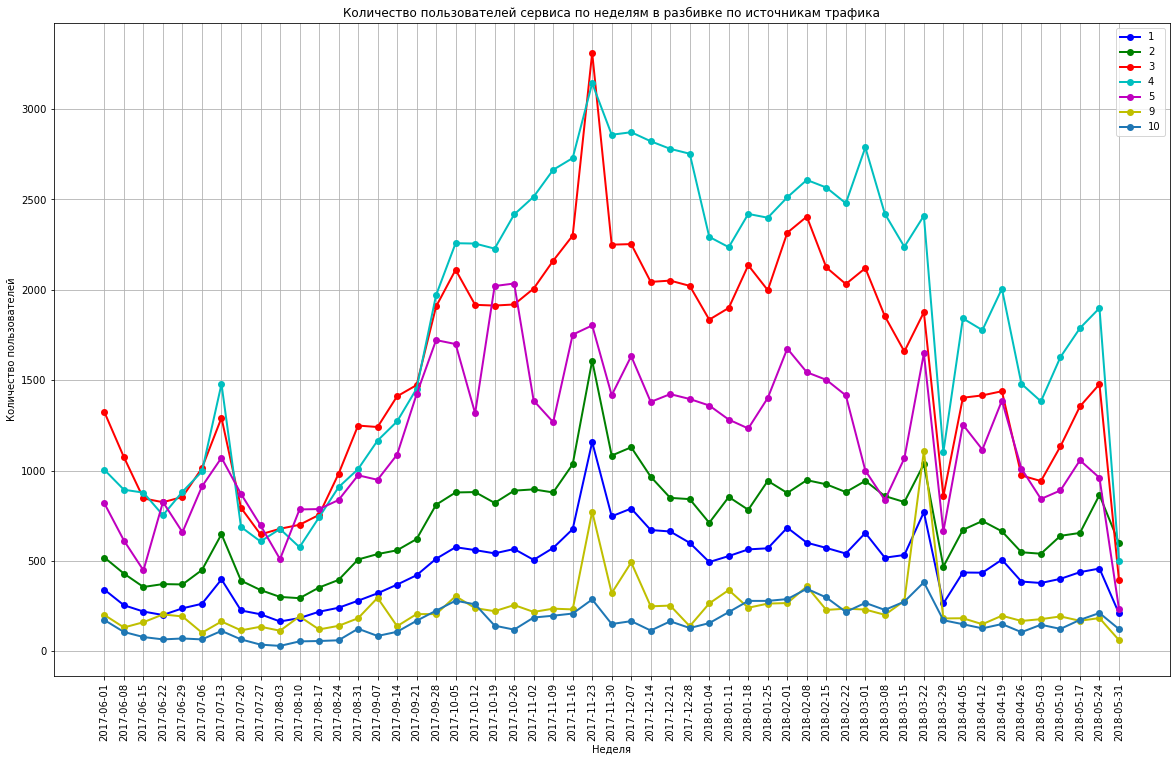

In [84]:
x = wau_source['week_visit'].astype(str)
y1 = wau_source[1]
y2 = wau_source[2]
y3 = wau_source[3]
y4 = wau_source[4]
y5 = wau_source[5]
y9 = wau_source[9]
y10 = wau_source[10]

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mec='b', mew=2, ms=5, label='1')
plt.plot(x, y2, 'o-g', lw=2, mec='g', mew=2, ms=5, label='2')
plt.plot(x, y3, 'o-r', lw=2, mec='r', mew=2, ms=5, label='3')
plt.plot(x, y4, 'o-c', lw=2, mec='c', mew=2, ms=5, label='4')
plt.plot(x, y5, 'o-m', lw=2, mec='m', mew=2, ms=5, label='5')
plt.plot(x, y9, 'o-y', lw=2, mec='y', mew=2, ms=5, label='9')
plt.plot(x, y10, 'o-', lw=2, mew=2, ms=5, label='10')


plt.xlabel('Неделя')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по неделям в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

Опять видим сезонность, она выраженна на всех источниках трафика. Пик на неделе 2017-11-23 есть на всех источниках трафика, но сильнее всего заметен на 3-м источнике. Есть пик на неделе 2017-07-13 на первых пяти истониках трафика. Также падение 2018-03-29 наиболее выражено на первых 5-ти источниках трафика, а на предыдущей неделе 2017-03-22 у всех источников был пик по посетителям, наиболее выражен на 5-м и на 9-м источниках. Также заметно, что в последние недели мая растет аудитория на первых пяти источниках трафика. 

На 4-м иточнике больше всего посетителей и на нем не очень много каких-то искусственных пиков, скорей всего это какой-то органический источник трафика: либо поисковый, либо прямой. 1-й и 2-й источники тоже похожи на органические источники. Но так как на поддержание посетителей все равно нужно выделять средства, то на этих источниках необычные пики встречаются.
По количеству пиков выделяется 5-й источник трафика - на нем либо хорошо срабатывают рекламные активности, либо они проводятся только конкретно для этого источника трафика. 
На 3-м источнике трафика очень хорошо сработала активность в ноябре, так что даже количество посетителей на этом источнике превысило количество посетителей на 4-м источнике трафика. 
На 9-м источнике тоже есть много необычных пиков. На неделе 2018-03-22 количество посетителей на этом источнике побило количество посетитлей на 1-м и 2-м источниках трафика.

Теперь посмотрим данные по дням.

In [85]:
dau_source = visits.pivot_table(index='date_visit', columns='source_id', values='uid', aggfunc='nunique')

In [86]:
dau_source = dau_source.sort_values(by='date_visit').reset_index()

In [87]:
dau_source = dau_source.fillna(0)

In [88]:
dau_source.head()

source_id date_visit     1      2      3      4      5    6    7     9    10
0         2017-06-01  61.0   79.0  182.0  138.0  114.0  0.0  0.0  51.0   9.0
1         2017-06-02  50.0   91.0  179.0  155.0  116.0  0.0  0.0  15.0  21.0
2         2017-06-03  37.0   60.0  123.0  109.0   87.0  0.0  0.0  22.0  19.0
3         2017-06-04  44.0   58.0  140.0  113.0  106.0  0.0  0.0  14.0  18.0
4         2017-06-05  73.0  100.0  264.0  171.0  135.0  0.0  0.0  78.0  33.0

In [89]:
dau_source.describe()

source_id          1           2           3           4           5   \
count      364.000000  364.000000  364.000000  364.000000  364.000000   
mean        80.557692  120.376374  232.225275  274.697802  175.140110   
std         41.810269   59.322702   97.291722  121.486735   65.429874   
min          1.000000    0.000000    0.000000    0.000000    0.000000   
25%         51.000000   79.000000  152.000000  165.750000  127.000000   
50%         79.000000  119.000000  235.000000  294.000000  169.000000   
75%        102.000000  150.250000  302.000000  371.000000  214.250000   
max        483.000000  599.000000  932.000000  716.000000  392.000000   

source_id          6           7           9           10  
count      364.000000  364.000000  364.000000  364.000000  
mean         0.016484    0.098901   36.010989   25.961538  
std          0.127501    0.316835   46.880775   17.897124  
min          0.000000    0.000000    0.000000    0.000000  
25%          0.000000    0.000000    9.000000   13.750000  
50%          0.000000    0.000000   22.000000   22.000000  
75%          0.000000    0.000000   51.250000   34.250000  
max          1.000000    2.000000  555.000000  132.000000

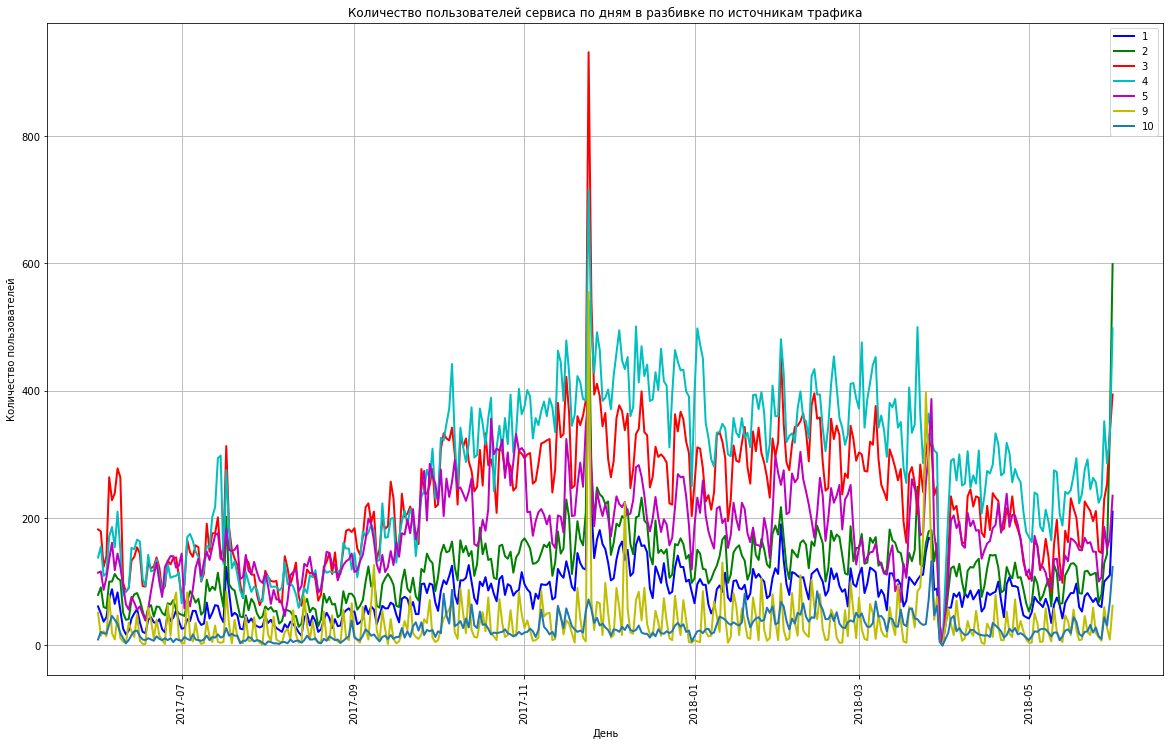

In [90]:
x = dau_source['date_visit']
y1 = dau_source[1]
y2 = dau_source[2]
y3 = dau_source[3]
y4 = dau_source[4]
y5 = dau_source[5]
y9 = dau_source[9]
y10 = dau_source[10]

plt.figure(figsize=(20, 12))
plt.plot(x, y1, '-b', lw=2, mew=2, ms=5, label='1')
plt.plot(x, y2, '-g', lw=2, mew=2, ms=5, label='2')
plt.plot(x, y3, '-r', lw=2, mew=2, ms=5, label='3')
plt.plot(x, y4, '-c', lw=2, mew=2, ms=5, label='4')
plt.plot(x, y5, '-m', lw=2, mew=2, ms=5, label='5')
plt.plot(x, y9, '-y', lw=2, mew=2, ms=5, label='9')
plt.plot(x, y10, '-', lw=2, mew=2, ms=5, label='10')


plt.xlabel('День')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по дням в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

Данные по дням очень сильно зашумлены. Попробуем посмотреть отдельно 3, 4, 5 и 9 источники трафика и отдельно остальные

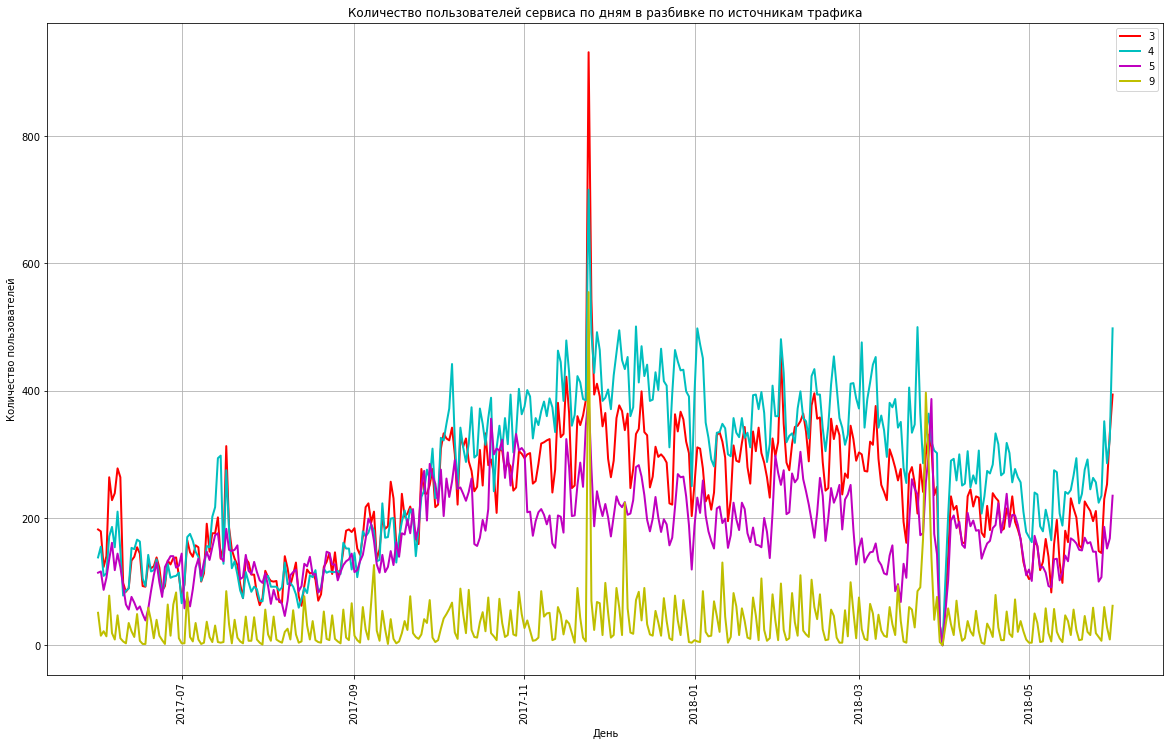

In [91]:
x = dau_source['date_visit']
y3 = dau_source[3]
y4 = dau_source[4]
y5 = dau_source[5]
y9 = dau_source[9]

plt.figure(figsize=(20, 12))

plt.plot(x, y3, '-r', lw=2, mew=2, ms=5, label='3')
plt.plot(x, y4, '-c', lw=2, mew=2, ms=5, label='4')
plt.plot(x, y5, '-m', lw=2, mew=2, ms=5, label='5')
plt.plot(x, y9, '-y', lw=2, mew=2, ms=5, label='9')



plt.xlabel('День')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по дням в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

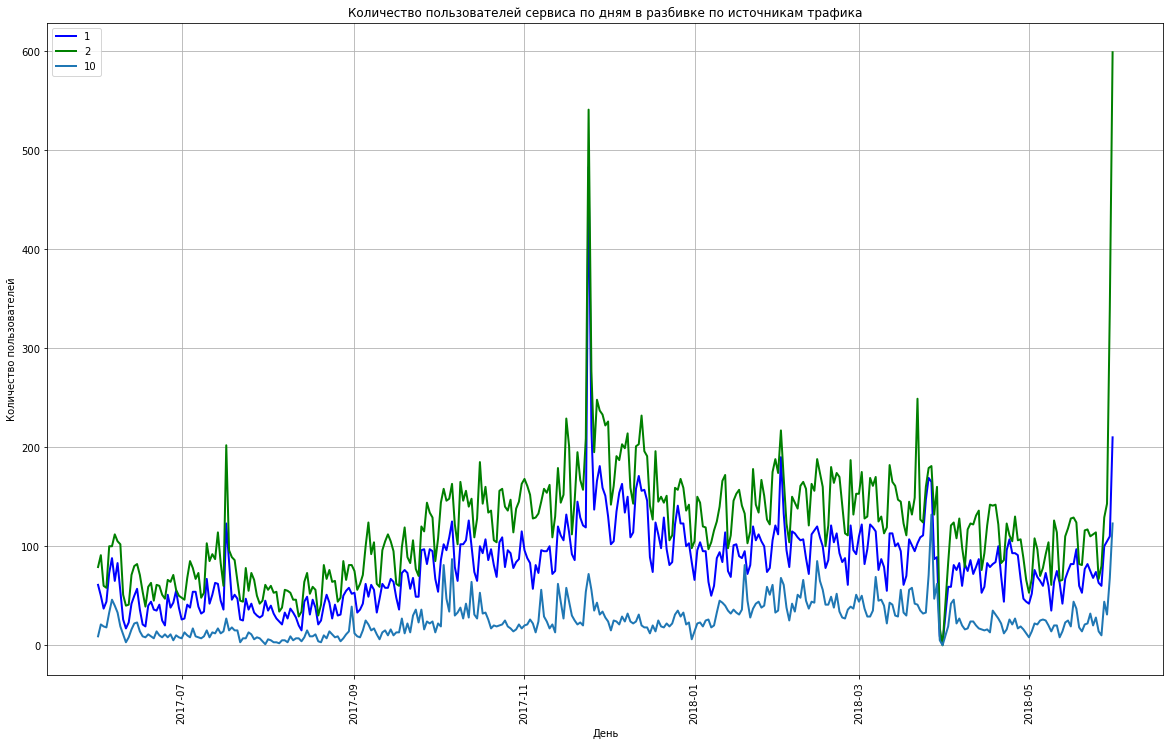

In [92]:
x = dau_source['date_visit']
y1 = dau_source[1]
y2 = dau_source[2]
y10 = dau_source[10]

plt.figure(figsize=(20, 12))
plt.plot(x, y1, '-b', lw=2, mew=2, ms=5, label='1')
plt.plot(x, y2, '-g', lw=2, mew=2, ms=5, label='2')
plt.plot(x, y10, '-', lw=2, mew=2, ms=5, label='10')


plt.xlabel('День')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по дням в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

#### Количество пользователей в неделю в разбивке по платформам и источникам трафика

Посмотрим недельную аудиторию в разбивке по платформам и источникам трафика. Смотрим именно недельную аудиторию, потому что дневная аудитория слишком зашумлена, а месячная аудиториая - слишком усреднена - по ним сложно понять значимость событий.

In [93]:
wau_platform_source = visits.pivot_table(
    index=['device', 'week_visit'], columns='source_id', values='uid', aggfunc='nunique')

In [94]:
wau_platform_source = wau_platform_source.fillna(0).reset_index()

In [95]:
wau_desktop_source = wau_platform_source.query('device == "desktop"')

In [96]:
wau_touch_source = wau_platform_source.query('device == "touch"')

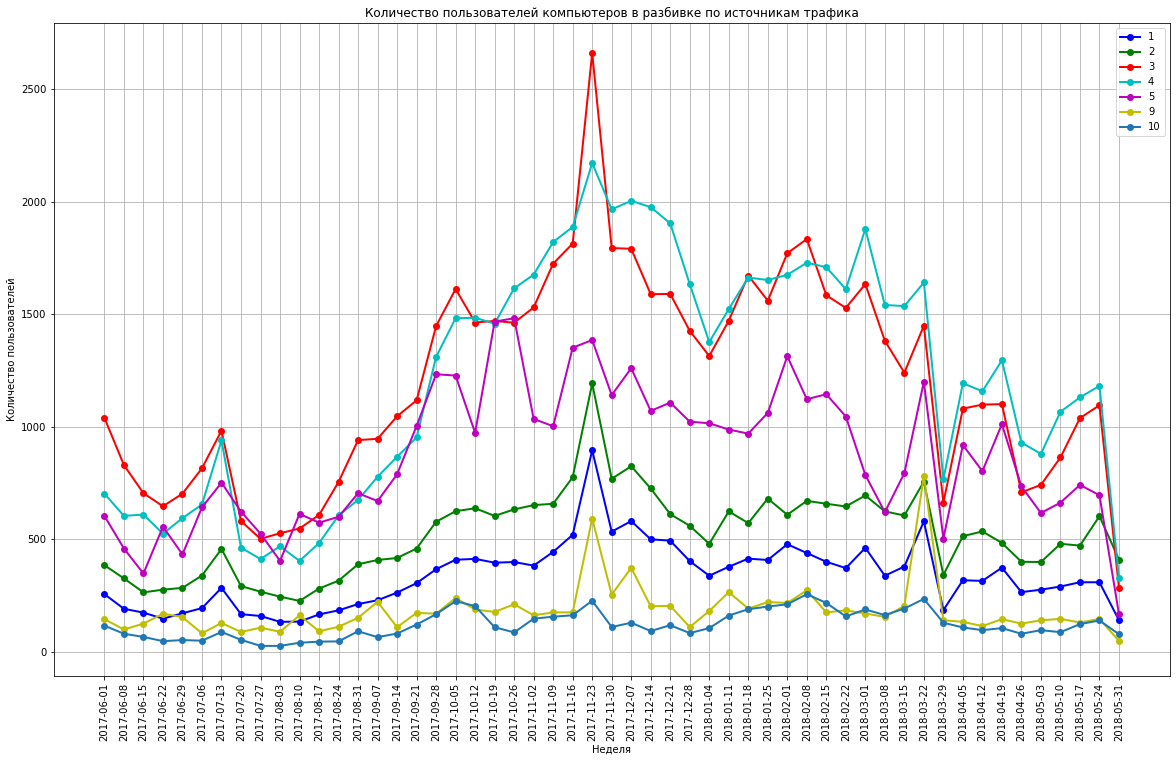

In [97]:
x = wau_desktop_source['week_visit'].astype(str)
y1 = wau_desktop_source[1]
y2 = wau_desktop_source[2]
y3 = wau_desktop_source[3]
y4 = wau_desktop_source[4]
y5 = wau_desktop_source[5]
y9 = wau_desktop_source[9]
y10 = wau_desktop_source[10]

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mec='b', mew=2, ms=5, label='1')
plt.plot(x, y2, 'o-g', lw=2, mec='g', mew=2, ms=5, label='2')
plt.plot(x, y3, 'o-r', lw=2, mec='r', mew=2, ms=5, label='3')
plt.plot(x, y4, 'o-c', lw=2, mec='c', mew=2, ms=5, label='4')
plt.plot(x, y5, 'o-m', lw=2, mec='m', mew=2, ms=5, label='5')
plt.plot(x, y9, 'o-y', lw=2, mec='y', mew=2, ms=5, label='9')
plt.plot(x, y10, 'o-', lw=2, mew=2, ms=5, label='10')


plt.xlabel('Неделя')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей компьютеров в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

На компьютерах 3 и 4 источник трафика очень близки друг к другу. В целом поведение остальных источников похоже на поведение пользователей в общем в разбивке по источникам трафика.

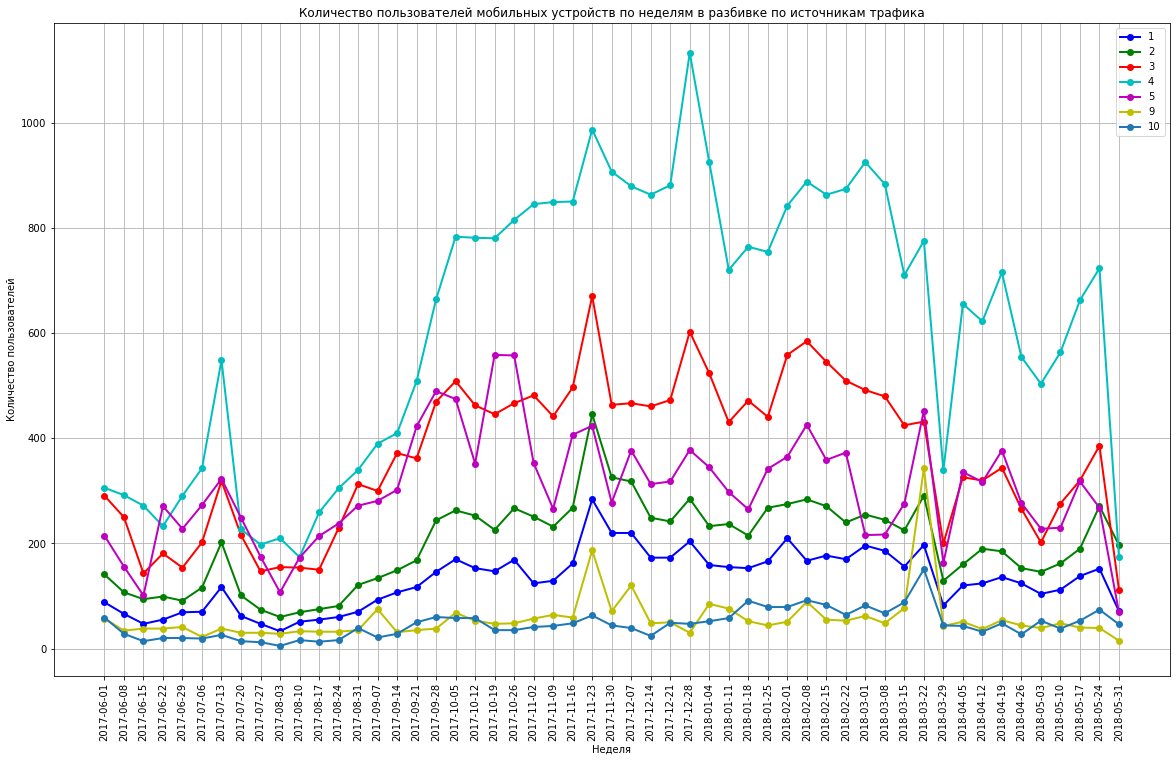

In [98]:
x = wau_touch_source['week_visit'].astype(str)
y1 = wau_touch_source[1]
y2 = wau_touch_source[2]
y3 = wau_touch_source[3]
y4 = wau_touch_source[4]
y5 = wau_touch_source[5]
y9 = wau_touch_source[9]
y10 = wau_touch_source[10]

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mec='b', mew=2, ms=5, label='1')
plt.plot(x, y2, 'o-g', lw=2, mec='g', mew=2, ms=5, label='2')
plt.plot(x, y3, 'o-r', lw=2, mec='r', mew=2, ms=5, label='3')
plt.plot(x, y4, 'o-c', lw=2, mec='c', mew=2, ms=5, label='4')
plt.plot(x, y5, 'o-m', lw=2, mec='m', mew=2, ms=5, label='5')
plt.plot(x, y9, 'o-y', lw=2, mec='y', mew=2, ms=5, label='9')
plt.plot(x, y10, 'o-', lw=2, mew=2, ms=5, label='10')


plt.xlabel('Неделя')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей мобильных устройств по неделям в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

На мобильных устройствах 4-й источник трафика значительно выше количества пользователей на других источниках трафика. Различие заметно с конца сентября. Зато первые 5 месяцев третий и пятый источники трафика идут рядом друг с другом, потом до середины марта 3-й источник трафика выше 5-го, а с середины марта опять идут вровень.

#### Количество сессий в день <a id="sessions"></a>

Теперь посчитаем количество сессий в день в целом и на пользователя.

In [99]:
day_visits = visits.groupby('date_visit')['uid'].count().reset_index()

In [100]:
day_visits.columns = ['date_visit', 'visits']

In [101]:
day_visits.head()

date_visit  visits
0 2017-06-01     664
1 2017-06-02     658
2 2017-06-03     477
3 2017-06-04     510
4 2017-06-05     893

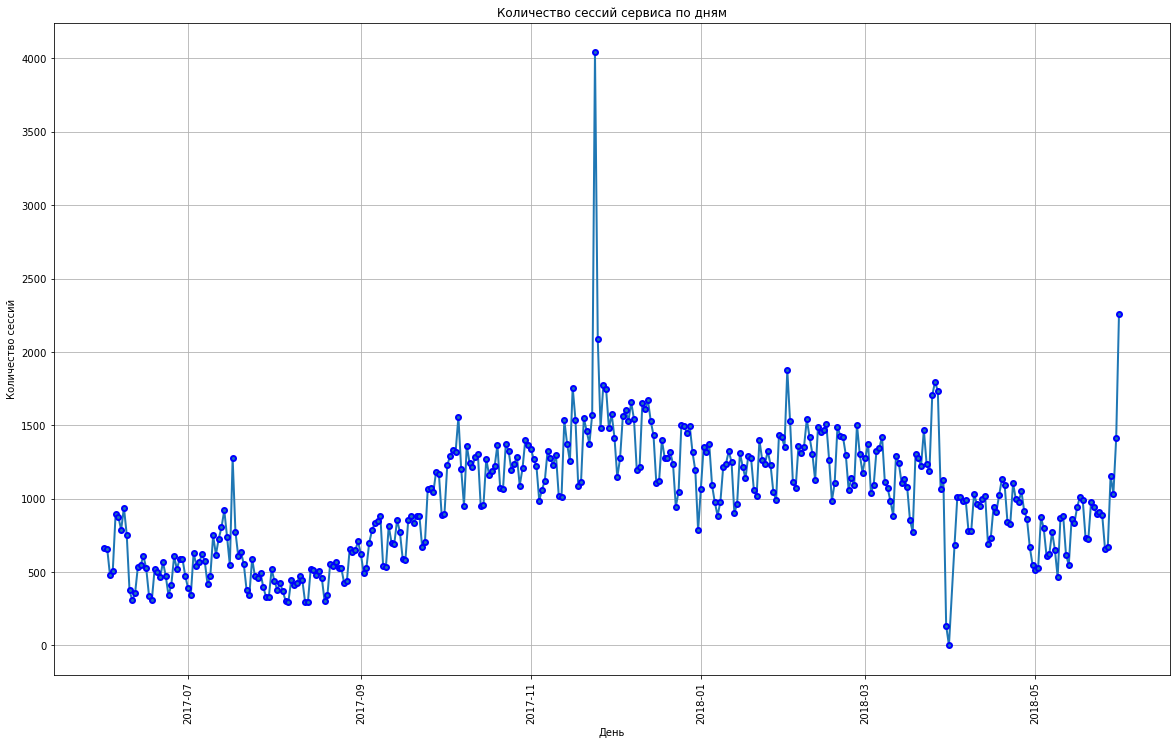

In [102]:
x = day_visits['date_visit']
y = day_visits['visits']

plt.figure(figsize=(20, 12))
plt.plot(x, y, 'o-', lw=2, mec='b', mew=2, ms=5)


plt.xlabel('День')
plt.ylabel('Количество сессий')
plt.title('Количество сессий сервиса по дням')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Количество сессий чуть выше, чем количество пользователей в день. В целом график с сессиями идентичен графику с дневными пользователями. Посчитаем количество сессий на пользователя в день.

In [103]:
day_visits = day_visits.merge(dau, on='date_visit', how='inner')

In [104]:
day_visits.head()

date_visit  visits  uid
0 2017-06-01     664  605
1 2017-06-02     658  608
2 2017-06-03     477  445
3 2017-06-04     510  476
4 2017-06-05     893  820

In [105]:
day_visits['visits_per_user'] = day_visits['visits'] / day_visits['uid']

In [106]:
day_visits.head()

date_visit  visits  uid  visits_per_user
0 2017-06-01     664  605         1.097521
1 2017-06-02     658  608         1.082237
2 2017-06-03     477  445         1.071910
3 2017-06-04     510  476         1.071429
4 2017-06-05     893  820         1.089024

Построим график по количетсву сессий на пользователя.

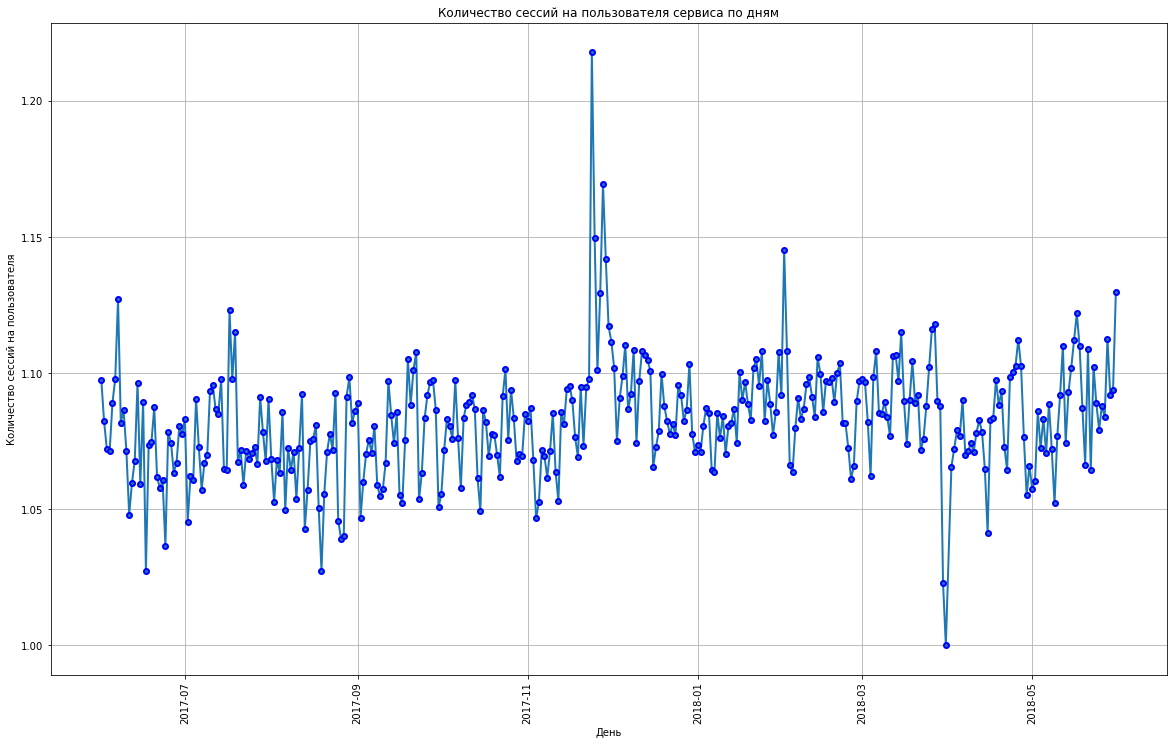

In [107]:
x = day_visits['date_visit']
y = day_visits['visits_per_user']

plt.figure(figsize=(20, 12))
plt.plot(x, y, 'o-', lw=2, mec='b', mew=2, ms=5)


plt.xlabel('День')
plt.ylabel('Количество сессий на пользователя')
plt.title('Количество сессий на пользователя сервиса по дням')
plt.xticks(rotation=90)
plt.grid()
plt.show()

В ноябре, когда был пик по количеству пользователей и сессий в количестве сессий на пользователя тоже наблюдается пик, то есть пользователи в эти дни еще и заходили чаще обычного.

Посчитаем среднее количество сессий в день в течение имеющегося периода.

In [108]:
day_visits['visits'].describe()

count     364.000000
mean      987.362637
std       418.994796
min         1.000000
25%       635.500000
50%      1003.000000
75%      1280.000000
max      4042.000000
Name: visits, dtype: float64

Среднее количество сессий в день составило 987, а медиана - 1003, при этом 75% посещений не превышало значение 1280 за весь период. 

Посчитаем среднее число сессий на пользователя в день за весь период.

In [109]:
day_visits['visits'].mean()/day_visits['uid'].mean()

1.0874136559064957

Получилось, что в среднем у пользователей было чуть больше одной сессии в день. 

#### Количество сессий в день в разбивке по платформам <a id="sessions_by_platform"></a>

In [110]:
day_visits_device = visits.pivot_table(index='date_visit', columns='device', values='uid', aggfunc='count')

In [111]:
day_visits_device = day_visits_device.sort_values(by='date_visit').reset_index()

In [112]:
day_visits_device.head()

device date_visit  desktop  touch
0      2017-06-01    501.0  163.0
1      2017-06-02    498.0  160.0
2      2017-06-03    329.0  148.0
3      2017-06-04    349.0  161.0
4      2017-06-05    693.0  200.0

In [113]:
day_visits_device.describe()

device      desktop       touch
count    364.000000  363.000000
mean     721.337912  266.757576
std      322.327697  110.862623
min        1.000000   47.000000
25%      457.250000  181.000000
50%      711.000000  278.000000
75%      961.500000  337.000000
max     3152.000000  890.000000

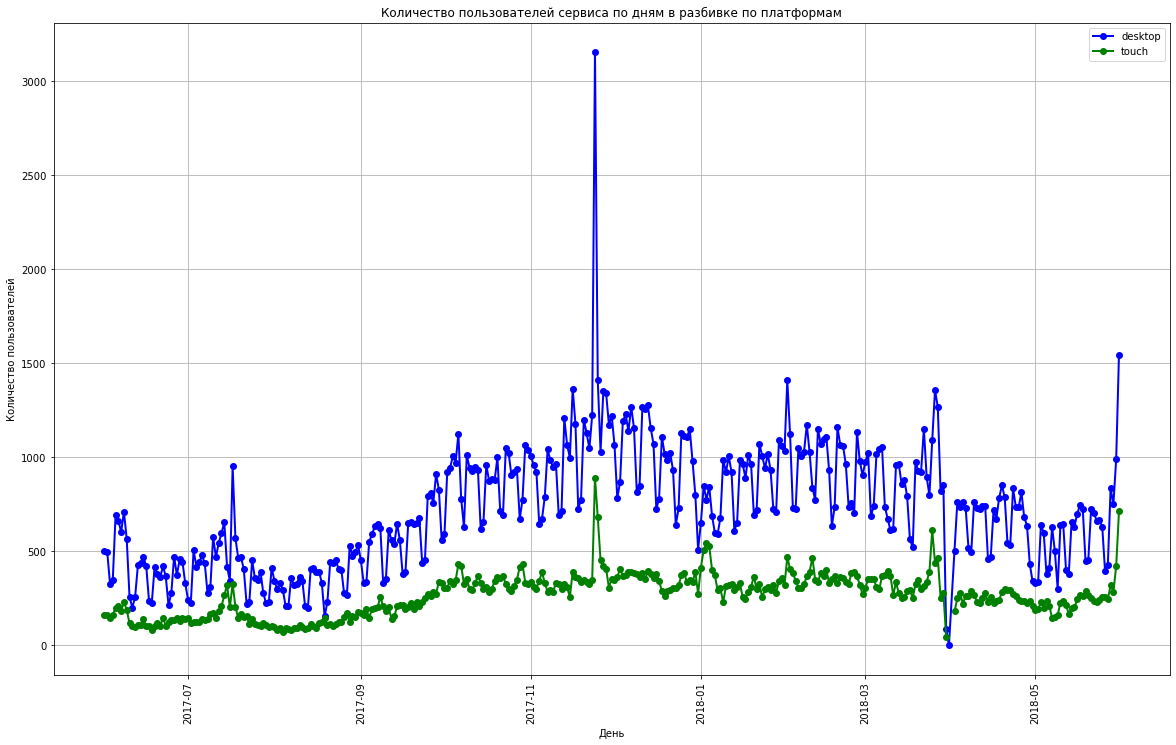

In [114]:
x = day_visits_device['date_visit']
y1 = day_visits_device['desktop']
y2 = day_visits_device['touch']

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mec='b', mew=2, ms=5, label='desktop')
plt.plot(x, y2, 'o-g', lw=2, mec='g', mew=2, ms=5, label='touch')


plt.xlabel('День')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей сервиса по дням в разбивке по платформам')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

Количество посещений на компьютерах весь период выше количества пользователей на мобильных устройствах. В осенне-зимние месяцы максимальный разрыв между количеством посещений.

#### Количество сессий в день в разбивке по источникам трафика <a id="sessions_by_source"></a>

In [115]:
day_visits_source = visits.pivot_table(index='date_visit', columns='source_id', values='uid', aggfunc='count')

In [116]:
day_visits_source = day_visits_source.sort_values(by='date_visit').fillna(0).reset_index()

In [117]:
day_visits_source.head()

source_id date_visit     1      2      3      4      5    6    7     9    10
0         2017-06-01  70.0   85.0  185.0  141.0  122.0  0.0  0.0  52.0   9.0
1         2017-06-02  60.0   98.0  181.0  160.0  123.0  0.0  0.0  15.0  21.0
2         2017-06-03  40.0   64.0  124.0  112.0   91.0  0.0  0.0  22.0  24.0
3         2017-06-04  51.0   59.0  141.0  115.0  110.0  0.0  0.0  15.0  19.0
4         2017-06-05  86.0  108.0  269.0  175.0  141.0  0.0  0.0  78.0  36.0

In [118]:
day_visits_source.describe()

source_id          1           2           3           4           5   \
count      364.000000  364.000000  364.000000  364.000000  364.000000   
mean        93.739011  130.840659  235.192308  279.653846  183.804945   
std         51.809680   65.793666   99.263077  124.792857   69.279550   
min          1.000000    0.000000    0.000000    0.000000    0.000000   
25%         59.000000   83.750000  153.750000  169.750000  133.750000   
50%         91.000000  130.500000  238.000000  298.500000  180.500000   
75%        120.000000  163.250000  305.000000  376.250000  227.000000   
max        615.000000  649.000000  965.000000  783.000000  427.000000   

source_id          6           7           9           10  
count      364.000000  364.000000  364.000000  364.000000  
mean         0.016484    0.098901   36.475275   27.541209  
std          0.127501    0.316835   47.901666   19.392735  
min          0.000000    0.000000    0.000000    0.000000  
25%          0.000000    0.000000    9.000000   14.000000  
50%          0.000000    0.000000   22.000000   23.000000  
75%          0.000000    0.000000   52.250000   36.500000  
max          1.000000    2.000000  567.000000  135.000000

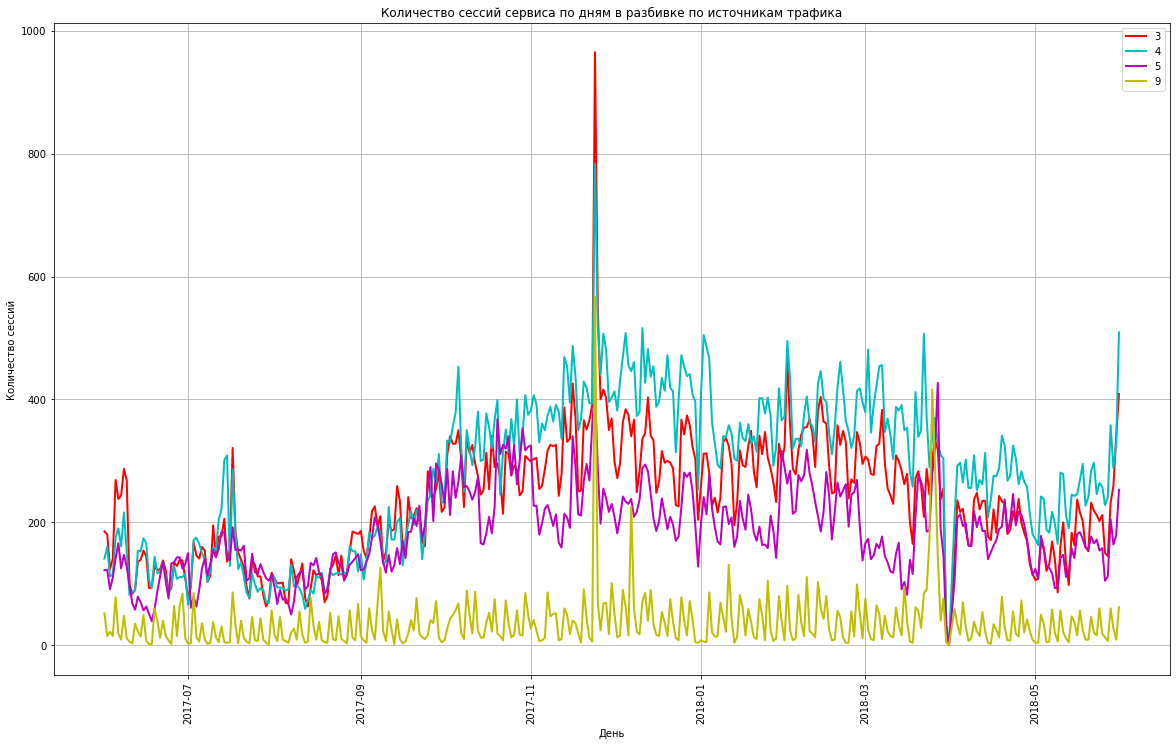

In [119]:
x = day_visits_source['date_visit']
y3 = day_visits_source[3]
y4 = day_visits_source[4]
y5 = day_visits_source[5]
y9 = day_visits_source[9]

plt.figure(figsize=(20, 12))

plt.plot(x, y3, '-r', lw=2, mew=2, ms=5, label='3')
plt.plot(x, y4, '-c', lw=2, mew=2, ms=5, label='4')
plt.plot(x, y5, '-m', lw=2, mew=2, ms=5, label='5')
plt.plot(x, y9, '-y', lw=2, mew=2, ms=5, label='9')



plt.xlabel('День')
plt.ylabel('Количество сессий')
plt.title('Количество сессий сервиса по дням в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

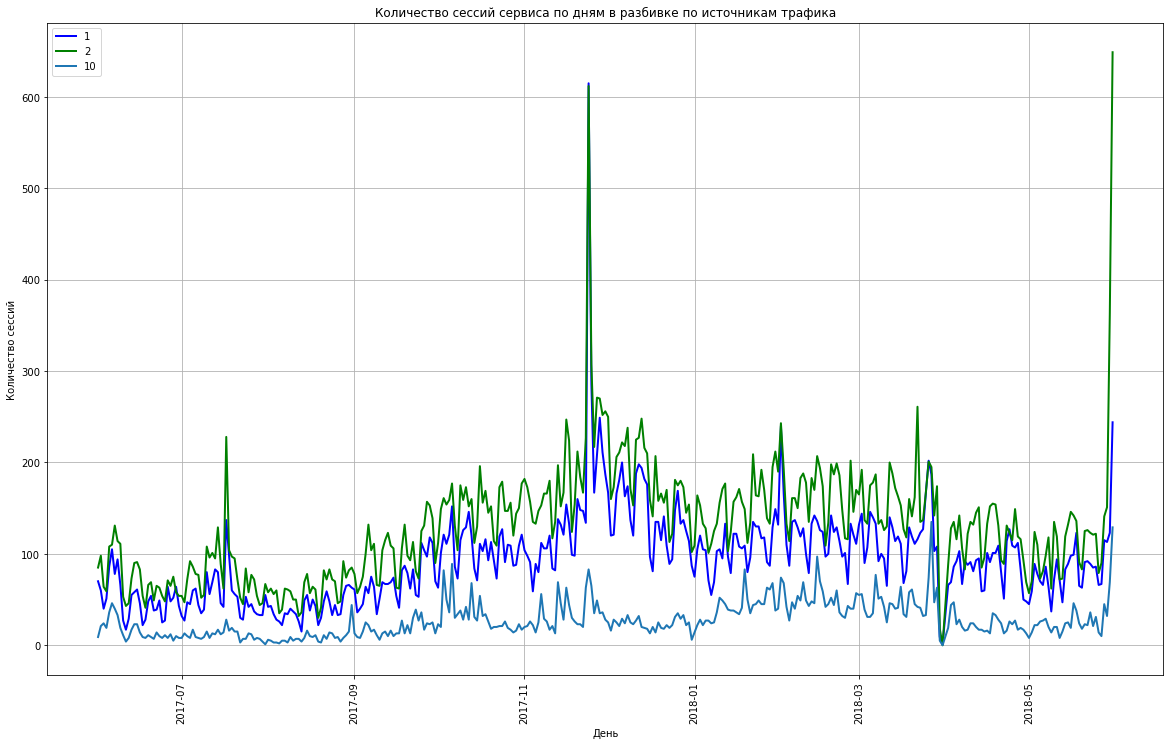

In [120]:
x = day_visits_source['date_visit']
y1 = day_visits_source[1]
y2 = day_visits_source[2]
y10 = day_visits_source[10]

plt.figure(figsize=(20, 12))
plt.plot(x, y1, '-b', lw=2, mew=2, ms=5, label='1')
plt.plot(x, y2, '-g', lw=2, mew=2, ms=5, label='2')
plt.plot(x, y10, '-', lw=2, mew=2, ms=5, label='10')


plt.xlabel('День')
plt.ylabel('Количество сессий')
plt.title('Количество сессий сервиса по дням в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

Количество сессий в день по источникам трафика чуть выше количества посетителей, но поведение графиков одинаковое. На 3-м, 4-м и 5-м источников сессий в день больше всего. 9-й, 1-й и 2-й источники собирают меньше визитов, и на последнем месте 10-й источник по количеству посещений в день. В динамике на всех источниках наблюдается сезонность.

#### Длительность одной сессии <a id="duration"></a>

Посчитаем длительность каждой сессии.

In [121]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [122]:
visits.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid date_visit week_visit month_visit  duration  
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01      1080  
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01      1680  
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01         0  
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01      1440  
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01         0

In [123]:
visits['duration'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: duration, dtype: float64

В среднем длительность сессии составила 643.5 секунды, а медиана - 300 секунд, разница больше чем в 2 раза, значит есть большие выбросы. Например максимальное значение составило 84480 - почти 24 часа - явно какая-то аномалия.

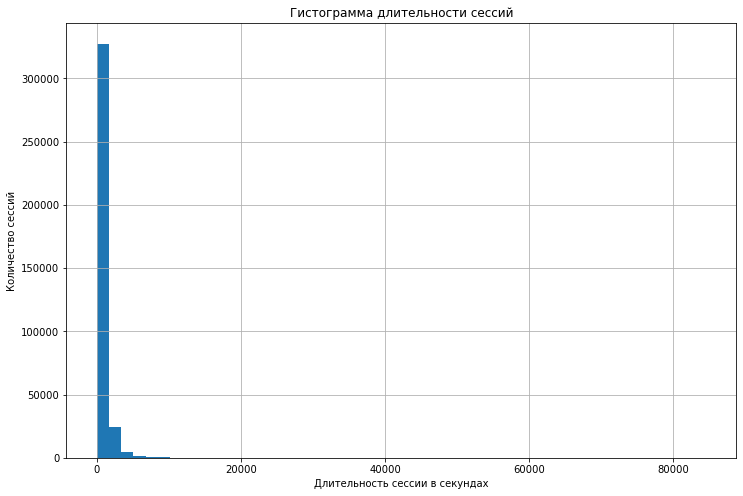

In [124]:
visits['duration'].hist(bins=50, figsize=(12,8))
plt.title('Гистограмма длительности сессий')
plt.xlabel('Длительность сессии в секундах')
plt.ylabel('Количество сессий')
plt.show()

Наше распределение далеко от нормального, поэтому посчитаем моду.

In [125]:
visits['duration'].mode()

0    60
dtype: int64

Получилось, что чаще всего у нас встречается значение в 60 секунд. 

Попробуем все-таки рассчитать среднее и медиану, для этого ограничим нашу выборку сверху 2 часами - вдяд ли кто-то проводит на сайте больше 2 часов к ряду. 

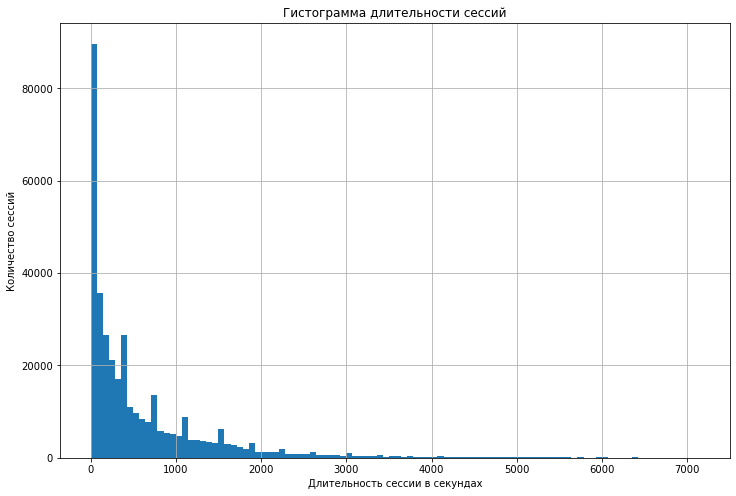

In [126]:
visits.query('duration < 7200')['duration'].hist(bins=100, figsize=(12,8))
plt.title('Гистограмма длительности сессий')
plt.xlabel('Длительность сессии в секундах')
plt.ylabel('Количество сессий')
plt.show()

Кажется, чаще всего бывают сессии, у которых длительность больше нуля, посмотрим на гистограмму без них.

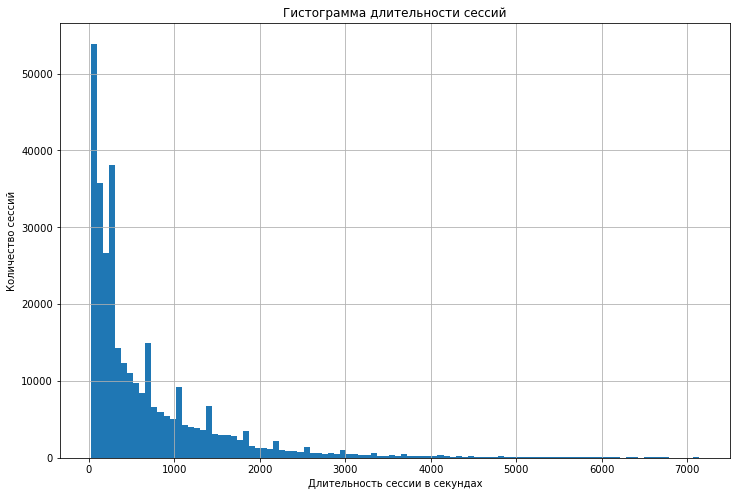

In [127]:
visits.query('duration < 7200 and duration > 0')['duration'].hist(bins=100, figsize=(12,8))
plt.title('Гистограмма длительности сессий')
plt.xlabel('Длительность сессии в секундах')
plt.ylabel('Количество сессий')
plt.show()

Все равно коротких сессий большинство. Построим теперь диаграмму размаха, чтобы понять, где начинаются выбросы.

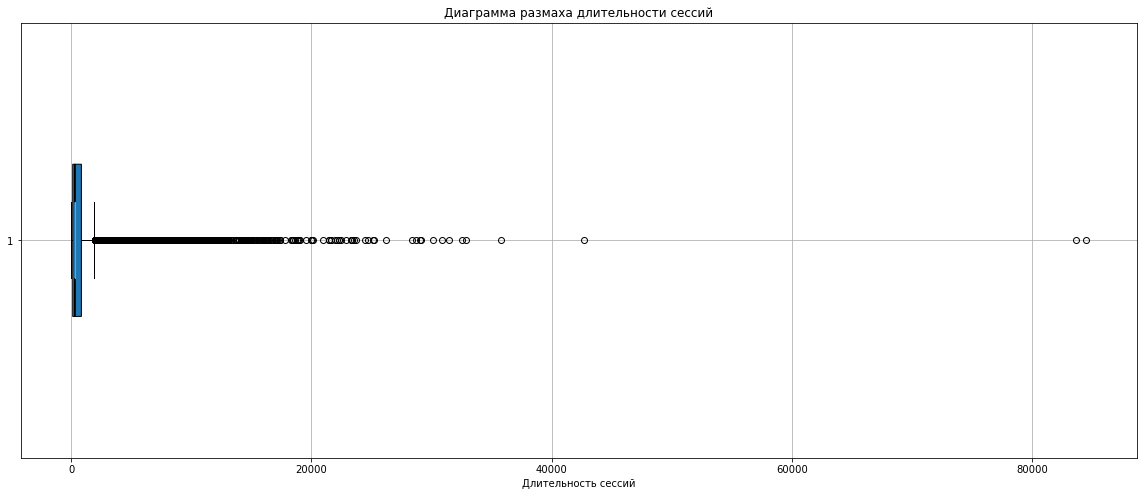

In [128]:
df = [visits['duration']]
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title('Диаграмма размаха длительности сессий')
ax.set_xlabel('Длительность сессий')

bp = ax.boxplot(df, vert=False, positions=[1], 
           notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="C0"))
ax.grid()

Если не ограничивать длительность, то медианы почти не видно, а выбросы начинаются где-то в районе 4000 за сессию. Теперь возьмем все ненулевыве сессии и ограничим сверху двумя часами.

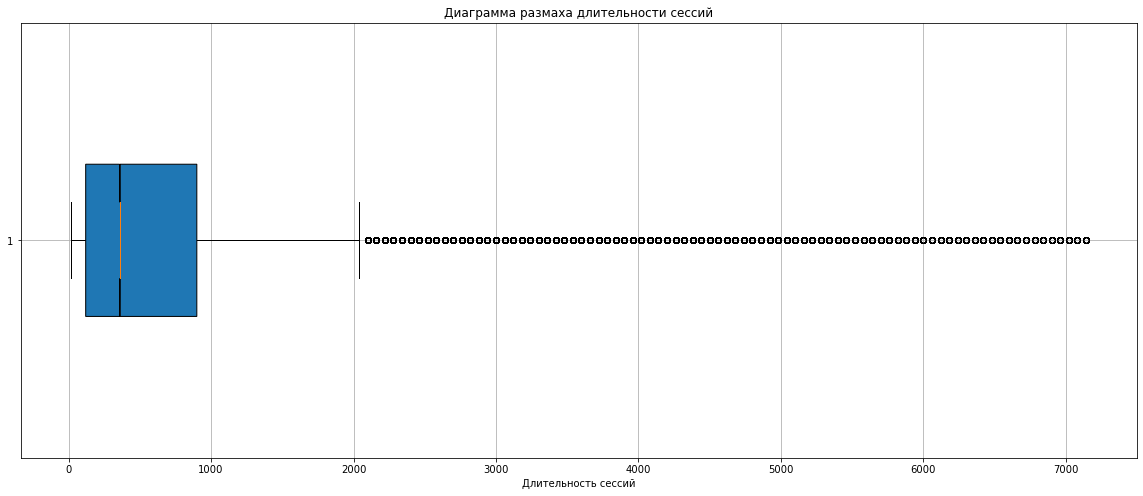

In [129]:
df = [visits.query('duration > 0 and duration < 7200')['duration']]
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title('Диаграмма размаха длительности сессий')
ax.set_xlabel('Длительность сессий')

bp = ax.boxplot(df, vert=False, positions=[1], 
           notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="C0"))
ax.grid()

Верхний ус упирается в значение чуть больше 2000 секунд - это 35 минут, то есть больше этого значения уже начинаются выбросы. Пересчитаем среднее и медиану с новыми ограничениями. 

In [130]:
visits.query('duration > 0 and duration < 7200')['duration'].describe()

count    322666.000000
mean        686.264038
std         860.749086
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max        7140.000000
Name: duration, dtype: float64

Получается, что средняя длительность сессии составила 11,5 минут, а медиана 6 минут. 75% значений не превысило 15 минут за сессию.

#### Длительность одной сессии в разбивке по платформам <a id="duration_by_platform"></a>

Посчитаем длительность одной сессии в разбивке по платформам.

In [131]:
visits.groupby('device')['duration'].describe()

count        mean          std  min    25%    50%    75%      max
device                                                                       
desktop  262567.0  703.946977  1091.545596  0.0  120.0  360.0  900.0  84480.0
touch     96833.0  479.619407   752.531533  0.0   60.0  180.0  600.0  30840.0

Длительность одной сессий на мобильном устройстве в среднем составила 480 секунд, тогда как на компьютере 704 секунды. Однако из-за высоких выбросов, лучше смотреть на медиану. Медиана длительности сессии на мобильных устройствах составила 180 секунд, а на компьютерах - 360 - в 2 раза больше. 

Посчитаем моду в разбивке по платформам.

In [132]:
visits.query('device == "desktop"')['duration'].mode()

0    60
dtype: int64

In [133]:
visits.query('device == "touch"')['duration'].mode()

0    60
dtype: int64

Моды у устройств одинаковые и равны 60 секнудам - это самое часто встречающеся значение.

Посмотрим на гистограммы в разбивке по устройствам с учетом введенных ранее ограничений. 

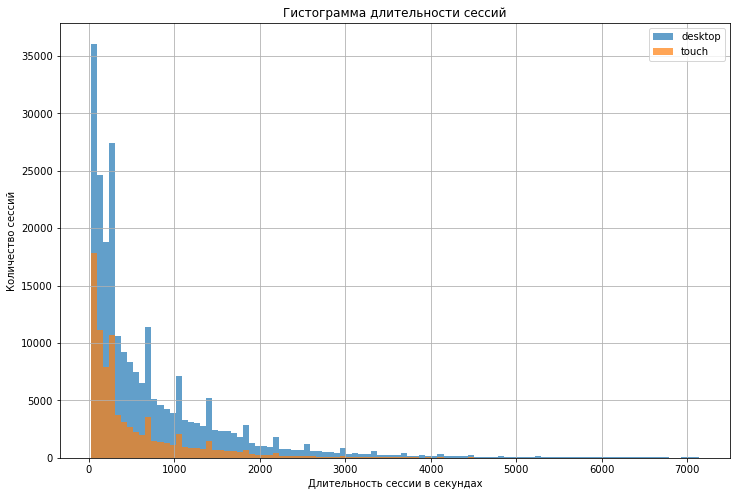

In [134]:
visits.query('duration < 7200 and duration > 0 and device == "desktop"')['duration'].hist(
    bins=100, figsize=(12,8), alpha=0.7, label='desktop')
visits.query('duration < 7200 and duration > 0 and device == "touch"')['duration'].hist(
    bins=100, figsize=(12,8), alpha=0.7, label='touch')
plt.title('Гистограмма длительности сессий')
plt.xlabel('Длительность сессии в секундах')
plt.ylabel('Количество сессий')
plt.legend()
plt.show()

Распределение на компьютерах шире и имеет более длинный хвост, смещенный вправо. Однако силуэт гистограмм совпадает, особенно это заметно по пикам. 

In [135]:
visits.query('duration < 7200 and duration > 0').groupby('device')['duration'].describe()

count        mean         std   min    25%    50%     75%     max
device                                                                       
desktop  238034.0  739.419856  908.131062  19.0  120.0  420.0  1020.0  7140.0
touch     84632.0  536.759216  689.105391  19.0  120.0  240.0   720.0  7140.0

Без учета нулевых значений и выбросов, получается, что медиана длительности сессии на компьютерах составила 420 секунд или 7 минут, а на мобильных устройствах - 240 секунд или 4 минуты. Разница в 1,75 раз.

#### Длительность одной сессии в разбивке по источникам трафика <a id="duration_by_source"></a>

Посчитаем моды по источникам трафика.

In [136]:
source = [1,2,3,4,5,9,10]

In [137]:
source_mode = pd.Series(index=source)

<ipython-input-137-a96191363658>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  source_mode = pd.Series(index=source)


In [138]:
for i in source:
    source_mode[i] = visits[visits['source_id'] == i]['duration'].mode()

In [139]:
source_mode

1     60.0
2     60.0
3     60.0
4     60.0
5     60.0
9     60.0
10    60.0
dtype: float64

Самое частое значение длительности сессии по всем источникам трафика тоже получилось равным 60 секундам.

Теперь посчитаем среднее и медианы с введенными ранее ограничениями.

In [140]:
visits.query('duration < 7200 and duration > 0').groupby('source_id')['duration'].describe()

count         mean          std    min    25%    50%     75%  \
source_id                                                                   
1          31856.0  1018.582433  1122.917704   19.0  240.0  660.0  1440.0   
2          43111.0   841.879497  1020.416160   19.0  180.0  480.0  1140.0   
3          76474.0   626.845438   791.482849   19.0  120.0  300.0   840.0   
4          90817.0   619.496119   769.709146   19.0  120.0  300.0   840.0   
5          59474.0   585.568921   737.173506   19.0  120.0  300.0   780.0   
6              5.0  1644.000000  2436.694482  180.0  360.0  480.0  1260.0   
7             35.0   624.000000   974.689091   60.0  120.0  180.0   840.0   
9          11960.0   615.578595   781.040760   19.0  120.0  300.0   780.0   
10          8934.0   702.393105   867.068314   19.0  120.0  360.0   960.0   

              max  
source_id          
1          7140.0  
2          7140.0  
3          7140.0  
4          7140.0  
5          7080.0  
6          5940.0  
7          5280.0  
9          7140.0  
10         7080.0

Самая большая медиана длительности сессий на 1-м источнике трафика и составляет 660 секунд или 11 минут. На втором месте 2-й источник трафика с медианой в 480 секунд или 8 минут, а на третьем месте 10-й источник трафика с медианой 360 секунд или 6 минут. У остальных источников трафика медиана составила 300 секунд или 5 минут. 6-й и 7-й источники трафика в расчет не берем, так как на них почти нет значений.

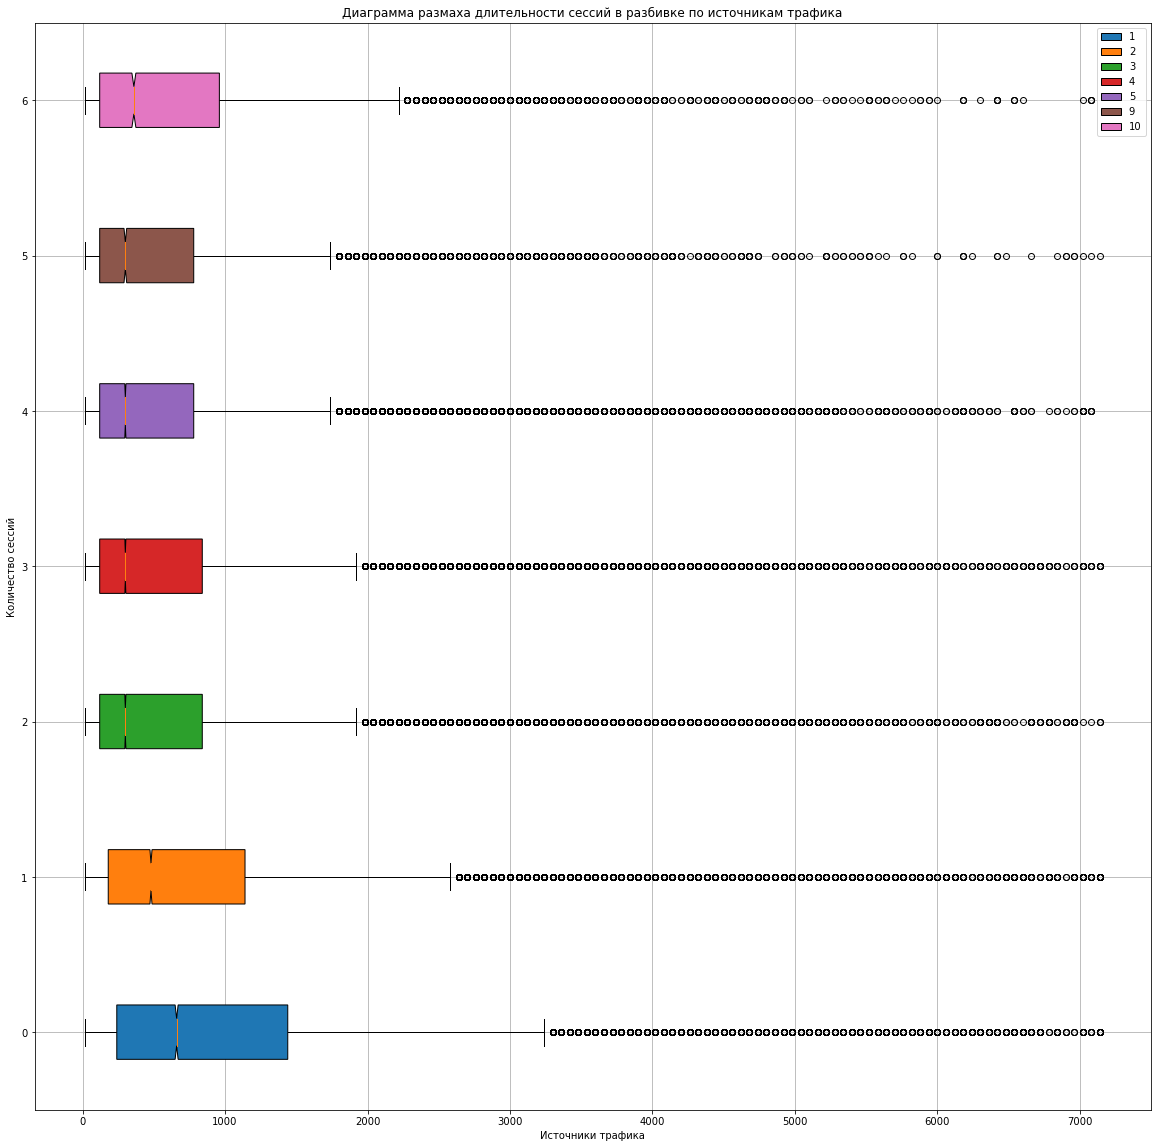

In [141]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_title('Диаграмма размаха длительности сессий в разбивке по источникам трафика')
ax.set_ylabel('Количество сессий')
ax.set_xlabel('Источники трафика')
leg = []

def show_boxplot(row):
    
    for i in range(len(row)):
        name = row[i]
        color = 'C' + str(i)
        
        df = [visits.query('duration < 7200 and duration > 0 and source_id == @name')['duration']]
        
        bp = ax.boxplot(df, positions=[i], vert=False,
           notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color))
        
        leg.append(bp["boxes"][0])

show_boxplot(source)

ax.legend(leg, source, loc='best')
plt.grid()

По длительности одной сессий побеждает 1-й источник трафика, на втором месте - 2-й источник трафика, на третьем месте - 10-й источник трафика. У 1-го источника трафика верхний ус превышает 3200 секунд - это больше 53 минут  Кажется, все-таки эти источники больше органические. 
5-й и 9-й источники трафика имеют самую низкую длительность, их верхние усы упираются в 1700 секунд, чуть больше длительность сессии на 4-м источнике трафика, его верхний ус не превышает 2000 секунд. Скорей всего что эти три источника в основном рекламные. 

#### Возвращаемость пользователей <a id="retention"></a>

Посчитаем коэффициент возвращаемости пользователей или Retention Rate. Для этого сначала найдем первый день активности каждого пользователя и разобьем данные на когорты.

In [142]:
first_activity_date = visits.groupby(['uid'])['date_visit'].min()

In [143]:
first_activity_date.name = 'first_activity_date'

In [144]:
visits = visits.join(first_activity_date,on='uid') 

In [145]:
visits.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid date_visit week_visit month_visit  duration  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01      1080   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01      1680   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01         0   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01      1440   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01         0   

  first_activity_date  
0          2017-12-20  
1          2018-02-19  
2          2017-07-01  
3          2018-03-09  
4          2017-12-27

Когорты будем строить по месяцам, так как очень мало людей ходит на мерояприятия каждую неделю и соответвенно ищет по ним события. Чаще всего обычные люди ходят куда-то раз в несколько месяцев. Теперь посчитаем день начала месяца, за которую произошло первое событие. Он станет идентификатором месяца.

In [146]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты. 

In [147]:
visits['cohort_lifetime'] = visits['month_visit'] - visits['first_activity_month']

In [148]:
visits.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid date_visit week_visit month_visit  duration  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01      1080   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01      1680   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01         0   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01      1440   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01         0   

  first_activity_date first_activity_month cohort_lifetime  
0          2017-12-20           2017-12-01          0 days  
1          2018-02-19           2018-02-01          0 days  
2          2017-07-01           2017-07-01          0 days  
3          2018-03-09           2018-03-01         61 days  
4          2017-12-27           2017-12-01          0 days

In [149]:
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')

In [150]:
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [151]:
visits.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid date_visit week_visit month_visit  duration  \
0  16879256277535980062 2017-12-20 2017-12-14  2017-12-01      1080   
1    104060357244891740 2018-02-19 2018-02-15  2018-02-01      1680   
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01         0   
3  16174680259334210214 2018-05-20 2018-05-17  2018-05-01      1440   
4   9969694820036681168 2017-12-27 2017-12-21  2017-12-01         0   

  first_activity_date first_activity_month  cohort_lifetime  
0          2017-12-20           2017-12-01                0  
1          2018-02-19           2018-02-01                0  
2          2017-07-01           2017-07-01                0  
3          2018-03-09           2018-03-01                2  
4          2017-12-27           2017-12-01                0

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:

In [152]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

In [153]:
cohorts.head()

first_activity_month  cohort_lifetime    uid
0           2017-06-01                0  13259
1           2017-06-01                1   1043
2           2017-06-01                2    713
3           2017-06-01                3    814
4           2017-06-01                4    909

Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждую следующую неделю.
Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю:

In [154]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]

In [155]:
initial_users_count.head()

first_activity_month    uid
0            2017-06-01  13259
12           2017-07-01  13140
23           2017-08-01  10181
33           2017-09-01  16704
42           2017-10-01  25977

Переименуем столбец user_id в cohort_users:

In [156]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

Объединим данные по когортам с исходным количеством пользователей в когорте:

In [157]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month') 

Рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте:

In [158]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users'] 

Построим сводную таблицу:

In [159]:
retention_pivot = cohorts.pivot_table(
    
    index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum') 

Создадим тепловую карту:

<AxesSubplot:title={'center':'Cohorts: User Retention'}, xlabel='cohort_lifetime', ylabel='first_activity_month'>

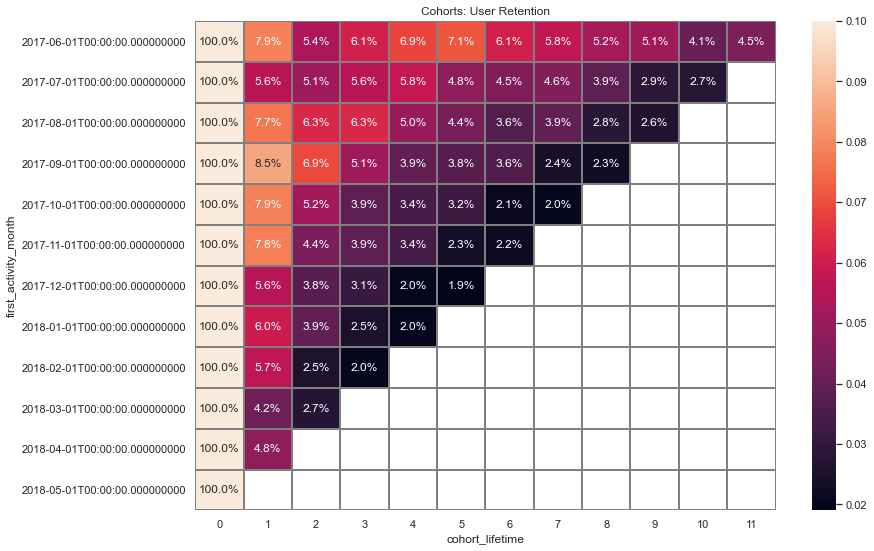

In [160]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.1)

Месячный Retention rate совсем невелик. Ни в одном месяце не превышает даже 10%. 

Первая когорта самая лучшая по показателям возвращаемости. Третья когорта от августа на втором месте по возвращаемости, но после 3-го месяца ее показатели начинают быстро снижаться. Лучший показатель возвращаемости на первый и второй месяц был у 4-й когорты (сентябрьской), но потом возвращаемость тоже быстро снижается. 2-я когорта, июльская, хотя и имеет не очень выскоие показатели возвращаемости в первые 2 месяца, все же довольно медленно теряет пользователей по сравнению со следующими когортами. Все эти месяцы летние, в этот период было не очень много маркетинговых активностей, поэтому тут пользователи в основном органические, поэтому скорее всего и дольше задерживаются.

Выделяется диагональ у первой когорты 5-й месяц, у второй - 4-й месяц, у третьей - 3-й месяц, у четвертой - 2-й месяц. Это ноябрь 2017. В этот месяц у когорт возвращаемость выше, чем в соседние месяцы: и предыдущий и следующий. В этот месяц был пик маркетинговой активности. 

#### Вывод <a id="output_product"></a>

В данных явно выраженна сезонность: в летние месяцы пользователей и сессий меньше всего, в осенне-зимний период аудитория с посещениями начинает расти. С апреля показатели снова снижаются. Это заметно и по общим данным, и в разбивке по устройствам и источникам трафика.

Также есть аномалии в данных - неожиданные пики или провалы в данных. Пики скорей всего связаны с какой-нибудь маркетинговой активностью или значимым мероприятием. Провал был вызван скорей всего потерей данных. Самый большой пик в данных наблюдается на неделе 2017-11-23.

Средние значения месячной аудитории составили:
 - по всем данным - 23228 пользователей
 - по компьютерам - 16725 пользователей
 - по мобильным устройствам - 6826 пользователей

В разбивке по источникам трафика получились такие средние месячные показатели аудитории:
 - 1-й источник - 1819
 - 2-й источник - 2752
 - 3-й источник - 6759
 - 4-й источник - 7766
 - 5-й источник - 5018
 - 9-й источник - 987
 - 10-й источник - 707
 
На 6 и 7 источниках почти нет пользователей, поэтому в расчет их не будем принимать.

На 4-м иточнике больше всего посетителей и на нем не очень много каких-то искусственных пиков, скорей всего это какой-то органический источник трафика: либо поисковый, либо прямой. 1-й и 2-й источники тоже похожи на органические источники. Но так как на поддержание посетителей все равно нужно выделять средства, то на этих источниках необычные пики встречаются. По количеству пиков выделяется 5-й источник трафика - на нем либо хорошо срабатывают рекламные активности, либо они проводятся только конкретно для этого источника трафика. На 3-м источнике трафика очень хорошо сработала активность в ноябре, так что даже количество посетителей на этом источнике превысило количество посетителей на 4-м источнике трафика. На 9-м источнике тоже есть много необычных пиков. На неделе 2018-03-22 количество посетителей на этом источнике побило количество посетитлей на 1-м и 2-м источниках трафика.

Stiky factor у нашего сервиса очень низкий и близок к минимальному и в разрезе по неделям, и в разрезе по месяцам. У мобильных устройств stiky factor ниже, чем на компьютерах. 

Количество сессий почти не отличается от количества пользователей. Отношение среднего количества дневных сессий к количеству дневных пользователей составило 1.087. То есть пользователи обычно заходят на сайт не чаще одного раза в день.

Длительность одной сессии по моде составила 60 секунд. Это и по общим данным, и в разбивке и по платформам и источникам трафика. Однако если ограничить данные: взять длительность сессии больше 0 и меньше 2 часов, то получаем следующие значения:
 - в общем медианная длительность сессии составляет 360 секунд
 - на компьютерах медиана - 420 секунд
 - на мобильных устройствах медиана - 240 секунд
 
Коэффициент возвращаемости мы посчитали по месяцам, так как обычно люди не очень часто ходят на какие-то мероприятия. Обычно раз в несколько месяцев. Получилось, что месячный retention rate не велик. В когортах летних месяцев возвращаемость была выше, чем в другие месяцы. Скорей всего из-за того, что эти пользователи были в основном органические.

### Продажи <a id="sales"></a>

#### Когда люди начинают покупать? <a id="first_purchase"></a>

Сформируем поведенческие когорты по первым покупкам пользователей. Для этого нужно будет таблицу с посещениями совместить с таблицей с покупками. Но перед этим сначала сгруппируем таблицу с посещениями по пользователям и их первому источнику трафика, устройству и начальной дате.

In [161]:
first_visit = visits.sort_values(by='start_ts').groupby('uid').agg(
    {'source_id': 'first', 'device': 'first', 'start_ts': 'min'})

In [162]:
orders = orders.join(first_visit, on='uid', how='inner')

In [163]:
orders.head()

buy_ts  revenue                   uid  source_id   device  \
0 2017-06-01 00:10:00    17.00  10329302124590727494          1  desktop   
1 2017-06-01 00:25:00     0.55  11627257723692907447          2  desktop   
2 2017-06-01 00:27:00     0.37  17903680561304213844          2  desktop   
3 2017-06-01 00:29:00     0.55  16109239769442553005          2  desktop   
4 2017-06-01 07:58:00     0.37  14200605875248379450          3  desktop   

             start_ts  
0 2017-06-01 00:09:00  
1 2017-06-01 00:14:00  
2 2017-06-01 00:25:00  
3 2017-06-01 00:14:00  
4 2017-06-01 07:31:00

Теперь у нас есть таблица с покупками и изначальными характеристиками пользователя. Можем делать когорты.

In [164]:
orders['date_purchase'] = orders['buy_ts'].astype('datetime64[D]')

In [165]:
first_purchase_date = orders.groupby(['uid'])['buy_ts'].min()

In [166]:
first_purchase_date.name = 'first_purchase_date'

In [167]:
orders = orders.join(first_purchase_date,on='uid') 

In [168]:
orders.head()

buy_ts  revenue                   uid  source_id   device  \
0 2017-06-01 00:10:00    17.00  10329302124590727494          1  desktop   
1 2017-06-01 00:25:00     0.55  11627257723692907447          2  desktop   
2 2017-06-01 00:27:00     0.37  17903680561304213844          2  desktop   
3 2017-06-01 00:29:00     0.55  16109239769442553005          2  desktop   
4 2017-06-01 07:58:00     0.37  14200605875248379450          3  desktop   

             start_ts date_purchase first_purchase_date  
0 2017-06-01 00:09:00    2017-06-01 2017-06-01 00:10:00  
1 2017-06-01 00:14:00    2017-06-01 2017-06-01 00:25:00  
2 2017-06-01 00:25:00    2017-06-01 2017-06-01 00:27:00  
3 2017-06-01 00:14:00    2017-06-01 2017-06-01 00:29:00  
4 2017-06-01 07:31:00    2017-06-01 2017-06-01 07:58:00

Создадим новый столбец time_to_purchase, содержащий время между появлением пользователя на сайте и покупкой:

In [169]:
orders['time_to_purchase'] = orders['buy_ts'].astype('datetime64[m]') - orders['start_ts'].astype('datetime64[m]')

In [170]:
orders.sample(5)

buy_ts  revenue                   uid  source_id   device  \
16825 2017-11-09 18:41:00     1.22   9156192766933352988          1  desktop   
10071 2017-10-02 11:37:00     3.05  13525646887041256165          5  desktop   
30108 2018-01-19 17:54:00     2.14   8095878427344173194         10  desktop   
832   2017-06-07 18:10:00     0.76  14631695278830698266          4  desktop   
36422 2018-02-22 16:00:00     0.82   2809252525935519077          4  desktop   

                 start_ts date_purchase first_purchase_date time_to_purchase  
16825 2017-10-31 18:20:00    2017-11-09 2017-11-09 18:41:00  9 days 00:21:00  
10071 2017-10-02 11:26:00    2017-10-02 2017-10-02 11:37:00  0 days 00:11:00  
30108 2018-01-19 17:46:00    2018-01-19 2018-01-19 17:54:00  0 days 00:08:00  
832   2017-06-07 18:04:00    2017-06-07 2017-06-07 18:10:00  0 days 00:06:00  
36422 2018-02-22 14:30:00    2018-02-22 2018-02-22 16:00:00  0 days 01:30:00

Переведем время до покупки в минуты.

In [171]:
orders['time_to_purchase'] = orders['time_to_purchase'] / np.timedelta64(1,'m')

In [172]:
orders['time_to_purchase'] = orders['time_to_purchase'].astype('int') 

In [173]:
orders.sample(5)

buy_ts  revenue                  uid  source_id   device  \
6369  2017-08-30 13:37:00     0.18  6400775514082365053          5  desktop   
37235 2018-02-27 17:05:00     1.22   303817943414846673          4  desktop   
44177 2018-04-15 13:15:00     3.67  6345738199333047358          1  desktop   
14074 2017-10-22 20:20:00     3.05  1338962315385877011          1    touch   
31287 2018-01-27 09:33:00     6.72  3644482766749211722          1  desktop   

                 start_ts date_purchase first_purchase_date  time_to_purchase  
6369  2017-08-27 09:56:00    2017-08-30 2017-08-27 09:59:00              4541  
37235 2018-02-27 16:59:00    2018-02-27 2018-02-27 17:05:00                 6  
44177 2018-04-15 12:49:00    2018-04-15 2018-04-15 13:15:00                26  
14074 2017-07-23 17:25:00    2017-10-22 2017-10-22 20:20:00            131215  
31287 2017-06-01 09:22:00    2018-01-27 2017-06-01 09:22:00            345611

Посчитаем описательные характеристики для времени первых покупок и построим графики.

In [174]:
orders.query('buy_ts == first_purchase_date')['time_to_purchase'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: time_to_purchase, dtype: float64

In [175]:
orders.query('buy_ts == first_purchase_date')['time_to_purchase'].mode()

0    1
dtype: int32

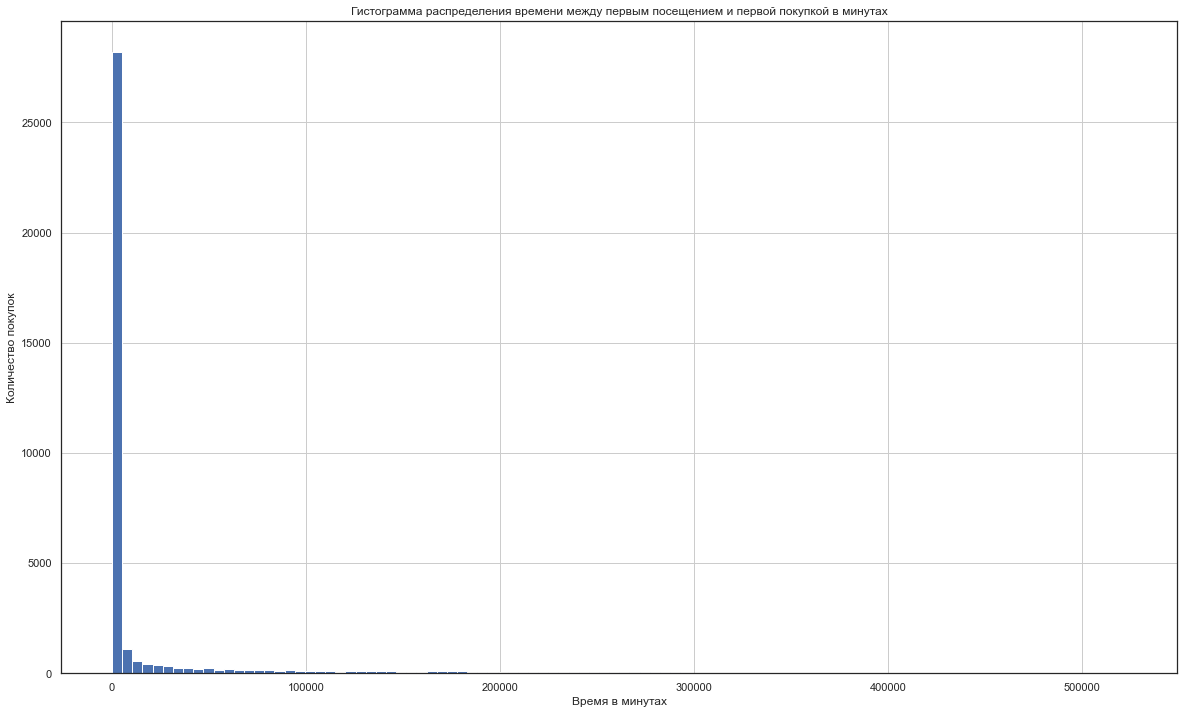

In [176]:
orders.query('buy_ts == first_purchase_date')['time_to_purchase'].hist(bins=100, figsize=(20,12))
plt.title('Гистограмма распределения времени между первым посещением и первой покупкой в минутах')
plt.ylabel('Количество покупок')
plt.xlabel('Время в минутах')
plt.show()

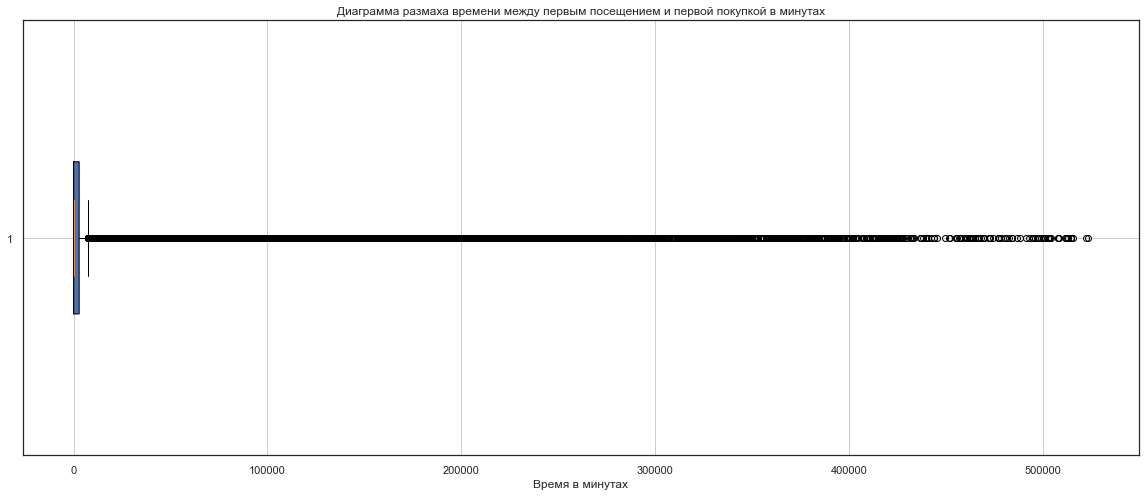

In [177]:
df = [orders.query('buy_ts == first_purchase_date')['time_to_purchase']]
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title('Диаграмма размаха времени между первым посещением и первой покупкой в минутах')
ax.set_xlabel('Время в минутах')

bp = ax.boxplot(df, vert=False, positions=[1], 
           notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="C0"))
ax.grid()

Медианное время до первой покупки составило 16 минут, тогда как среднее - 24340 минут. Мода вообще составила 1 минуту. И по гистограмме и по диаграмме размаха видно, что очень много значений с очень большим временем между первым посещением и первой покупкой. Максимум вообще составил 523144 минут или 363 дня - то есть целый год! Это и правда возможно, но большинство пользователей не такие. 75% укладываются в 2897 минут или 48 часов с момента первого посещения. Чтобы подробнее рассмотреть гистограмму, посмотрим только на первые 100 минут.

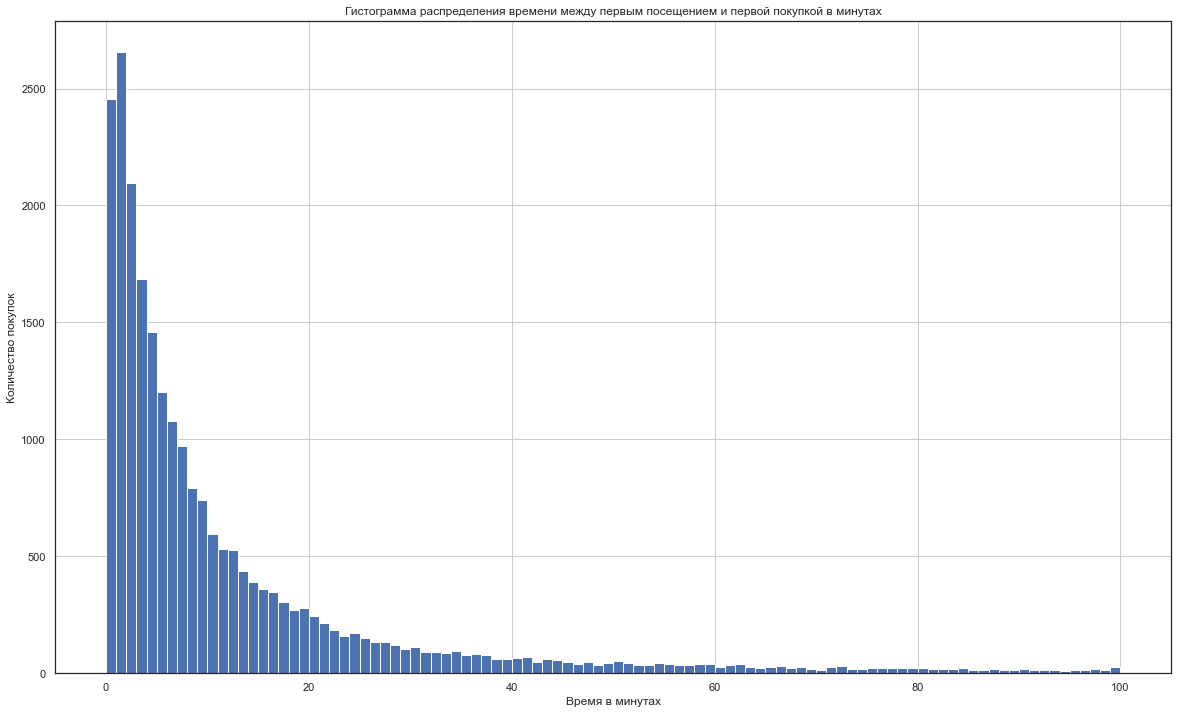

In [178]:
orders.query('buy_ts == first_purchase_date and time_to_purchase <= 100')['time_to_purchase'].hist(
    bins=100, figsize=(20,12))
plt.title('Гистограмма распределения времени между первым посещением и первой покупкой в минутах')
plt.ylabel('Количество покупок')
plt.xlabel('Время в минутах')
plt.show()

In [179]:
orders.query('buy_ts == first_purchase_date').groupby('time_to_purchase')['uid'].count().head(10)

time_to_purchase
0    2455
1    2656
2    2098
3    1685
4    1460
5    1204
6    1077
7     970
8     793
9     742
Name: uid, dtype: int64

Видим, что самые частые значения - это 1 минута, 0 минут и 2 минуты. Дальше идет по убывающей: чем больше времени перед покупкой, тем меньше покупок. То есть вероятность покупки со временем уменьшается. Получается, нужно как-то убедить пользователя как можно скорей приобрести товар, иначе дальше его будет очень трудно уговорить на покупку.

#### Сколько раз покупают за период? <a id="purchase_count"></a>

Посчитаем, сколько раз покупают в день, в неделю и в месяц.

In [180]:
purchase_by_date = orders.groupby('date_purchase')['uid'].count().reset_index()

In [181]:
purchase_by_date.head()

date_purchase  uid
0    2017-06-01   96
1    2017-06-02  111
2    2017-06-03   67
3    2017-06-04   66
4    2017-06-05  161

In [182]:
purchase_by_date.describe()

uid
count  364.000000
mean   138.502747
std     76.858480
min      1.000000
25%     82.750000
50%    136.000000
75%    177.000000
max    814.000000

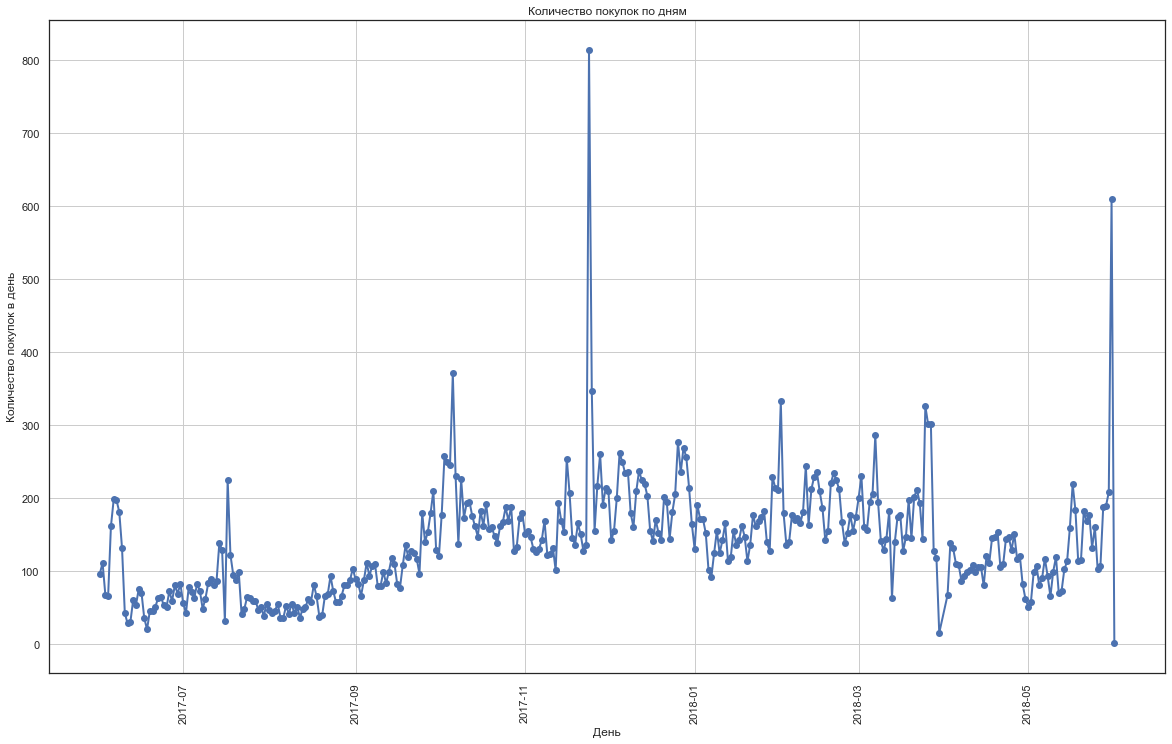

In [183]:
x = purchase_by_date.sort_values(by='date_purchase')['date_purchase']
y = purchase_by_date.sort_values(by='date_purchase')['uid']

plt.figure(figsize=(20, 12))
plt.plot(x, y, 'o-', lw=2, mec='b', mew=2, ms=5)


plt.xlabel('День')
plt.ylabel('Количество покупок в день')
plt.title('Количество покупок по дням')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Среднее количество покупок в день за период составило 138,5, медиана - 136. В 75% случаев количество покупок в день не превышало 177. В динамике количество покупок совпадает с графиком количетсва посетителей и посещений. Видим сезонность и те же пики активности.

Посмотрим количество покупок за неделю.

In [184]:
orders['week_purchase'] = orders['buy_ts'].astype('datetime64[W]')

In [185]:
purchase_by_week = orders.groupby('week_purchase')['uid'].count().reset_index()

In [186]:
purchase_by_week.describe()

uid
count    53.000000
mean    951.226415
std     405.229880
min     319.000000
25%     631.000000
50%     972.000000
75%    1214.000000
max    2120.000000

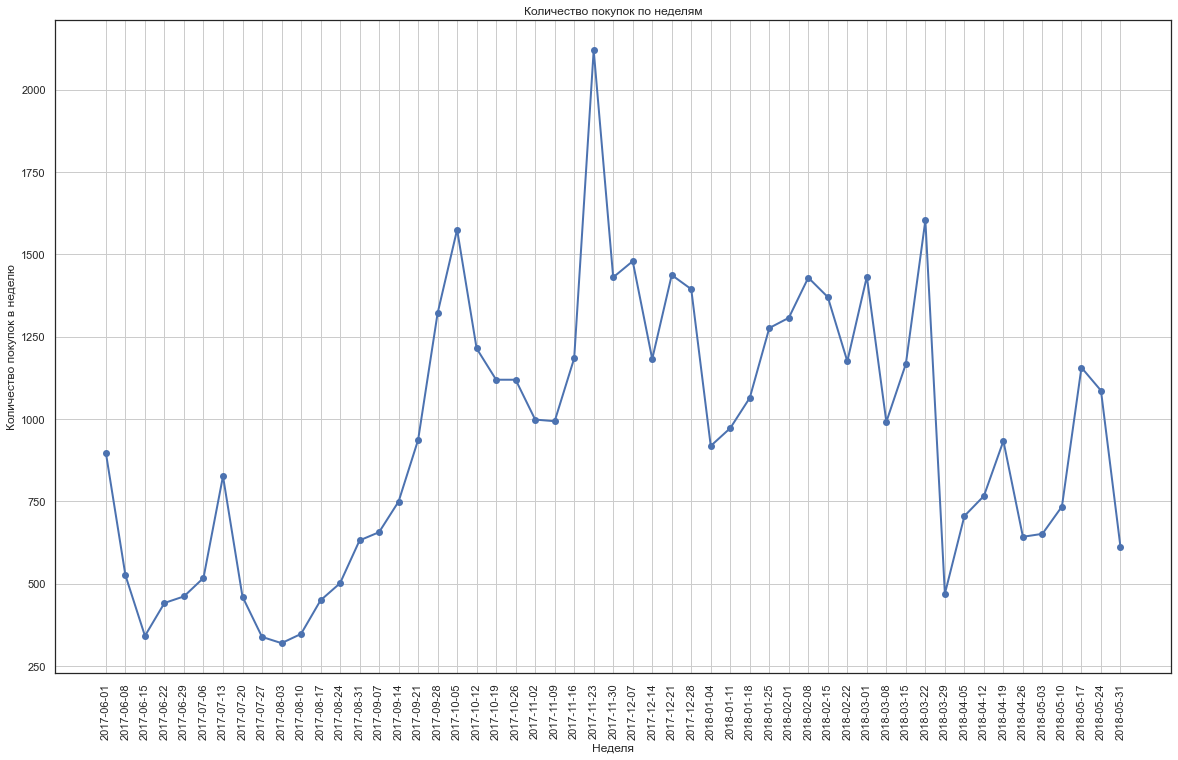

In [187]:
x = purchase_by_week.sort_values(by='week_purchase')['week_purchase'].astype(str)
y = purchase_by_week.sort_values(by='week_purchase')['uid']

plt.figure(figsize=(20, 12))
plt.plot(x, y, 'o-', lw=2, mec='b', mew=2, ms=5)


plt.xlabel('Неделя')
plt.ylabel('Количество покупок в неделю')
plt.title('Количество покупок по неделям')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Среднее количество покупок в неделю составило 951 покупка, а медиана - 972 покупки. 75% значений не превысило 1214 покупок в неделю. Здесь также видим сезонность, привычные пики как в аудиторных метриках. Однако в глаза бросается просадка в октябре и декабре. Такого не наюлюдалось в WAU. 

Теперь посмотрим покупки по месяцам.

In [188]:
orders['month_purchase'] = orders['buy_ts'].astype('datetime64[M]')

In [189]:
purchase_by_month = orders.groupby('month_purchase')['uid'].count().reset_index()

In [190]:
purchase_by_month = purchase_by_month.sort_values(by='month_purchase')

In [191]:
purchase_by_month

month_purchase   uid
0      2017-06-01  2354
1      2017-07-01  2363
2      2017-08-01  1807
3      2017-09-01  3387
4      2017-10-01  5679
5      2017-11-01  5659
6      2017-12-01  6218
7      2018-01-01  4721
8      2018-02-01  5281
9      2018-03-01  5326
10     2018-04-01  3273
11     2018-05-01  4346
12     2018-06-01     1

In [192]:
purchase_by_month.query('month_purchase < "2018-06-01"').describe()

uid
count    12.000000
mean   4201.166667
std    1511.972092
min    1807.000000
25%    3045.500000
50%    4533.500000
75%    5409.250000
max    6218.000000

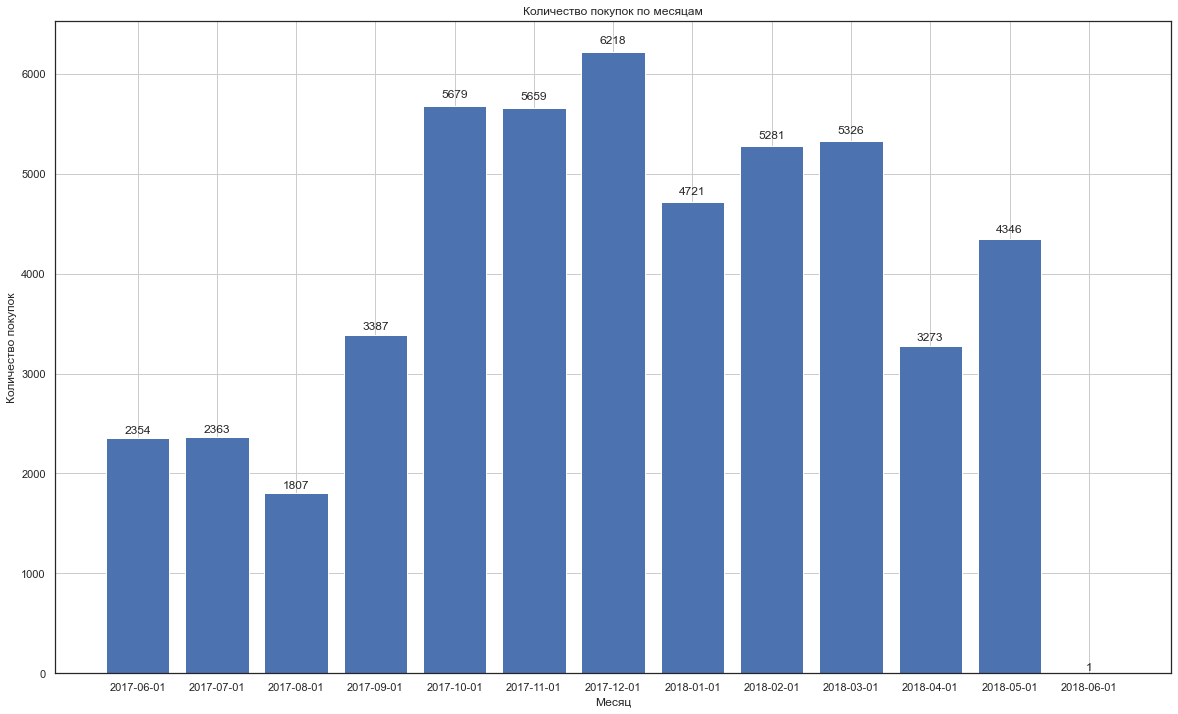

In [193]:
fig, ax = plt.subplots(figsize = (20,12))  

bar_x = [i for i in range(1,len(purchase_by_month)+1)]
bar_height = purchase_by_month['uid']
bar_tick_label = purchase_by_month['month_purchase'].dt.strftime('%Y-%m-%d')
bar_label = purchase_by_month['uid']  

bar_plot = plt.bar(bar_x,bar_height,tick_label=bar_tick_label)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)
        

autolabel(bar_plot)
    
    
plt.xlabel('Месяц')
plt.ylabel('Количество покупок')
plt.title('Количество покупок по месяцам')
plt.grid()
plt.show()

Среднее количество покупок в месяц составило 4201 покупку, медиана - 4533,5 покупок в месяц. На графике опять видим сезонность. В летние месяцы покупок в разы меньше, чем в осенне-зимне-весенние. Больше всего покупок было в декабре, на втором месте октябрь, хотя по недельным показателям казалось, что оба эти месяца проседают. Ноябрь только на третьем месте. Меньше всего покупок было в августе.

#### Средний чек <a id="purchase_mean_value"></a>

Посчитаем средний чек по всем данным.

In [194]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

Средняя выручка с заказа составила почти 5 рублей, а медиана - 2,5 рубля. При этом 75% значений не превысили 4,89 рублей с заказа. Посмотрим гистограмму этого распределения. Ограничим значение 50 рублями, так как большинство значений будут в диапазоне до 5 рублей.

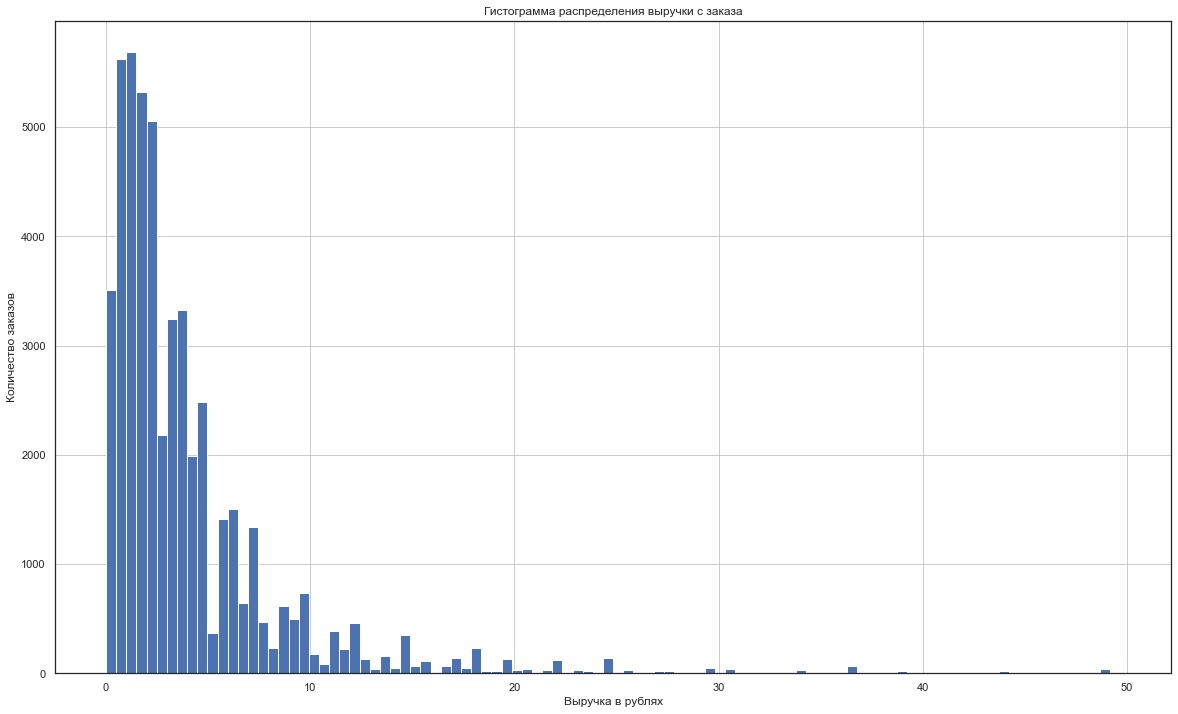

In [195]:
orders.query('revenue < 50')['revenue'].hist(bins=100, figsize=(20,12))
plt.title('Гистограмма распределения выручки с заказа')
plt.xlabel('Выручка в рублях')
plt.ylabel('Количество заказов')
plt.show()

Так и есть, в большинстве случаев выручка с заказа не превышала 20 рублей, после уже идут единичные заказы. 

Посмотрим, как вел себя средний чек в динамике по дням, неделям и месяцам.

In [196]:
revenue_by_date = orders.groupby('date_purchase')['revenue'].mean().reset_index()

In [197]:
revenue_by_date = revenue_by_date.sort_values(by = 'date_purchase')

In [198]:
revenue_by_date.describe()

revenue
count  364.000000
mean     4.936188
std      2.021881
min      1.948000
25%      3.960635
50%      4.561548
75%      5.411037
max     29.133313

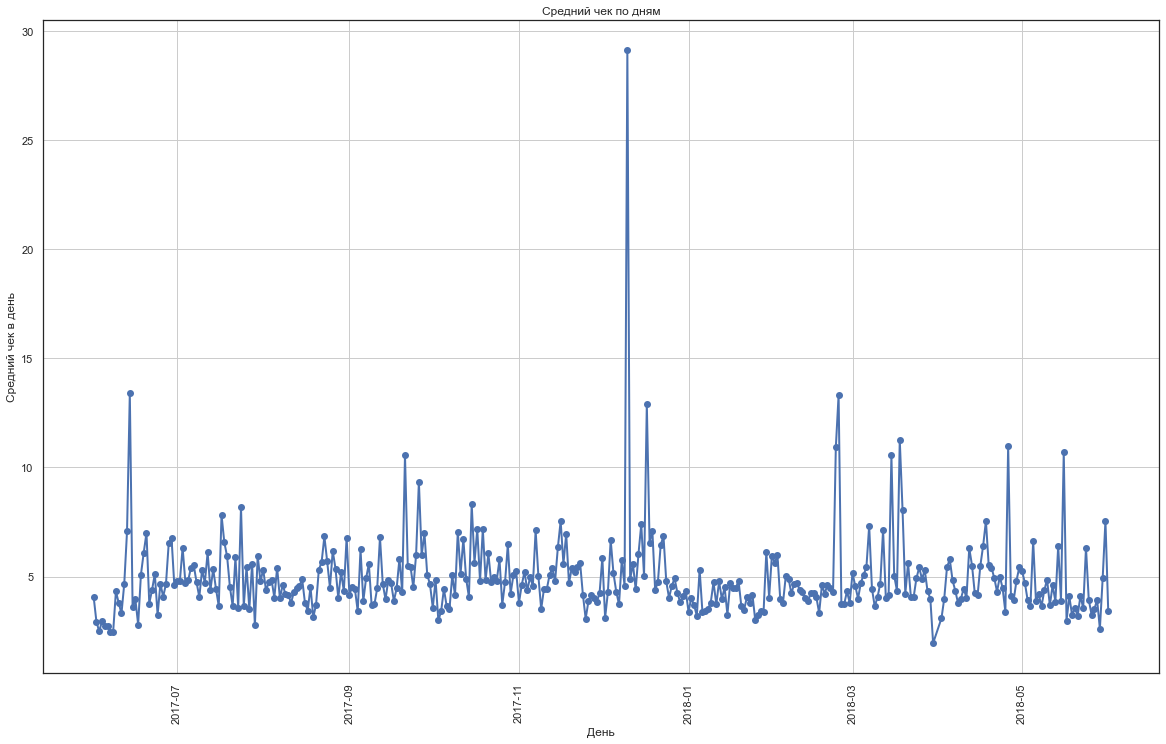

In [199]:
x = revenue_by_date['date_purchase']
y = revenue_by_date['revenue']

plt.figure(figsize=(20, 12))
plt.plot(x, y, 'o-', lw=2, mec='b', mew=2, ms=5)


plt.xlabel('День')
plt.ylabel('Средний чек в день')
plt.title('Средний чек по дням')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Среднее значение среднего чека в день составило 4,94 рубля, а медиана - 4,56 рублей. 75% значений не превысили 5,41 рубля. На графике сезонности особо не заметно, но пики есть. Максимальное значение составило 29,13 рублей за день.

Посмотрим на недельные значения.

In [200]:
revenue_by_week = orders.groupby('week_purchase')['revenue'].mean().reset_index()

In [201]:
revenue_by_week = revenue_by_week.sort_values(by='week_purchase')

In [202]:
revenue_by_week.describe()

revenue
count  53.000000
mean    4.995856
std     0.967166
min     2.842254
25%     4.342249
50%     4.831448
75%     5.343722
max     7.557021

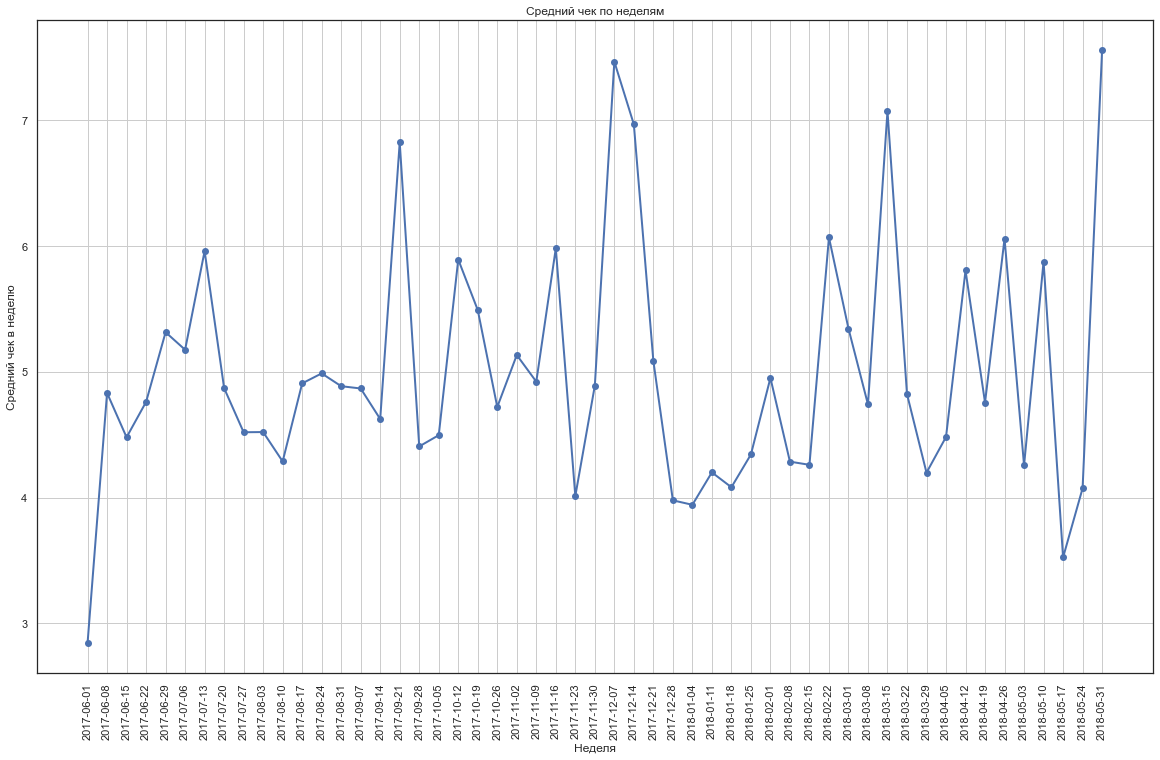

In [203]:
x = revenue_by_week['week_purchase'].astype(str)
y = revenue_by_week['revenue']

plt.figure(figsize=(20, 12))
plt.plot(x, y, 'o-', lw=2, mec='b', mew=2, ms=5)


plt.xlabel('Неделя')
plt.ylabel('Средний чек в неделю')
plt.title('Средний чек по неделям')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Среднее значение среднего чека в месяц составило почти 5 рублей, медиана - 4,83 рубля. 75% значений не превысили 5,34 рубля и максимальное значение составило всего лишь 7,56 рублей. Сезонности также не заметно. Самое высокое значение наблюдается за неделю 2017-12-07, последнюю неделю мая не будем учитывать, так как там был всего один день.

Посмотрим теперь месячные значения.

In [204]:
revenue_by_month = orders.groupby('month_purchase')['revenue'].mean().reset_index()

In [205]:
revenue_by_month = revenue_by_month.sort_values(by='month_purchase')

In [206]:
revenue_by_month.query('month_purchase < "2018-06-01"').describe()

revenue
count  12.000000
mean    4.956925
std     0.521265
min     4.060106
25%     4.780459
50%     4.887709
75%     5.333424
max     5.852139

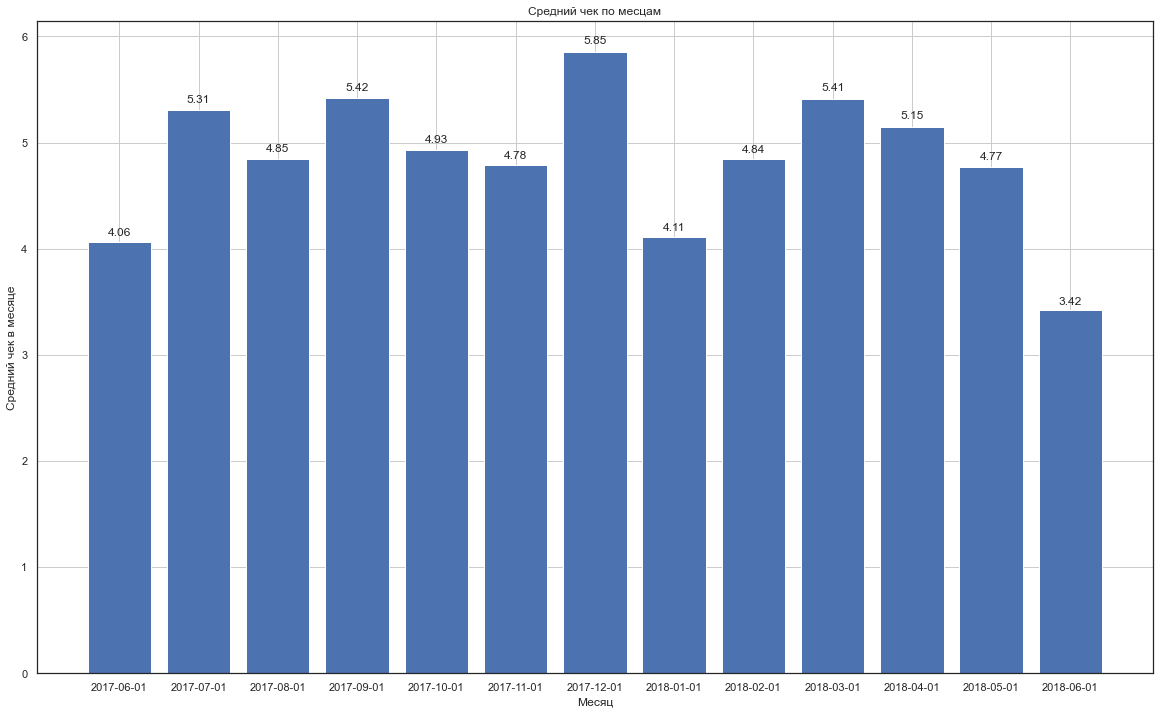

In [207]:
fig, ax = plt.subplots(figsize = (20,12))  

bar_x = [i for i in range(1,len(revenue_by_month)+1)]
bar_height = revenue_by_month['revenue']
bar_tick_label = revenue_by_month['month_purchase'].dt.strftime('%Y-%m-%d')
bar_label = revenue_by_month['revenue'].round(2)

bar_plot = plt.bar(bar_x,bar_height,tick_label=bar_tick_label)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)
    
    
plt.xlabel('Месяц')
plt.ylabel('Средний чек в месяце')
plt.title('Средний чек по месцам')
plt.grid()
plt.show()

Среднее значение среднего чека составило 4,96 в разбивке по месяцам, медиана - 4,89 рубля. Максимально значение было в декабре и составило 5,85 рублей, а минимальное - в июне 2017 и составило 4,06 рубля. На втором месте с конца оказался январь со значением 4,11 рубля. 

В целом, чем больше период усреднения, тем меньше разброс между данными. Среднее значение среднего чека стремится к 5 рублям во всех разбивках. 

#### Сколько денег приносят? (LTV) <a id="ltv"></a>

Так как маржинальность нам неизвестна, будем считать, что она равно 100%. Построим когорты по покупкам пользователей. Будем считать когорты от первой покупки пользователя.

In [208]:
orders['first_purchase_month'] = orders['first_purchase_date'].astype('datetime64[M]')

Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку. 

In [209]:
cohorts = orders.groupby(['first_purchase_month','month_purchase']).agg({'revenue': 'sum'}).reset_index()

In [210]:
cohorts.head()

first_purchase_month month_purchase  revenue
0           2017-06-01     2017-06-01  9557.49
1           2017-06-01     2017-07-01   981.82
2           2017-06-01     2017-08-01   885.34
3           2017-06-01     2017-09-01  1931.30
4           2017-06-01     2017-10-01  2068.58

Посчитаем количество новых покупателей за каждый месяц:

In [211]:
cohort_sizes = orders.query('buy_ts == first_purchase_date').groupby('first_purchase_month').agg(
    {'uid': 'nunique'}).reset_index()

In [212]:
cohort_sizes.head()

first_purchase_month   uid
0           2017-06-01  2023
1           2017-07-01  1923
2           2017-08-01  1370
3           2017-09-01  2581
4           2017-10-01  4340

Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [213]:
report = pd.merge(cohort_sizes, cohorts, on='first_purchase_month')

In [214]:
report.head()

first_purchase_month   uid month_purchase  revenue
0           2017-06-01  2023     2017-06-01  9557.49
1           2017-06-01  2023     2017-07-01   981.82
2           2017-06-01  2023     2017-08-01   885.34
3           2017-06-01  2023     2017-09-01  1931.30
4           2017-06-01  2023     2017-10-01  2068.58

LTV — относительный показатель. Удобнее его смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст (age) когорты.

In [215]:
report['age'] = (report['month_purchase'] - report['first_purchase_month']) / np.timedelta64(1, 'M')

In [216]:
report['age'] = report['age'].round().astype('int')

In [217]:
report.head()

first_purchase_month   uid month_purchase  revenue  age
0           2017-06-01  2023     2017-06-01  9557.49    0
1           2017-06-01  2023     2017-07-01   981.82    1
2           2017-06-01  2023     2017-08-01   885.34    2
3           2017-06-01  2023     2017-09-01  1931.30    3
4           2017-06-01  2023     2017-10-01  2068.58    4

Наконец, найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Для наглядности визуализируем когорты в виде сводной таблицы:

In [218]:
report['ltv'] = report['revenue'] / report['uid']

In [219]:
report.head()

first_purchase_month   uid month_purchase  revenue  age       ltv
0           2017-06-01  2023     2017-06-01  9557.49    0  4.724414
1           2017-06-01  2023     2017-07-01   981.82    1  0.485329
2           2017-06-01  2023     2017-08-01   885.34    2  0.437637
3           2017-06-01  2023     2017-09-01  1931.30    3  0.954671
4           2017-06-01  2023     2017-10-01  2068.58    4  1.022531

In [220]:
output = report.pivot_table(index='first_purchase_month', columns='age', values='ltv', aggfunc='mean').round(2)

In [221]:
output.fillna('') 

age                     0     1     2     3     4     5     6     7     8   \
first_purchase_month                                                         
2017-06-01            4.72  0.49  0.44  0.95  1.02  0.74  0.95  0.58  0.55   
2017-07-01            6.01  0.34  0.62  0.36  0.18  0.16  0.12  0.14  0.16   
2017-08-01            5.28  0.47  0.46  0.39  0.49  0.28  0.21  0.41  0.29   
2017-09-01            5.64  1.12  0.52  3.98   0.4  0.65   0.7  0.24  0.18   
2017-10-01            5.00  0.54  0.19  0.16  0.15  0.12  0.08  0.12         
2017-11-01            5.15   0.4   0.2  0.32  0.15  0.05  0.11               
2017-12-01            4.74  0.26  0.93  1.07  0.31  0.34                     
2018-01-01            4.14  0.29   0.3  0.14  0.06                           
2018-02-01            4.16  0.28  0.08  0.07                                 
2018-03-01            4.84   0.3  0.32                                       
2018-04-01            4.66  0.53                                             
2018-05-01            4.66                                                   
2018-06-01            3.42                                                   

age                     9     10    11  
first_purchase_month                    
2017-06-01            0.61  0.57  0.26  
2017-07-01            0.15  0.16        
2017-08-01            0.19              
2017-09-01                              
2017-10-01                              
2017-11-01                              
2017-12-01                              
2018-01-01                              
2018-02-01                              
2018-03-01                              
2018-04-01                              
2018-05-01                              
2018-06-01

Посчитаем итоговый LTV для каждой когорты.

In [222]:
ltv = output.sum(axis=1)

In [223]:
ltv

first_purchase_month
2017-06-01    11.88
2017-07-01     8.40
2017-08-01     8.47
2017-09-01    13.43
2017-10-01     6.36
2017-11-01     6.38
2017-12-01     7.65
2018-01-01     4.93
2018-02-01     4.59
2018-03-01     5.46
2018-04-01     5.19
2018-05-01     4.66
2018-06-01     3.42
dtype: float64

В среднем каждый покупатель из первой когорты принес по 11,88 рублей валовой прибыли за 12 месяцев «жизни». 
Выделились покупатели сентябрьской когорты, которые принесли 13,43 валовой прибыли за 9 месяцев «жизни». В 3-й месяц валовая прибыль с покупателя была необычной высокой и составила 3,98 рубля. Да и в первом месяце валовая прибыль с покупателя этой когорты была 1,12 рубля, тогда как в других когортах валовая прибыль была минимум в 2 раза ниже. В первый месяц средний покупатель приносит от 4 до 6 рублей. В следующий месяц валовая прибыль с покупателя уменьшается в 10 раз.

In [224]:
output.mean().round(2)

age
0     4.80
1     0.46
2     0.41
3     0.83
4     0.34
5     0.33
6     0.36
7     0.30
8     0.30
9     0.32
10    0.36
11    0.26
dtype: float64

#### Вывод <a id="output_sales"></a>

Чаще всего пользователи начинают покупать в течение первых минут на сайте. Самое частые значения - в течение первых 3 минут. Медиана времени между первым посещением и первой покупкой составила 16 минут. Но есть много пользователей, которые совершают первую покупку и по истечении довольно длиительного времени: 75% пользователям требуется не менее 48 часов, чтобы принять решение о покупке.

Среднее количество покупок:
 - в день - 138,5
 - в неделю - 951,2
 - в месяц - 4201
 
Средний чек и в целом по всем данным, и в разбивке по дням, неделям и месяцам стремится к 5 рублям. 

LTV среднего покупателя первой когорты составил 11,88 рублей за 12 месяцев жизни. Выделились покупатели сентябрьской когорты, которые принесли 13,43 валовой прибыли за 9 месяцев «жизни». В первый месяц средний покупатель приносит от 4 до 6 рублей, в среднем - 4,8. В следующий месяц валовая прибыль с покупателя уменьшается в 10 раз, в целом в следующие месяцы показатели валовой прибыли в основоном снижаются.

### Маркетинг <a id="marketing"></a>

#### Общие расходы и расходы в разбивке на каждый источник трафика / по времени <a id="costs"></a>

Посчитаем расходы. Сначала за весь период.

In [225]:
costs['costs'].sum()

329131.62

Итак, за весь период было потрачено 329 131.62 рубля. Теперь сделаем разбивку по источникам трафика.

In [226]:
costs.groupby('source_id')['costs'].sum().reset_index().sort_values(by='costs', ascending=False)

source_id      costs
2          3  141321.63
3          4   61073.60
4          5   51757.10
1          2   42806.04
0          1   20833.27
6         10    5822.49
5          9    5517.49

Больше всего денег было потрачено на 3-й источник трафика, расходы составили 141 321.63 рубля. На втором месте 4-й источник трафика с расходами на него 61 073.6 рубля. На третьем месте 5-й источник с расходами в 51 757 рублей. На 10-й и 9-й источники потратили меньше всего денег.

Теперь сгруппируем данные по времени. Начнем с данных за день.

In [227]:
costs_date = costs.groupby('dt')['costs'].sum().reset_index().sort_values(by='dt')

In [228]:
costs_date.describe()

costs
count   364.000000
mean    904.207747
std     396.956825
min       0.700000
25%     595.682500
50%     873.655000
75%    1155.605000
max    3458.860000

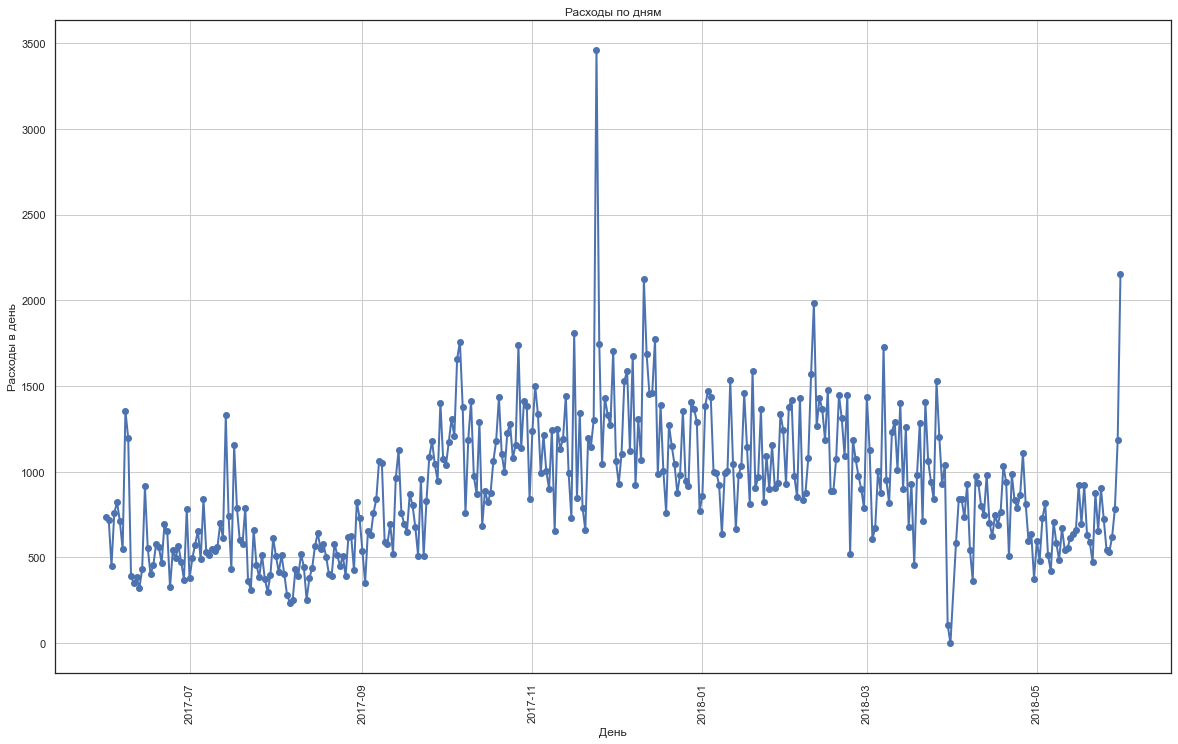

In [229]:
x = costs_date['dt']
y = costs_date['costs']

plt.figure(figsize=(20, 12))
plt.plot(x, y, 'o-', lw=2, mec='b', mew=2, ms=5)


plt.xlabel('День')
plt.ylabel('Расходы в день')
plt.title('Расходы по дням')
plt.xticks(rotation=90)
plt.grid()
plt.show()

В расходах также наблюдается сезонность. В среднем в день тратили 904 рубля, а по медиане - 873.65 рубля. Максимальное значение наблюдается в ноябре и составляет 3458,86 рублей. Пики расходов также наблюдаются в июне, в июле, октябре, декабре, феврале. Второй по высоте пик наблюдается в последние недели мая.

Посмотрим, как дневые показатели менялись по источникам трафика.

In [230]:
costs_date_source = costs.pivot_table(index='dt', columns='source_id', values='costs', aggfunc='sum')

In [231]:
costs_date_source = costs_date_source.sort_values(by='dt').fillna(0).reset_index()

In [232]:
costs_date_source.head()

source_id         dt      1       2       3       4       5      9     10
0         2017-06-01  75.20  132.56  349.38   76.74   73.24  13.06  15.08
1         2017-06-02  62.25  132.38  314.22   59.21  123.82  18.13  11.18
2         2017-06-03  36.53   77.20  196.12   59.39   64.93   7.06   9.62
3         2017-06-04  55.00   79.08  389.87  161.97   52.77   4.65  17.82
4         2017-06-05  57.08  108.96  424.47   44.65  144.30  15.30  26.68

In [233]:
costs_date_source.describe()

source_id          1           2            3           4           5   \
count      364.000000  364.000000   364.000000  364.000000  364.000000   
mean        57.234258  117.599011   388.246236  167.784615  142.189835   
std         27.938050   54.250323   210.184582  137.128253   65.289628   
min          0.000000    0.000000     0.000000    0.000000    0.700000   
25%         35.952500   77.457500   225.590000   59.405000   92.497500   
50%         54.595000  115.190000   352.820000  129.695000  137.300000   
75%         75.575000  148.955000   503.797500  253.492500  180.350000   
max        245.750000  507.090000  1788.280000  788.030000  719.220000   

source_id          9           10  
count      364.000000  364.000000  
mean        15.157940   15.995852  
std          6.866452    9.465130  
min          0.000000    0.000000  
25%          9.777500    9.130000  
50%         14.480000   14.615000  
75%         19.972500   21.487500  
max         49.530000   68.110000

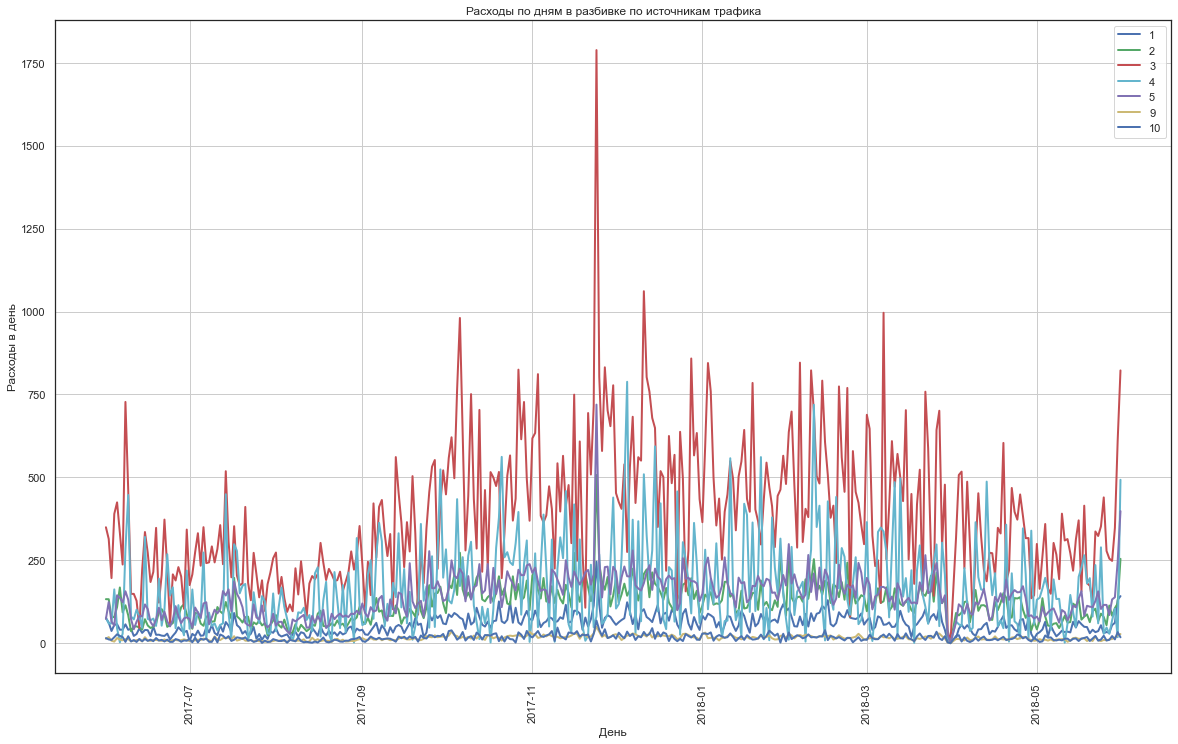

In [234]:
x = costs_date_source['dt']
y1 = costs_date_source[1]
y2 = costs_date_source[2]
y3 = costs_date_source[3]
y4 = costs_date_source[4]
y5 = costs_date_source[5]
y9 = costs_date_source[9]
y10 = costs_date_source[10]

plt.figure(figsize=(20, 12))
plt.plot(x, y1, '-b', lw=2, mew=2, ms=5, label='1')
plt.plot(x, y2, '-g', lw=2, mew=2, ms=5, label='2')
plt.plot(x, y3, '-r', lw=2, mew=2, ms=5, label='3')
plt.plot(x, y4, '-c', lw=2, mew=2, ms=5, label='4')
plt.plot(x, y5, '-m', lw=2, mew=2, ms=5, label='5')
plt.plot(x, y9, '-y', lw=2, mew=2, ms=5, label='9')
plt.plot(x, y10, '-', lw=2, mew=2, ms=5, label='10')


plt.xlabel('День')
plt.ylabel('Расходы в день')
plt.title('Расходы по дням в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

Сложно конечно понять, что происходит на таком графике. Видно, что третий источник трафика стабильно выше по расходам, чем остальные источники трафика. 4-й источник трафика тоже стабильно держится на втором месте. Срединие расходы в день по источникам такие: 
 - на первом месте 3-й источник со средним значением расходов 388.25 рублей в день
 - на втором месте 4-й источник, где средние расходы в день - 167.78 рублей
 - на третьем месте 5-й источник со средними расходами 142.18 рублей в дееь
 - на четвертом месте 2-й источнк со средними расходами 117.60 рублей в день
 - на пятом месте 1-й источник трафика с расходами в 57.23 рублей в день
 - последние места занимают 9-й и 10-й источники трафика с 15.16 и 15.99 рублями соотвественно.
 
Теперь посмотрим, что происходило в разбивке по неделям.

In [235]:
costs['week_costs'] = costs['dt'].astype('datetime64[W]')

In [236]:
costs_week = costs.groupby('week_costs')['costs'].sum().reset_index().sort_values(by='week_costs')

In [237]:
costs_week.describe()

costs
count     53.000000
mean    6210.030566
std     2196.813174
min     2153.700000
25%     4427.520000
50%     6113.440000
75%     7862.760000
max    11590.380000

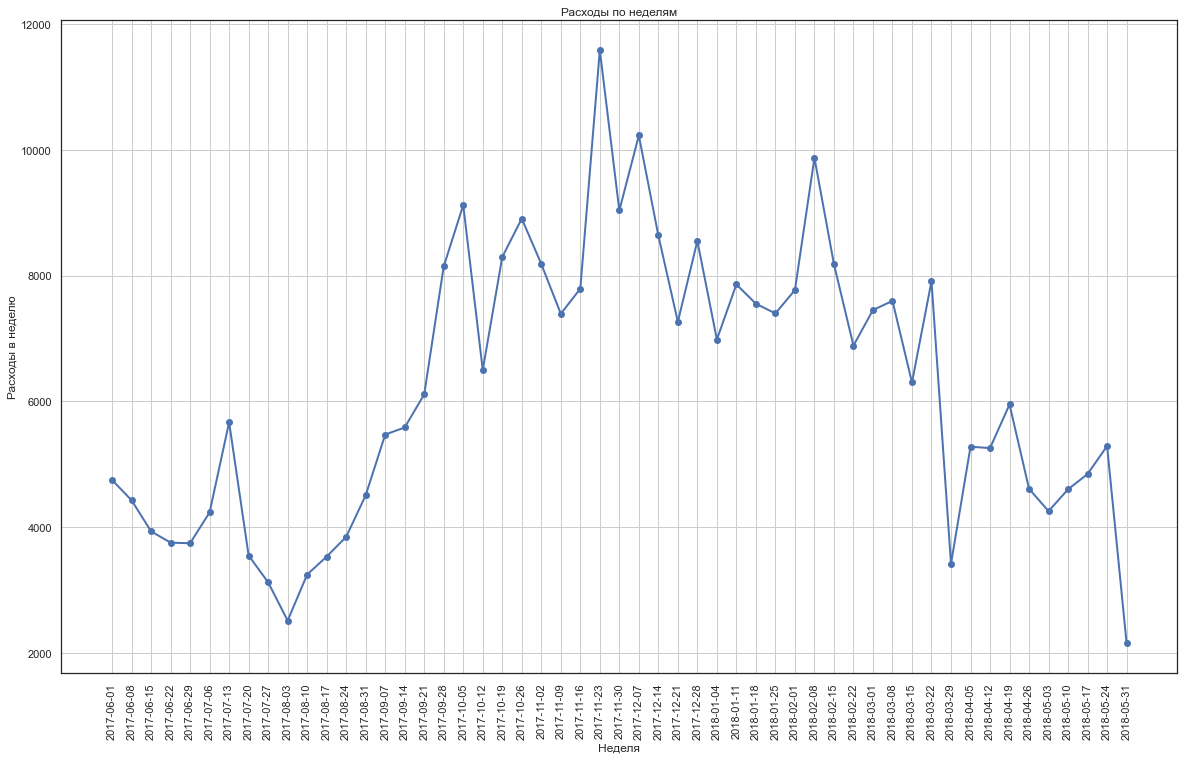

In [238]:
x = costs_week['week_costs'].astype(str)
y = costs_week['costs']

plt.figure(figsize=(20, 12))
plt.plot(x, y, 'o-', lw=2, mec='b', mew=2, ms=5)


plt.xlabel('Неделя')
plt.ylabel('Расходы в неделю')
plt.title('Расходы по неделям')
plt.xticks(rotation=90)
plt.grid()
plt.show()

В целом по неделям также видна сезонность в расходах. Пик расходов пришелся на неделю 2017-11-23 - как раз в эту неделю была самая высокая посещаемость - и достиг 11590.38 рублей за неделю. Средние расходы в неделю составили 6210.03 рублей, а медиана - 6113.44. 75% значений не превысили 7862.76 рублей в неделю. 

Посмотрим теперь данные в разбивке по источникам трафика.

In [239]:
costs_week_source = costs.pivot_table(index='week_costs', columns='source_id', values='costs', aggfunc='sum')

In [240]:
costs_week_source = costs_week_source.sort_values(by='week_costs').fillna(0).reset_index()

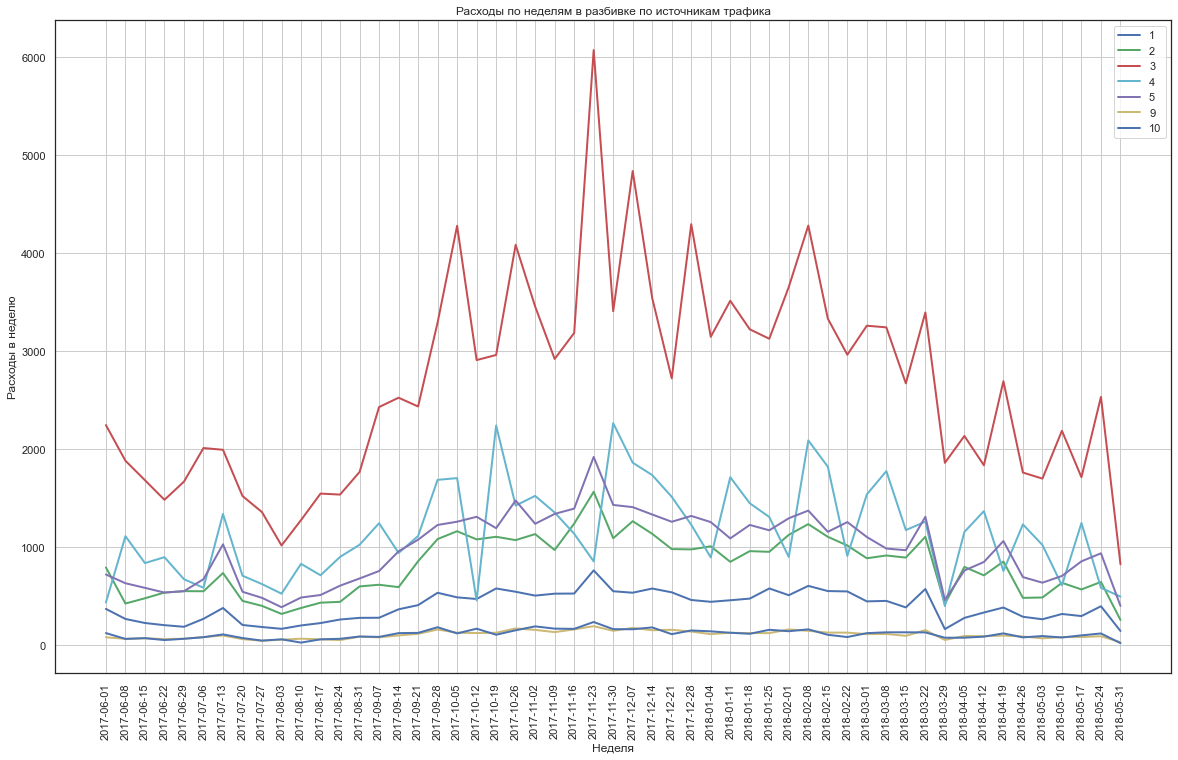

In [241]:
x = costs_week_source['week_costs'].astype(str)
y1 = costs_week_source[1]
y2 = costs_week_source[2]
y3 = costs_week_source[3]
y4 = costs_week_source[4]
y5 = costs_week_source[5]
y9 = costs_week_source[9]
y10 = costs_week_source[10]

plt.figure(figsize=(20, 12))
plt.plot(x, y1, '-b', lw=2, mew=2, ms=5, label='1')
plt.plot(x, y2, '-g', lw=2, mew=2, ms=5, label='2')
plt.plot(x, y3, '-r', lw=2, mew=2, ms=5, label='3')
plt.plot(x, y4, '-c', lw=2, mew=2, ms=5, label='4')
plt.plot(x, y5, '-m', lw=2, mew=2, ms=5, label='5')
plt.plot(x, y9, '-y', lw=2, mew=2, ms=5, label='9')
plt.plot(x, y10, '-', lw=2, mew=2, ms=5, label='10')


plt.xlabel('Неделя')
plt.ylabel('Расходы в неделю')
plt.title('Расходы по неделям в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

На недельных данных динамика по источникам трафика лучше заметна. 3-й источник трафика значительно выше остальных источник по расходам. 2-й, 4-й и 5-й примерно на одном уровне. Только на 4-м источнике значительно чаще бывают пики с увеличенными расходами. 2-й и 5-й источники более "гладкие", то есть по ним расходы распределяются более равномерно от недели к неделе. Дальше по высоте расходов идет 1-й источник. 9-й и 10-й источники идут вровень друг с другом в самом низу графика. 

In [242]:
costs_week_source.mean().reset_index().sort_values(by=0, ascending=False)

<ipython-input-242-ddc6efb45b3c>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  costs_week_source.mean().reset_index().sort_values(by=0, ascending=False)


source_id            0
2          3  2666.445849
3          4  1152.332075
4          5   976.549057
1          2   807.661132
0          1   393.080566
6         10   109.858302
5          9   104.103585

По средним значениям расходов за неделю источники находятся на тех же местах, что и в дневной разбивке. 

Посмотрим теперь месячные расходы.

In [243]:
costs['month_costs'] = costs['dt'].astype('datetime64[M]')

In [244]:
costs_month = costs.groupby('month_costs')['costs'].sum().reset_index().sort_values(by='month_costs')

In [245]:
costs_month.describe()

costs
count     12.000000
mean   27427.635000
std     8405.071207
min    14790.540000
25%    21228.350000
50%    27392.090000
75%    34219.610000
max    38315.350000

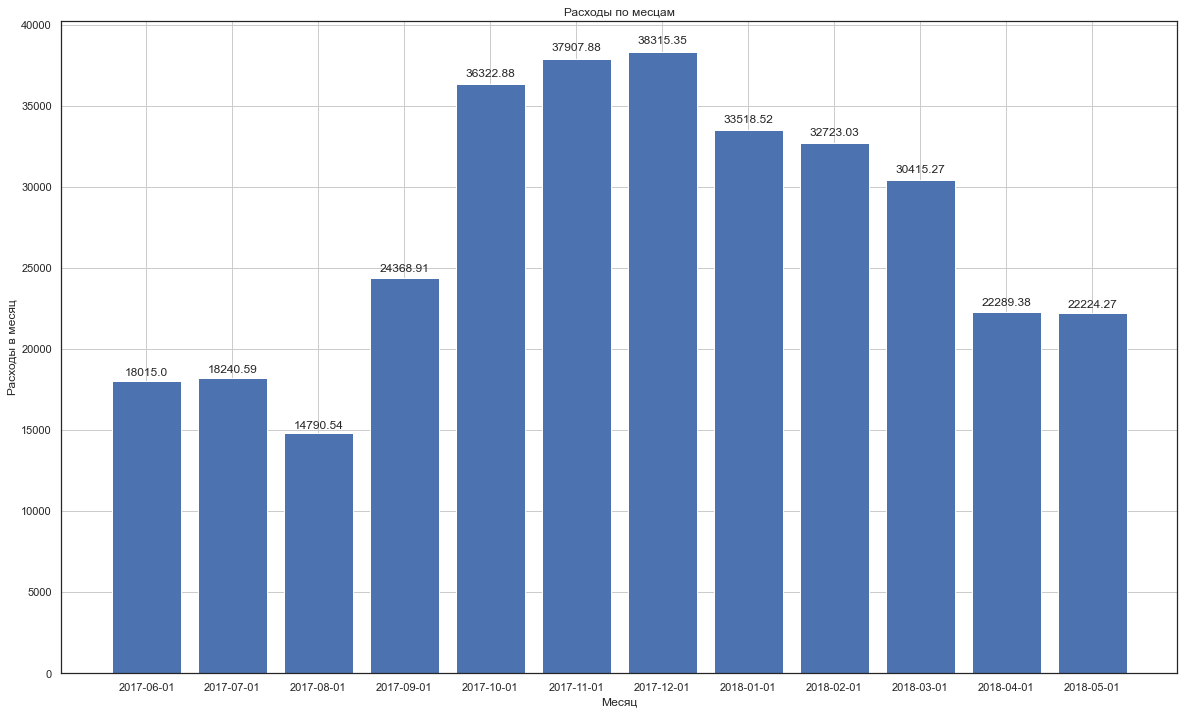

In [246]:
fig, ax = plt.subplots(figsize = (20,12))  

bar_x = [i for i in range(1,len(costs_month)+1)]
bar_height = costs_month['costs']
bar_tick_label = costs_month['month_costs'].dt.strftime('%Y-%m-%d')
bar_label = costs_month['costs'].round(2)

bar_plot = plt.bar(bar_x,bar_height,tick_label=bar_tick_label)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(bar_plot)
    
    
plt.xlabel('Месяц')
plt.ylabel('Расходы в месяц')
plt.title('Расходы по месцам')
plt.grid()
plt.show()

В месячных расходах также видна сезонность: самые большие расходы на рекламу в осенне-зимние месяцы, а меньше всего расходов в летние месяцы. Больше всего денег было потрачено в декабре - 38315.35 рублей. На втором месте ноябрь с расходами в 37907.88 рублей и на третьем месяце октябрь с расходами в 36322.88 рублей. Меньше всего денег было потрачено в августе, где расходы на рекламу составили 14790.54 рублей. 

Посмотрим теперь разбивку по источникам трафика.

In [247]:
costs_month_source = costs.pivot_table(index='month_costs', columns='source_id', values='costs', aggfunc='sum')

In [248]:
costs_month_source = costs_month_source.sort_values(by='month_costs').fillna(0).reset_index()

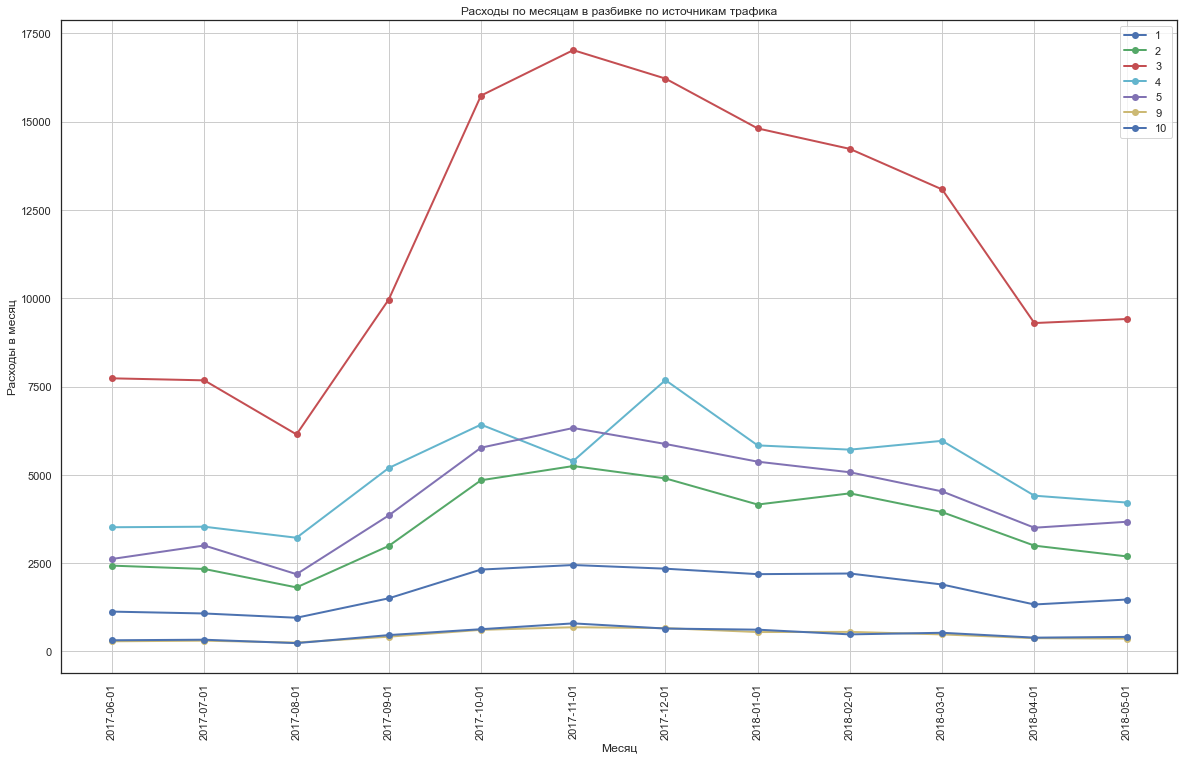

In [249]:
x = costs_month_source['month_costs'].astype(str)
y1 = costs_month_source[1]
y2 = costs_month_source[2]
y3 = costs_month_source[3]
y4 = costs_month_source[4]
y5 = costs_month_source[5]
y9 = costs_month_source[9]
y10 = costs_month_source[10]

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mew=2, ms=5, label='1')
plt.plot(x, y2, 'o-g', lw=2, mew=2, ms=5, label='2')
plt.plot(x, y3, 'o-r', lw=2, mew=2, ms=5, label='3')
plt.plot(x, y4, 'o-c', lw=2, mew=2, ms=5, label='4')
plt.plot(x, y5, 'o-m', lw=2, mew=2, ms=5, label='5')
plt.plot(x, y9, 'o-y', lw=2, mew=2, ms=5, label='9')
plt.plot(x, y10, 'o-', lw=2, mew=2, ms=5, label='10')


plt.xlabel('Месяц')
plt.ylabel('Расходы в месяц')
plt.title('Расходы по месяцам в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

В целом динамика такая же как и по неделям. 3-й источник определяет поведение динамики по месяцам по всем данным вцелом, так как по нему больше всего расходов. Однако на этом источнике самые большие расходы были в ноябре, а декабрь на общих данных вырывается вверх благодаря 4-му источнику трафику, где самые высокие расходы были в декабре. Посчитаем среднее по месяцам.

In [250]:
costs_month_source.mean().reset_index().sort_values(by=0, ascending=False)

<ipython-input-250-b04a043a87ca>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  costs_month_source.mean().reset_index().sort_values(by=0, ascending=False)


source_id             0
2          3  11776.802500
3          4   5089.466667
4          5   4313.091667
1          2   3567.170000
0          1   1736.105833
6         10    485.207500
5          9    459.790833

На 3-ем источнике трафика средние расходы в месяц составили 11776.80 рублей, на 4-м источнике расходы в месяц были в 2,3 раза ниже и составили 5089.5 рублей. На третьем месте 5-й источник трафика с расходами в 4313.09 в месяц. На последнем месте 9-й и 10-й источники трафика, где расходы не превысили 500 рублей в месяц.

#### Стоимость привлечения одного покупателя из каждого источника <a id="cac"></a>

Посчитаем  стоимость привлечения одного покупателя для каждой когорты - CAC. Сначала найдём суммарные расходы за каждый месяц по каждому источнику трафика, а затем поделим их на количество покупателей в каждой когорте.

In [251]:
monthly_costs = costs.groupby(['month_costs', 'source_id'])['costs'].sum().reset_index()

In [252]:
monthly_costs.head()

month_costs  source_id    costs
0  2017-06-01          1  1125.61
1  2017-06-01          2  2427.38
2  2017-06-01          3  7731.65
3  2017-06-01          4  3514.80
4  2017-06-01          5  2616.12

Теперь надо посчитать LTV по каждому источнику трафика.

In [253]:
cohorts_source = orders.groupby(
    ['first_purchase_month','month_purchase','source_id']).agg({'revenue': 'sum'}).reset_index()

In [254]:
cohorts_source.head()

first_purchase_month month_purchase  source_id  revenue
0           2017-06-01     2017-06-01          1  1378.70
1           2017-06-01     2017-06-01          2  1043.68
2           2017-06-01     2017-06-01          3  2804.34
3           2017-06-01     2017-06-01          4  1959.84
4           2017-06-01     2017-06-01          5  1898.89

Посчитаем количество новых покупателей за каждый месяц в разбивке по источникам трафика:

In [255]:
cohort_source_sizes = orders.query('buy_ts == first_purchase_date').groupby(
    ['first_purchase_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()

In [256]:
cohort_source_sizes.head()

first_purchase_month  source_id  uid
0           2017-06-01          1  190
1           2017-06-01          2  235
2           2017-06-01          3  638
3           2017-06-01          4  413
4           2017-06-01          5  384

Добавим в таблицу cohorts_source данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [257]:
report_source = pd.merge(cohort_source_sizes, cohorts_source, on=['first_purchase_month','source_id'])

In [258]:
report_source.head()

first_purchase_month  source_id  uid month_purchase  revenue
0           2017-06-01          1  190     2017-06-01  1378.70
1           2017-06-01          1  190     2017-07-01   414.98
2           2017-06-01          1  190     2017-08-01   419.43
3           2017-06-01          1  190     2017-09-01   714.24
4           2017-06-01          1  190     2017-10-01   811.20

Посчитаем возраст когорты:

In [259]:
report_source['age'] = (
    report_source['month_purchase'] - report_source['first_purchase_month']) / np.timedelta64(1, 'M')

In [260]:
report_source['age'] = report_source['age'].round().astype('int')

In [261]:
report_source.head()

first_purchase_month  source_id  uid month_purchase  revenue  age
0           2017-06-01          1  190     2017-06-01  1378.70    0
1           2017-06-01          1  190     2017-07-01   414.98    1
2           2017-06-01          1  190     2017-08-01   419.43    2
3           2017-06-01          1  190     2017-09-01   714.24    3
4           2017-06-01          1  190     2017-10-01   811.20    4

Найдем LTV:

In [262]:
report_source['ltv'] = report_source['revenue'] / report_source['uid']

Визуализируем LTV 3-го источника трафика:

In [263]:
output_3 = report_source.query('source_id == 3').pivot_table(
    index='first_purchase_month', columns='age', values='ltv', aggfunc='mean').round(2)

In [264]:
output_3.fillna('')

age                     0     1     2     3     4     5     6     7     8   \
first_purchase_month                                                         
2017-06-01            4.40  0.11  0.19  0.31  0.19  0.19  0.13  0.03  0.05   
2017-07-01            6.11  0.26  0.12  0.39  0.04  0.07  0.04  0.13  0.08   
2017-08-01            5.08  0.15  0.29  0.11  0.16  0.05  0.06  0.09  0.08   
2017-09-01            5.56  0.25  0.32  0.09  0.22  0.12  0.13  0.07  0.12   
2017-10-01            4.79  0.46  0.12  0.06  0.11   0.1  0.02  0.07         
2017-11-01            4.53  0.13  0.08  0.12  0.06  0.03  0.03               
2017-12-01            4.18  0.13  0.14  0.13   0.1  0.06                     
2018-01-01            4.11  0.18  0.13  0.08  0.05                           
2018-02-01            3.79  0.31  0.09  0.06                                 
2018-03-01            4.33  0.12  0.35                                       
2018-04-01            4.53  1.41                                             
2018-05-01            3.86                                                   

age                     9     10    11  
first_purchase_month                    
2017-06-01            0.05  0.03  0.03  
2017-07-01            0.04  0.06        
2017-08-01            0.06              
2017-09-01                              
2017-10-01                              
2017-11-01                              
2017-12-01                              
2018-01-01                              
2018-02-01                              
2018-03-01                              
2018-04-01                              
2018-05-01

Теперь добавим данные о расходах в отчёт и посчитаем CAC:

In [265]:
report_source_new = pd.merge(
    report_source, 
    monthly_costs, 
    left_on=['first_purchase_month','source_id'], 
    right_on=['month_costs','source_id'])

In [266]:
report_source_new['cac'] = report_source_new['costs'] / report_source_new['uid']

In [267]:
report_source_new.head() 

first_purchase_month  source_id  uid month_purchase  revenue  age       ltv  \
0           2017-06-01          1  190     2017-06-01  1378.70    0  7.256316   
1           2017-06-01          1  190     2017-07-01   414.98    1  2.184105   
2           2017-06-01          1  190     2017-08-01   419.43    2  2.207526   
3           2017-06-01          1  190     2017-09-01   714.24    3  3.759158   
4           2017-06-01          1  190     2017-10-01   811.20    4  4.269474   

  month_costs    costs       cac  
0  2017-06-01  1125.61  5.924263  
1  2017-06-01  1125.61  5.924263  
2  2017-06-01  1125.61  5.924263  
3  2017-06-01  1125.61  5.924263  
4  2017-06-01  1125.61  5.924263

In [268]:
cac_source = report_source_new.query('age == 0').pivot_table(
    index='first_purchase_month', columns='source_id', values='cac', aggfunc='sum').reset_index()

In [269]:
cac_source

source_id first_purchase_month         1          2          3         4  \
0                   2017-06-01  5.924263  10.329277  12.118574  8.510412   
1                   2017-07-01  6.705500  11.216875  14.989004  6.827331   
2                   2017-08-01  8.423097  14.723984  18.230089  9.518817   
3                   2017-09-01  6.616784  13.509774  12.757426  8.800441   
4                   2017-10-01  6.811029  12.234848  13.660799  5.478532   
5                   2017-11-01  7.546790  13.185126  14.001102  4.578437   
6                   2017-12-01  7.073112  12.855118  12.315505  5.577683   
7                   2018-01-01  9.185630  14.238836  14.720457  5.651928   
8                   2018-02-01  8.016291  15.270785  13.029817  5.164521   
9                   2018-03-01  6.736975  11.700712  13.640094  5.515143   
10                  2018-04-01  7.416145  14.255714  15.019079  6.407689   
11                  2018-05-01  6.089668   6.527767  11.150972  5.241555   

source_id         5         9        10  
0          6.812813  4.194412  3.307579  
1          7.087801  5.818077  6.467059  
2          6.070222  4.080820  6.285676  
3          6.535042  4.777241  5.356628  
4          6.103069  4.836587  3.001148  
5          9.127475  4.711586  6.190313  
6          7.616757  5.437851  7.598353  
7          8.485814  6.839500  6.677717  
8          7.479808  6.565476  3.909593  
9          8.578826  2.983168  2.830161  
10         8.142209  8.685814  3.628505  
11         7.383421  6.036167  3.152769

Теперь посчитаем затраты на одного покупателя сразу по всем источникам трафика:

In [270]:
monthly_costs_total = costs.groupby('month_costs')['costs'].sum().reset_index()

Добавим данные о расходах в общий отчёт и посчитаем CAC:

In [271]:
report_new = pd.merge(report, monthly_costs_total, left_on='first_purchase_month', right_on='month_costs')

In [272]:
report_new['cac'] = report_new['costs'] / report_new['uid']

In [273]:
report_new.head() 

first_purchase_month   uid month_purchase  revenue  age       ltv  \
0           2017-06-01  2023     2017-06-01  9557.49    0  4.724414   
1           2017-06-01  2023     2017-07-01   981.82    1  0.485329   
2           2017-06-01  2023     2017-08-01   885.34    2  0.437637   
3           2017-06-01  2023     2017-09-01  1931.30    3  0.954671   
4           2017-06-01  2023     2017-10-01  2068.58    4  1.022531   

  month_costs    costs       cac  
0  2017-06-01  18015.0  8.905091  
1  2017-06-01  18015.0  8.905091  
2  2017-06-01  18015.0  8.905091  
3  2017-06-01  18015.0  8.905091  
4  2017-06-01  18015.0  8.905091

In [274]:
cac_total = report_new.query('age == 0')[['first_purchase_month','uid','cac']].reset_index()

In [275]:
cac_total

index first_purchase_month   uid        cac
0       0           2017-06-01  2023   8.905091
1      12           2017-07-01  1923   9.485486
2      23           2017-08-01  1370  10.796015
3      33           2017-09-01  2581   9.441654
4      42           2017-10-01  4340   8.369327
5      50           2017-11-01  4081   9.288870
6      57           2017-12-01  4383   8.741809
7      63           2018-01-01  3373   9.937302
8      68           2018-02-01  3651   8.962758
9      72           2018-03-01  3533   8.608907
10     75           2018-04-01  2276   9.793225
11     77           2018-05-01  2988   7.437841

Проверим, все ли правильно мы посчитали. Возьмем первый месяц по источникам трафика:

In [276]:
check = report_source_new.query('age == 0 and first_purchase_month == "2017-06-01"')[
    ['first_purchase_month', 'source_id', 'uid', 'costs', 'cac']]

In [277]:
check

first_purchase_month  source_id  uid    costs        cac
0            2017-06-01          1  190  1125.61   5.924263
12           2017-06-01          2  235  2427.38  10.329277
24           2017-06-01          3  638  7731.65  12.118574
36           2017-06-01          4  413  3514.80   8.510412
48           2017-06-01          5  384  2616.12   6.812813
60           2017-06-01          9   68   285.22   4.194412
71           2017-06-01         10   95   314.22   3.307579

Посчитаем суммарные итоги:

In [278]:
check['costs'].sum()/check['uid'].sum()

8.905091448344043

Совпадает с суммарными данными по всем источникам трафика за первый месяц.

Построим графики.

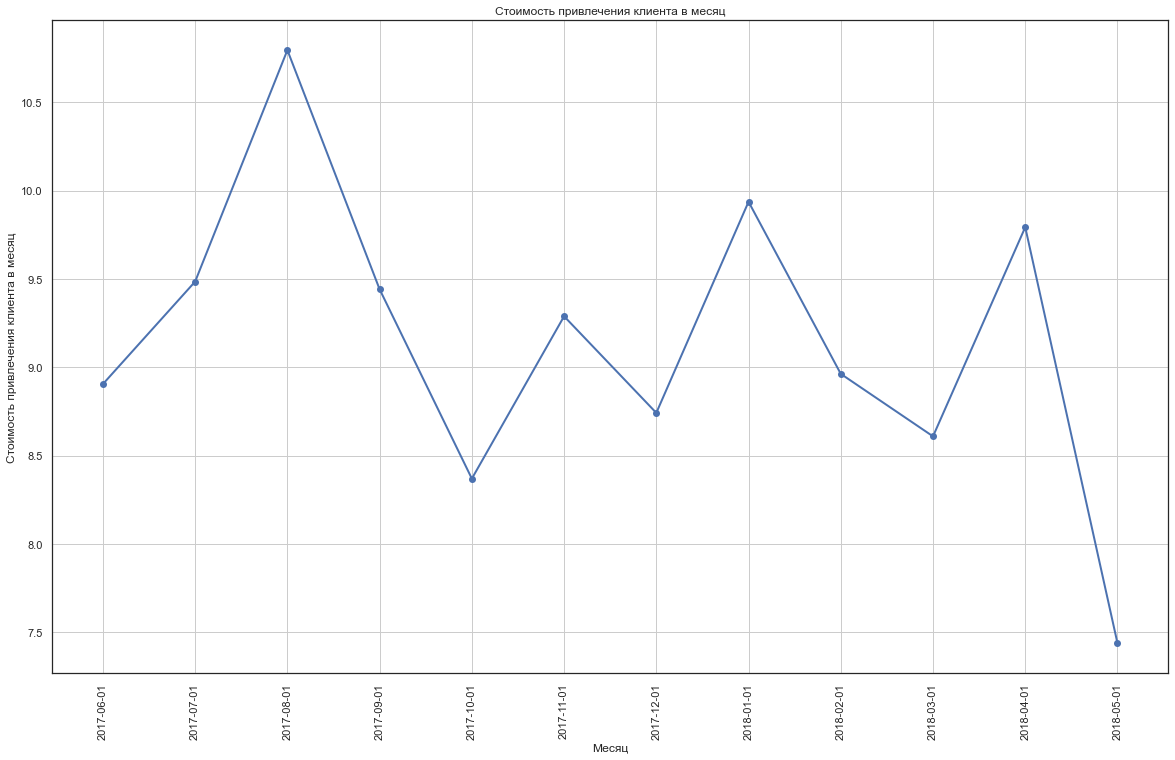

In [279]:
x = cac_total['first_purchase_month'].astype(str)
y = cac_total['cac']

plt.figure(figsize=(20, 12))
plt.plot(x, y, 'o-b', lw=2, mew=2, ms=5)

plt.xlabel('Месяц')
plt.ylabel('Стоимость привлечения клиента в месяц')
plt.title('Стоимость привлечения клиента в месяц')
plt.xticks(rotation=90)
plt.grid()
plt.show()

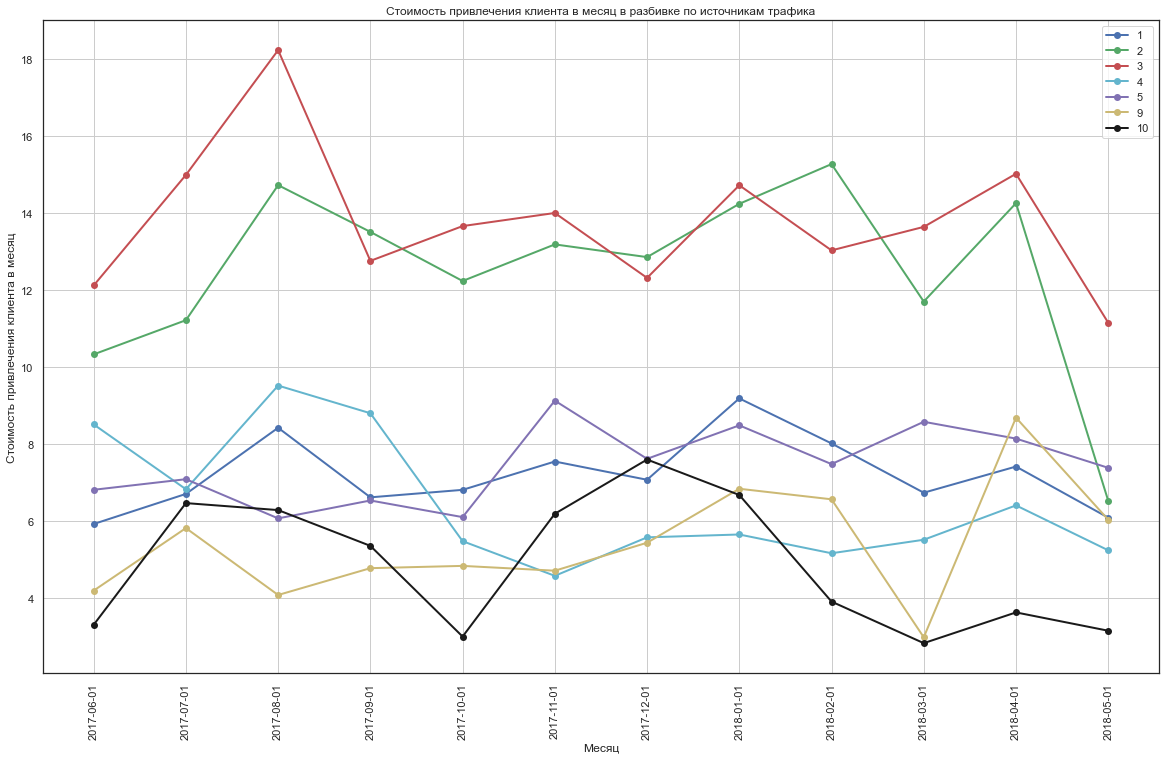

In [280]:
x = cac_source['first_purchase_month'].astype(str)
y1 = cac_source[1]
y2 = cac_source[2]
y3 = cac_source[3]
y4 = cac_source[4]
y5 = cac_source[5]
y9 = cac_source[9]
y10 = cac_source[10]

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mew=2, ms=5, label='1')
plt.plot(x, y2, 'o-g', lw=2, mew=2, ms=5, label='2')
plt.plot(x, y3, 'o-r', lw=2, mew=2, ms=5, label='3')
plt.plot(x, y4, 'o-c', lw=2, mew=2, ms=5, label='4')
plt.plot(x, y5, 'o-m', lw=2, mew=2, ms=5, label='5')
plt.plot(x, y9, 'o-y', lw=2, mew=2, ms=5, label='9')
plt.plot(x, y10, 'o-k', lw=2, mew=2, ms=5, label='10')


plt.xlabel('Месяц')
plt.ylabel('Стоимость привлечения клиента в месяц')
plt.title('Стоимость привлечения клиента в месяц в разбивке по источникам трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

In [281]:
cac_source.mean()

<ipython-input-281-3ff7d78b0ffe>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  cac_source.mean()


source_id
1      7.212107
2     12.504068
3     13.802743
4      6.439374
5      7.451938
9      5.413892
10     4.867125
dtype: float64

Итак, что мы имеем по расходам на пользователя. В суммарной таблице по всем источникам трафика дороже всего было привлечь пользователей в августе и стоимость привлечения одного клиента составила 10.8 рубля, а дешевле всего привлечение пользователей обошлось в мае и стоимость привлечения составила 7.44 рубля.

В разрезе по источникам трафика получилось:
 - стоимость привлечения пользователей 2-ого и 3-ого источников трафика обходится дороже всего и в среднем в месяц составиляет 12,5 рублей для 2-го источника и 13,8 для 3-го источника трафика. Дороже всего пользователи на этих источниках обошлись в августе, а дешевле - в мае.
 - дешевле всего обходится привлечения пользователей на 9-м и 10-м источниках и стоимость их привлечения в среднем в месяц составляет 5,41 рубля в месяц и 4,87 рублей в месяц соответсвенно. Причем на 9-м источнике трафика есть пик в апреле, когда привлечение покупателей в этот месяц становится дороже почти всех источников трафика, кроме 2-го и 3-го. 10-й источник тоже не очень стабильный - на нем расходы то вырастают выше 6 рублей в месяц, то падают ниже 4-х рублей. Однако, начиная с февраля расходы на пользователя на этом источнике выше 4-х рублей больше не поднимаются.
 - 1-й, 4-й и 5-й источники трафика имеют средние расходы на привлечение пользователей 7,21, 6,44 и 7,45 рублей соответсвенно. Они более стабильные по поведению, чем 9-й и 10-й источники. Однако, на 4-м источнике первые 4 месяца стоимость привлечения пользователя колебалась между 7 и 9 рублями, а с 5-го месяца почти не поднималась выше 6 рублей. На 5-м источнике трафика стоимость привлечения пользователя подросла с ноября и не становилась меньше 7 рублей в месяц. На первом источнике трафика пик привлечения пришелся на январь.

#### Окупаемость расходов(ROMI) <a id="roi"></a>

Рассчитаем ROMI: поделим LTV на CAC.

In [282]:
report_new['romi'] = report_new['ltv'] / report_new['cac']

In [283]:
report_source_new['romi'] = report_source_new['ltv'] / report_source_new['cac']

Чтобы посчитать накопительный ROMI, вызовем метод cumsum() и посчитаем накопительную сумму.

In [284]:
romi = report_new.pivot_table(index='first_purchase_month', columns='age', values='romi', aggfunc='mean')

In [285]:
romi.cumsum(axis=1).round(2).fillna('')

age                     0     1     2     3     4     5     6     7     8   \
first_purchase_month                                                         
2017-06-01            0.53  0.59  0.63  0.74  0.86  0.94  1.05  1.11  1.17   
2017-07-01            0.63  0.67  0.73  0.77  0.79  0.81  0.82  0.84  0.85   
2017-08-01            0.49  0.53  0.57  0.61  0.66  0.68   0.7  0.74  0.77   
2017-09-01            0.60  0.72  0.77  1.19  1.23   1.3  1.38   1.4  1.42   
2017-10-01            0.60  0.66  0.68   0.7  0.72  0.74  0.75  0.76         
2017-11-01            0.55   0.6  0.62  0.65  0.67  0.68  0.69               
2017-12-01            0.54  0.57  0.68   0.8  0.84  0.87                     
2018-01-01            0.42  0.45  0.48  0.49   0.5                           
2018-02-01            0.46  0.49   0.5  0.51                                 
2018-03-01            0.56   0.6  0.63                                       
2018-04-01            0.48  0.53                                             
2018-05-01            0.63                                                   

age                     9     10    11  
first_purchase_month                    
2017-06-01            1.24  1.31  1.33  
2017-07-01            0.87  0.88        
2017-08-01            0.78              
2017-09-01                              
2017-10-01                              
2017-11-01                              
2017-12-01                              
2018-01-01                              
2018-02-01                              
2018-03-01                              
2018-04-01                              
2018-05-01

Всего окупилось 2 когорты. Первая июньская когорта окупилась на 6-м месяце, когда ROMI составил 1,05. Сентябрьская когорта окупилась на третьем месяце, когда ROMI составил 1,19. Остальные когорты еще не окупились, даже июльская и июньская, где было достаточно много месяцев жизни у пользователей. Потенциал по окупаемости имеет декабрьская когорта, но явно это будет после 6-го месяца. Налицо - очень медленная окупаемость у пользователей.

Посмотрим окупаемость средней когорты:

In [286]:
romi.cumsum(axis=1).mean(axis=0) 

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

Благодаря высоким данным окупаемости сентябрьской когорты получается, что средняя когорта окупается на 8-м месяце жизни. Посчитаем среднее без сентябрьской когорты.

In [287]:
romi.query('first_purchase_month != "2017-09-01"').cumsum(axis=1).mean(axis=0) 

age
0     0.535632
1     0.568563
2     0.615480
3     0.660649
4     0.718383
5     0.785952
6     0.800636
7     0.861568
8     0.930837
9     0.964488
10    1.094658
11    1.333982
dtype: float64

Благодаря первой когорте, средняя когорта окупается на 10-й месяц. Это более жизненно для нашего набора данных.

Посчитаем теперь ROMI по источникам трафика. Начнем с первого источника.

In [288]:
romi_source_1 = report_source_new.query('source_id == 1').pivot_table(
    index='first_purchase_month', columns='age', values='romi', aggfunc='mean')

romi_source_1.cumsum(axis=1).round(2).fillna('')

age                     0     1     2     3     4     5     6     7     8   \
first_purchase_month                                                         
2017-06-01            1.22  1.59  1.97   2.6  3.32  3.67   4.1  4.53  4.91   
2017-07-01            1.09  1.25  2.05  2.27  2.41  2.54  2.61   2.7  2.83   
2017-08-01            0.89  1.03  1.15  1.27  1.39  1.47  1.55  1.86  2.13   
2017-09-01            0.91  1.18  1.27  1.41  1.41  1.43  1.44  1.49  1.57   
2017-10-01            0.88  1.04  1.07  1.13  1.14  1.16  1.18  1.23         
2017-11-01            0.98  1.06  1.18   1.3  1.32  1.34  1.35               
2017-12-01            0.65  0.69  0.73  0.77  0.77  0.78                     
2018-01-01            0.63  0.64  0.65  0.76  0.76                           
2018-02-01            0.58  0.71  0.72  0.76                                 
2018-03-01            1.39  1.67  1.79                                       
2018-04-01            0.63  0.67                                             
2018-05-01            0.86                                                   

age                     9     10    11  
first_purchase_month                    
2017-06-01            5.19   5.4  5.68  
2017-07-01            2.98  3.12        
2017-08-01            2.22              
2017-09-01                              
2017-10-01                              
2017-11-01                              
2017-12-01                              
2018-01-01                              
2018-02-01                              
2018-03-01                              
2018-04-01                              
2018-05-01

In [289]:
romi_source_1.cumsum(axis=1).mean(axis=0) 

age
0     0.892768
1     1.048742
2     1.258675
3     1.363425
4     1.565990
5     1.768576
6     2.038114
7     2.362370
8     2.860597
9     3.462846
10    4.256256
11    5.679045
dtype: float64

In [290]:
cac_source[1]

0     5.924263
1     6.705500
2     8.423097
3     6.616784
4     6.811029
5     7.546790
6     7.073112
7     9.185630
8     8.016291
9     6.736975
10    7.416145
11    6.089668
Name: 1, dtype: float64

На первом источнике трафика июньская, июльская и мартовские когорты окупились уже в нулевой месяц жизни. Хуже всего по окупаемости себя ведут декабрьская, январская и апрельские когорты. Лучше всего - июньская когорта. На 9-м месяце жизни доходы от пользователей в 5 раз превышают расходы. Средняя когорта на первом источнике трафике окупается на 1-м месяце жизни.

Смотрим второй источник трафика.

In [291]:
romi_source_2 = report_source_new.query('source_id == 2').pivot_table(
    index='first_purchase_month', columns='age', values='romi', aggfunc='mean')

romi_source_2.cumsum(axis=1).round(2).fillna('')

age                     0     1     2     3     4     5     6     7     8   \
first_purchase_month                                                         
2017-06-01            0.43  0.48   0.5  0.69  0.85  0.94   1.1  1.24  1.37   
2017-07-01            0.75  0.82  0.83  0.85  0.89  0.91  0.94  0.95  0.96   
2017-08-01            0.39  0.45  0.47  0.48  0.52  0.52  0.53  0.56  0.56   
2017-09-01            0.61  1.21  1.39  1.46  1.56  1.63  1.88  1.94  1.98   
2017-10-01            0.63  0.83  0.88  0.93  0.97  0.99     1  1.02         
2017-11-01            0.53   0.6  0.63  0.69  0.72  0.73  0.74               
2017-12-01            0.69  0.81  1.53  2.39  2.63  2.88                     
2018-01-01            0.31  0.38   0.5  0.52  0.54                           
2018-02-01            0.35   0.4  0.42  0.44                                 
2018-03-01            0.45  0.52  0.62                                       
2018-04-01            0.40  0.44                                             
2018-05-01            1.05                                                   

age                     9     10    11  
first_purchase_month                    
2017-06-01            1.44  1.57  1.61  
2017-07-01            0.98  1.01        
2017-08-01            0.56              
2017-09-01                              
2017-10-01                              
2017-11-01                              
2017-12-01                              
2018-01-01                              
2018-02-01                              
2018-03-01                              
2018-04-01                              
2018-05-01

In [292]:
romi_source_2.cumsum(axis=1).mean(axis=0) 

age
0     0.549286
1     0.630051
2     0.777428
3     0.939189
4     1.085749
5     1.229496
6     1.029998
7     1.140317
8     1.215401
9     0.994079
10    1.290747
11    1.612957
dtype: float64

На втором источнике трафика окупившиеся когорты - это июньская, июльсая,сеньтябрьская, октябрьская, декабрьская и майская. Вообще ROMI на втором источнике трафика очень неравномерный. Половина когорт очень быстро окупается, а вторая половина - очень медленно. Посмотрим на расходы на пользователя по месяцам на втором источнике трафика. 

In [293]:
cac_source[2]

0     10.329277
1     11.216875
2     14.723984
3     13.509774
4     12.234848
5     13.185126
6     12.855118
7     14.238836
8     15.270785
9     11.700712
10    14.255714
11     6.527767
Name: 2, dtype: float64

Видим, что в месяцы, где затраты были самые высокие, там и окупаемость растет очень медленно. А, например, в мае, где затраты на привлечение были в  2 раза ниже, чем в другие месяцы и окупаемость наступила с 0-го месяца.

Посмотрим на окупаемость 3-го источника трафика. На него были самые большие расходы.

In [294]:
romi_source_3 = report_source_new.query('source_id == 3').pivot_table(
    index='first_purchase_month', columns='age', values='romi', aggfunc='mean')

romi_source_3.cumsum(axis=1).round(2).fillna('')

age                     0     1     2     3     4     5     6     7     8   \
first_purchase_month                                                         
2017-06-01            0.36  0.37  0.39  0.41  0.43  0.44  0.45  0.46  0.46   
2017-07-01            0.41  0.42  0.43  0.46  0.46  0.47  0.47  0.48  0.48   
2017-08-01            0.28  0.29   0.3  0.31  0.32  0.32  0.32  0.33  0.33   
2017-09-01            0.44  0.46  0.48  0.49  0.51  0.51  0.52  0.53  0.54   
2017-10-01            0.35  0.38  0.39   0.4  0.41  0.41  0.41  0.42         
2017-11-01            0.32  0.33  0.34  0.35  0.35  0.35  0.36               
2017-12-01            0.34  0.35  0.36  0.37  0.38  0.38                     
2018-01-01            0.28  0.29   0.3  0.31  0.31                           
2018-02-01            0.29  0.31  0.32  0.33                                 
2018-03-01            0.32  0.33  0.35                                       
2018-04-01            0.30   0.4                                             
2018-05-01            0.35                                                   

age                     9     10    11  
first_purchase_month                    
2017-06-01            0.47  0.47  0.47  
2017-07-01            0.49  0.49        
2017-08-01            0.34              
2017-09-01                              
2017-10-01                              
2017-11-01                              
2017-12-01                              
2018-01-01                              
2018-02-01                              
2018-03-01                              
2018-04-01                              
2018-05-01

In [295]:
romi_source_3.cumsum(axis=1).mean(axis=0) 

age
0     0.336151
1     0.357750
2     0.367152
3     0.379767
4     0.394988
5     0.413851
6     0.423732
7     0.442706
8     0.454574
9     0.429613
10    0.479128
11    0.470834
dtype: float64

На третьем источнике окупаемость не насупает и через год. К 11 месяцу жизни расходы все еще в 2 раза больше суммарных доходов с пользователя.

Посмотрим на 4-й источник трафика.

In [296]:
romi_source_4 = report_source_new.query('source_id == 4').pivot_table(
    index='first_purchase_month', columns='age', values='romi', aggfunc='mean')

romi_source_4.cumsum(axis=1).round(2).fillna('')

age                     0     1     2     3     4     5     6     7     8   \
first_purchase_month                                                         
2017-06-01            0.56  0.56  0.58  0.64  0.77  0.95  1.11  1.14  1.17   
2017-07-01            0.81  0.82  0.83  0.86  0.86  0.87  0.89  0.89  0.91   
2017-08-01            0.53  0.55  0.56  0.59  0.61  0.63  0.64  0.66  0.67   
2017-09-01            0.54   0.6  0.63  0.66  0.67   0.7  0.84  0.87  0.88   
2017-10-01            0.80  0.82  0.85  0.87  0.89  0.91  0.93  0.94         
2017-11-01            1.12  1.26  1.29  1.38  1.42  1.43  1.48               
2017-12-01            0.75  0.76  0.78   0.8   0.8  0.82                     
2018-01-01            0.67  0.69  0.71  0.72  0.72                           
2018-02-01            0.79  0.81  0.82  0.82                                 
2018-03-01            0.83  0.84  0.86                                       
2018-04-01            0.78  0.81                                             
2018-05-01            0.90                                                   

age                     9     10    11  
first_purchase_month                    
2017-06-01            1.26  1.41  1.42  
2017-07-01            0.92  0.92        
2017-08-01            0.68              
2017-09-01                              
2017-10-01                              
2017-11-01                              
2017-12-01                              
2018-01-01                              
2018-02-01                              
2018-03-01                              
2018-04-01                              
2018-05-01

В первой когорте окупаемость наступает на 6-м месяце жизни. Ноябрьская когорта окупается с нулевого месяца жизни. Остальные когорты еще не вышли на окупаемость. Посчитаем средннюю окупаемость по всем когортам.

In [297]:
cac_source[4]

0     8.510412
1     6.827331
2     9.518817
3     8.800441
4     5.478532
5     4.578437
6     5.577683
7     5.651928
8     5.164521
9     5.515143
10    6.407689
11    5.241555
Name: 4, dtype: float64

При этом затраты в ноябре на привлечение пользователя самые низкие.

In [298]:
romi_source_4.cumsum(axis=1).mean(axis=0) 

age
0     0.757409
1     0.776915
2     0.791630
3     0.814921
4     0.843845
5     0.900297
6     0.980375
7     0.900496
8     0.904477
9     0.952753
10    1.165144
11    1.420471
dtype: float64

Тут видим, что окупаемость наступает с 10-го месяца жизни на 4-м источнике трафика

Смотрим, что с окупаемостью на 5-м источнике трафика.

In [299]:
romi_source_5 = report_source_new.query('source_id == 5').pivot_table(
    index='first_purchase_month', columns='age', values='romi', aggfunc='mean')

romi_source_5.cumsum(axis=1).round(2).fillna('')

age                     0     1     2     3     4     5     6     7     8   \
first_purchase_month                                                         
2017-06-01            0.73  0.86  0.92  1.05  1.15  1.19  1.33  1.41  1.49   
2017-07-01            0.75  0.79  0.86  0.88  0.89  0.91  0.91  0.92  0.94   
2017-08-01            0.83  0.96  1.09  1.21  1.39  1.49  1.55  1.59  1.63   
2017-09-01            0.95  0.98  1.03   3.5  3.62  3.93  3.97     4     4   
2017-10-01            0.83  0.87  0.89  0.91  0.93  0.95  0.97  0.99         
2017-11-01            0.50  0.52  0.53  0.54  0.55  0.56  0.57               
2017-12-01            0.66  0.68  0.69  0.69   0.7   0.7                     
2018-01-01            0.51  0.57  0.62  0.62  0.63                           
2018-02-01            0.58  0.59   0.6   0.6                                 
2018-03-01            0.56  0.56  0.57                                       
2018-04-01            0.51  0.52                                             
2018-05-01            0.57                                                   

age                     9     10    11  
first_purchase_month                    
2017-06-01            1.63  1.66  1.67  
2017-07-01            0.95  0.96        
2017-08-01            1.67              
2017-09-01                              
2017-10-01                              
2017-11-01                              
2017-12-01                              
2018-01-01                              
2018-02-01                              
2018-03-01                              
2018-04-01                              
2018-05-01

На 5-м источнике тоже очень неоднозначно с окупаемостью на разных когортах. Июньская, августовская и сентябрьские когорты начали окупаться, причем достаточно быстро со второго и третьего месяцев, остальные когорты - нет. Причем начиная с ноября когорты очень медленно набирают выручку для окупаемости. Посмотрим расходы на покупку пользователей по месяцам.

In [300]:
cac_source[5]

0     6.812813
1     7.087801
2     6.070222
3     6.535042
4     6.103069
5     9.127475
6     7.616757
7     8.485814
8     7.479808
9     8.578826
10    8.142209
11    7.383421
Name: 5, dtype: float64

Видим, что начиная с ноября немного увеличились расходы на привлечение клиентов на этом источнике трафика, однако этого хватило, чтобы снизить темпы окупаемости. Посчитаем среднее. Там правда очень выделяется сентябрьская когорта с большими значениями по окупаемости, поэтому посчитаем среднее с ней и без нее.

In [301]:
romi_source_5.cumsum(axis=1).mean(axis=0) 

age
0     0.664923
1     0.718179
2     0.779610
3     1.111582
4     1.231647
5     1.387731
6     1.549131
7     1.783598
8     2.016601
9     1.415622
10    1.306381
11    1.673333
dtype: float64

In [302]:
romi_source_5.query('first_purchase_month != "2017-09-01"').cumsum(axis=1).mean(axis=0) 

age
0     0.639171
1     0.692386
2     0.752140
3     0.812922
4     0.890580
5     0.964357
6     1.064788
7     1.229111
8     1.353805
9     1.415622
10    1.306381
11    1.673333
dtype: float64

С сентябрьской когортой средняя когорта на 5-м источнике трафика начинает окупаться с 3-го месяца, а без нее - с 6-6-го. 

Посмотрим теперь на 9-й источник трафика.

In [303]:
romi_source_9 = report_source_new.query('source_id == 9').pivot_table(
    index='first_purchase_month', columns='age', values='romi', aggfunc='mean')

romi_source_9.cumsum(axis=1).round(2).fillna('')

age                     0     1     2     3     4     5     6     7     8   \
first_purchase_month                                                         
2017-06-01            0.85  0.87  1.01  1.15  1.22  1.32  1.45  1.48  1.61   
2017-07-01            0.77   0.8   0.9  0.99  1.05  1.06  1.11  1.12  1.19   
2017-08-01            1.00  1.05   1.2  1.26  1.27  1.29  1.32   1.4  1.42   
2017-09-01            0.90  1.11  1.25  1.41  1.54  1.57  1.69  1.83  2.02   
2017-10-01            1.05  1.16  1.25  1.27  1.33  1.44  1.45  1.45         
2017-11-01            0.79  0.82  0.86  0.92  0.95  0.96  0.96               
2017-12-01            0.70  0.76  0.79  0.84  0.85  0.87                     
2018-01-01            0.41  0.45  0.48  0.48  0.48                           
2018-02-01            0.73  0.76  0.77                                       
2018-03-01            0.88  0.91  0.93                                       
2018-04-01            0.59  0.65                                             
2018-05-01            0.62                                                   

age                     9     10  
first_purchase_month              
2017-06-01            1.64  1.66  
2017-07-01             1.2  1.21  
2017-08-01            1.45        
2017-09-01                        
2017-10-01                        
2017-11-01                        
2017-12-01                        
2018-01-01                        
2018-02-01                        
2018-03-01                        
2018-04-01                        
2018-05-01

Когорты с июня по октябрь начинают быстро окупаться, а вот начиная с ноября коэффициент окупаемости резко снижает темпы роста. Посмотрим, какие были расходы на привлечение клиентов на 9-м источнике трафика.

In [304]:
cac_source[9]

0     4.194412
1     5.818077
2     4.080820
3     4.777241
4     4.836587
5     4.711586
6     5.437851
7     6.839500
8     6.565476
9     2.983168
10    8.685814
11    6.036167
Name: 9, dtype: float64

По расходам все не однозначно.В августе конечно затрат на пользователя было меньше всего и окупаемость наступила с 0-го месяца, но вот в ноябре расходов было даже больше, чем в октябре на пользователя. Но в ноябрьской когорте окупаемость так и не наступила, тогда как в октябрьской когорте окупаемость наступила с 0-го месяца. Посчитаем ROMI по средней когорте на 9-м источнике трафика.

In [305]:
romi_source_9.cumsum(axis=1).mean(axis=0) 

age
0     0.774013
1     0.847641
2     0.943664
3     1.041018
4     1.086613
5     1.216218
6     1.331051
7     1.455936
8     1.559885
9     1.428569
10    1.432871
dtype: float64

В средней когорте 9-го источника трафика окупаемость наступает с 3-го месяца.

Посмотрим теперь последний 10-й источник трафика.

In [306]:
romi_source_10 = report_source_new.query('source_id == 10').pivot_table(
    index='first_purchase_month', columns='age', values='romi', aggfunc='mean')

romi_source_10.cumsum(axis=1).round(2).fillna('')

age                      0     1     2     3     4     5     6     7     8  \
first_purchase_month                                                         
2017-06-01            0.73  0.77                                      0.77   
2017-07-01            0.54  0.54        0.56                          0.56   
2017-08-01            0.80  0.81  0.87                          0.89         
2017-09-01            0.42  0.43  0.44  0.48  0.49              0.49  0.49   
2017-10-01            0.87   0.9   0.9  0.91  0.92  0.93  0.93  0.95         
2017-11-01            0.75  0.76  0.76  0.79   0.8  0.81  0.82               
2017-12-01            0.50  0.52                    0.52                     
2018-01-01            0.46  0.47  0.48                                       
2018-02-01            0.63  0.66  0.66                                       
2018-03-01            1.21  1.24  1.25                                       
2018-04-01            0.67                                                   
2018-05-01            1.15                                                   

age                     9  
first_purchase_month       
2017-06-01                 
2017-07-01                 
2017-08-01            0.9  
2017-09-01                 
2017-10-01                 
2017-11-01                 
2017-12-01                 
2018-01-01                 
2018-02-01                 
2018-03-01                 
2018-04-01                 
2018-05-01

На 10-м источнике трафика пользователи из когорт бывают не в каждый месяц и часто приходят после большого перерыва. Окупаемость наступила у мартовской и майских когорт прямо с 0-го месяца. Другие когорты не вышли на окупаемость. При этом в 10 и 11 месяцах пользователей не было на первых двух когортах.

In [307]:
romi_source_10.cumsum(axis=1).mean(axis=0) 

age
0    0.727377
1    0.708520
2    0.765743
3    0.685040
4    0.737312
5    0.754071
6    0.876620
7    0.773929
8    0.608024
9    0.899557
dtype: float64

В средней когорте на 10-м источнике трафика окупаемость так и не наступила.

Построим результаты средних когорт на графике. Так как в 9-й и 10-й когортах нет последних месяцев, то во всех когортах уберем два последних месяца, чтобы можно было показать графики.

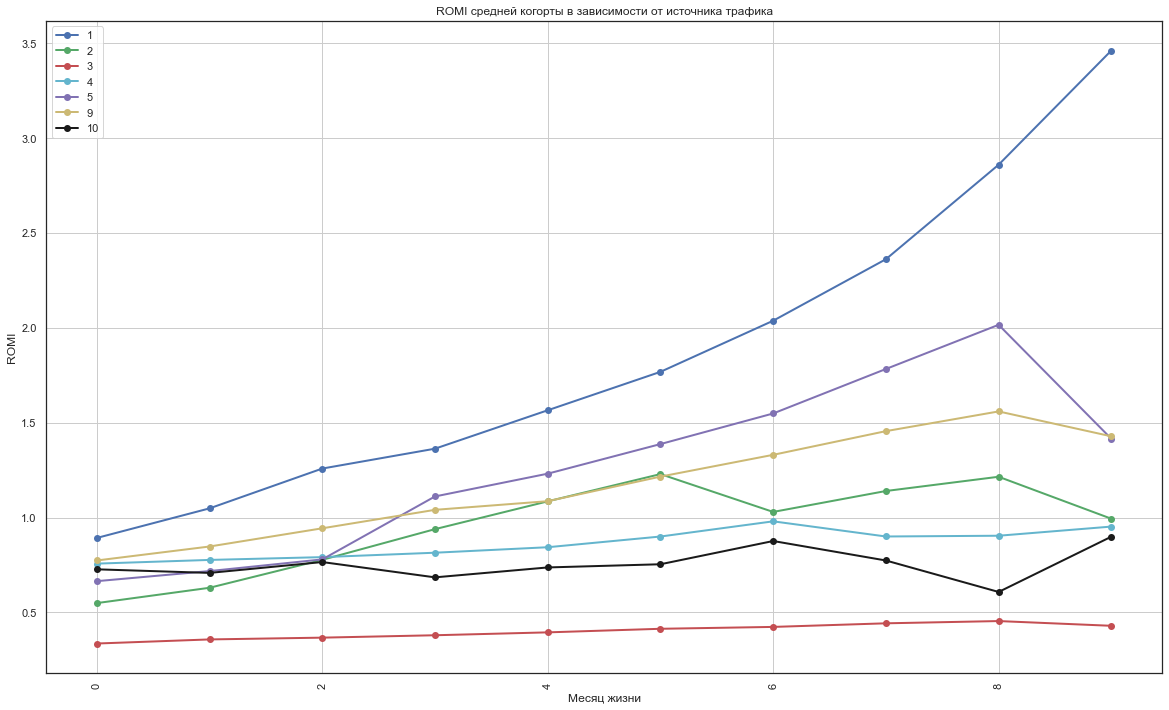

In [308]:
x = list(range(10))
y1 = romi_source_1.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 
y2 = romi_source_2.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 
y3 = romi_source_3.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 
y4 = romi_source_4.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 
y5 = romi_source_5.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 
y9 = romi_source_9.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 
y10 = romi_source_10.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mew=2, ms=5, label='1')
plt.plot(x, y2, 'o-g', lw=2, mew=2, ms=5, label='2')
plt.plot(x, y3, 'o-r', lw=2, mew=2, ms=5, label='3')
plt.plot(x, y4, 'o-c', lw=2, mew=2, ms=5, label='4')
plt.plot(x, y5, 'o-m', lw=2, mew=2, ms=5, label='5')
plt.plot(x, y9, 'o-y', lw=2, mew=2, ms=5, label='9')
plt.plot(x, y10, 'o-k', lw=2, mew=2, ms=5, label='10')


plt.xlabel('Месяц жизни')
plt.ylabel('ROMI')
plt.title('ROMI средней когорты в зависимости от источника трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

Первый источник трафика окупается быстрее всего благодаря первой июньской когорте, где значения ROMI с третьего месяца были выше 3-х. На втором месте 5-й источник трафика, в котором сентябрьская когорта с 3-го месяца начала показывать высокие результаты по ROMI. На третьем месте 9-й источник трафика, где запредельных цифр по ROMI не было.

Попробуем исключить явно выбивающиеся вверх когорты и заново построить графики и добавим еще ROMI по всем источникам вместе.

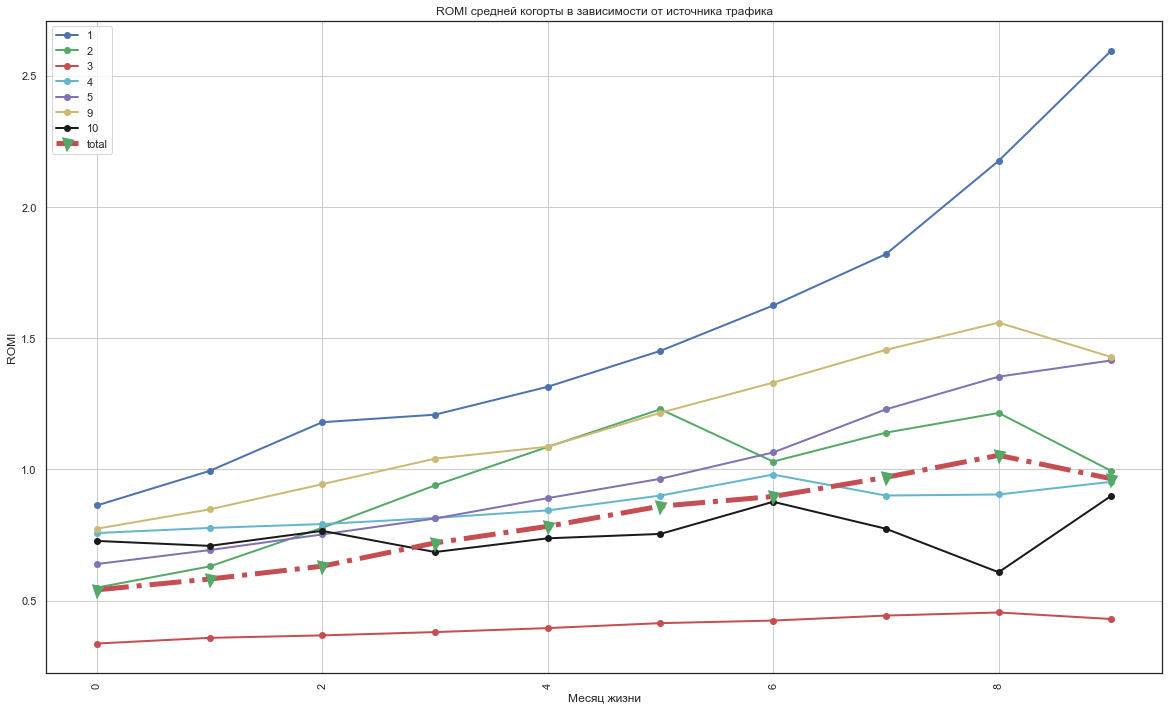

In [309]:
x = list(range(10))
y1 = romi_source_1.loc[:, 0 : 9].query('first_purchase_month != "2017-06-01"').cumsum(axis=1).mean(axis=0) 
y2 = romi_source_2.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 
y3 = romi_source_3.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 
y4 = romi_source_4.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 
y5 = romi_source_5.loc[:, 0 : 9].query('first_purchase_month != "2017-09-01"').cumsum(axis=1).mean(axis=0) 
y9 = romi_source_9.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 
y10 = romi_source_10.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 
y = romi.loc[:, 0 : 9].cumsum(axis=1).mean(axis=0) 

plt.figure(figsize=(20, 12))
plt.plot(x, y1, 'o-b', lw=2, mew=2, ms=5, label='1')
plt.plot(x, y2, 'o-g', lw=2, mew=2, ms=5, label='2')
plt.plot(x, y3, 'o-r', lw=2, mew=2, ms=5, label='3')
plt.plot(x, y4, 'o-c', lw=2, mew=2, ms=5, label='4')
plt.plot(x, y5, 'o-m', lw=2, mew=2, ms=5, label='5')
plt.plot(x, y9, 'o-y', lw=2, mew=2, ms=5, label='9')
plt.plot(x, y10, 'o-k', lw=2, mew=2, ms=5, label='10')
plt.plot(x, y, 'v-.r', lw=5, mew=5, ms=5, mec='g', label='total')

plt.xlabel('Месяц жизни')
plt.ylabel('ROMI')
plt.title('ROMI средней когорты в зависимости от источника трафика')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

Несмотря на то, что мы убрали когорты со слишком высокими показателями, все равно 1-й источник трафика окупается быстрее всего. Однако 9-й и 5-й источники трафика поменялись местами.  И даже 2-й источник обгоняет по окупаемости -й источник. Окпаемость на 2-м источнике наступает на-й месяц.  3-й, 4-й и 10-й источники трафика за 10 месяцев так и не вышли на окупаемость, хотя 4-й источник выходит на окупаемость с 10-го месяца, просто на графике это не отображено. 3-й источник вообще очень далек от окупаемости и явно ее не досттигнет. Общий ROMI по всем источникам трафика выходит на окупаемость с 8-го месяца. 

#### Вывод <a id="output_marketing"></a>

Расходы на привлечение клиентов имеют выраженную сезонность. Самые большие расходы на рекламу в осенне-зимние месяцы, а меньше всего расходов в летние месяцы. Больше всего денег было потрачено в декабре - 38315.35 рублей. На втором месте ноябрь с расходами в 37907.88 рублей и на третьем месяце октябрь с расходами в 36322.88 рублей. Меньше всего денег было потрачено в августе, где расходы на рекламу составили 14790.54 рублей.

3-й источник определяет поведение динамики по месяцам по всем данным вцелом, так как по нему больше всего расходов. Однако на этом источнике самые большие расходы были в ноябре, а декабрь на общих данных вырывается вверх благодаря 4-му источнику трафику, где самые высокие расходы были в декабре. На 3-ем источнике трафика средние расходы в месяц составили 11776.80 рублей, на 4-м источнике расходы в месяц были в 2,3 раза ниже и составили 5089.5 рублей. На третьем месте 5-й источник трафика с расходами в 4313.09 в месяц. На последнем месте 9-й и 10-й источники трафика, где расходы не превысили 500 рублей в месяц.

Дороже всего было привлечь пользователей в августе и стоимость привлечения одного клиента составила 10.8 рубля, а дешевле всего привлечение пользователей обошлось в мае и стоимость привлечения составила 7.44 рубля.

В разрезе по источникам трафика получилось:

 - стоимость привлечения пользователей 2-ого и 3-ого источников трафика обходится дороже всего и в среднем в месяц составиляет 12,5 рублей для 2-го источника и 13,8 для 3-го источника трафика. Дороже всего пользователи на этих источниках обошлись в августе, а дешевле - в мае.
 - дешевле всего обходится привлечения пользователей на 9-м и 10-м источниках и стоимость их привлечения в среднем в месяц составляет 5,41 рубля в месяц и 4,87 рублей в месяц соответсвенно. Причем на 9-м источнике трафика есть пик в апреле, когда привлечение покупателей в этот месяц становится дороже почти всех источников трафика, кроме 2-го и 3-го. 10-й источник тоже не очень стабильный - на нем расходы то вырастают выше 6 рублей в месяц, то падают ниже 4-х рублей. Однако, начиная с февраля расходы на пользователя на этом источнике выше 4-х рублей больше не поднимаются.
 - 1-й, 4-й и 5-й источники трафика имеют средние расходы на привлечение пользователей 7,21, 6,44 и 7,45 рублей соответсвенно. Они более стабильные по поведению, чем 9-й и 10-й источники. Однако, на 4-м источнике первые 4 месяца стоимость привлечения пользователя колебалась между 7 и 9 рублями, а с 5-го месяца почти не поднималась выше 6 рублей. На 5-м источнике трафика стоимость привлечения пользователя подросла с ноября и не становилась меньше 7 рублей в месяц. На первом источнике трафика пик привлечения пришелся на январь.

Показатель ROMI ведет себя по-разному на разных когортах, но видна особенность, что чаще всего первые когорты окупаются быстрее, чем когорты второй половины периода. Окупаемость суммарно по всем данным наступает в среднем на 8-й месяц. 

Быстрее всего окупается 1-й источник трафика, по средней когорте уже в первый месяц его ROMI составляет 1. На втором месте по окупаемости 9-й источник трафика, на котором окупаемость наступает в среднем на третий месяц. На третьем месте по окупаемости 2-й источник трафика, в среднем окупаемость на этом источнике наступает на 4-й месяц. А на четвертом месте 5-й источник трафика, где окупаемость наступает в среднем на 6-й месяц. 4-й источник трафика выходит на окупаемость с 10-го месяца. 10-й источник в среднем стремится к окупаемости, но не выходит на нее в основном потому, что пользователи этого источника в когортах бывают не каждый месяц. А вот 3-й источник трафика очень далек от окупаемости. По средней когорте этого источника даже в 11-й месяц ROMI не достигает даже 0.5. То есть этот источник никогда не окупится.



## Общий вывод <a id="output"></a>

Для оптимизации маркетинговых затрат ниже представлены следующие рекомендации:

 - Несмотря на то, что 3-й источник трафика на втором месте по количеству пользователей в месяц, необходимо от него отказаться, так как пользователи этого источника не выходят на окупаемость. 
 - Сосредоточиться на 4-м источнике трафика. Он первый по количеству пользователей в месяц. Затраты на привлечение клиентов на этом источнике трафика не очень высокие, при этом в ноябре, когда затраты на привлечение не превысили 5 рублей на пользователя, когорта этого месяца вышла на окупаемость сразу же. В среднем окупаемоть на этом источнике достигается с 10-го месяца, но если поработать над временем до первой покупки с пользователями 4-го источника трафика, то окупаемость может наступать и раньше.
 - Нарастить количество пользователей 1-го источника трафика, потому что пользователи этого источника окупаются быстрее всего. Также на этом источнике самая длительная сессия, что тоже повышает шанс покупки в первое посещение. При этом расходы на привлечение пользователей на этом источнике трафика не очень высокие.
 - Также попробовать увеличить количество пользователей 2-го и 9-го источника трафика, так как пользователи этотих источников также выходят на окупаемость. На втором источнике нужно снизить расходы на привлечение пользователей, тогда окупаемость будет наступать быстрей на этом источнике.
 - На 5-м источнике трафика тоже необходимо снизить расходы на привлечение пользователей. Во вторую половину года, когда расходы на привлечение на этом источнике превысили 7 рублей, то и темпы роста ROMI снизились, а до этого на первых когортах окупаемость наступала довольно быстро.
 - Рекомендуеются нарастить количество пользователей на компьютерах, так как время сессии на компьютерах дольше, чем на мобильных устройствах и по 75% составяет 17 минут. Тогда как на устройствах только 12 минут. А по исследованию известно, что медианное время до первой покупки составляет 16 минут, поэтому вероятность, что пользователь на компьюетере совершит покупку в первую сессию увеличивается. Либо стоит попробовать увеличить время сессии на мобильных устройствах.
 - Также для более быстрой окупаемости рекомендуется повысить возвращаемость пользователей, так как в текущий момент она очень низкая и вообще удивительно, что окупаемость наступает хотя бы на 8 месяц. Во многом это благодаря первым когортам, когда возвращаемость была выше, чем в когортах второго периода. Поэтому очень важно начать работать с возвращаемостью, иначе окупаемости в новых когортах можно не достичь вообще.